/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


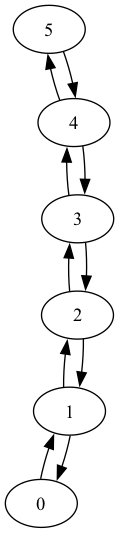

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

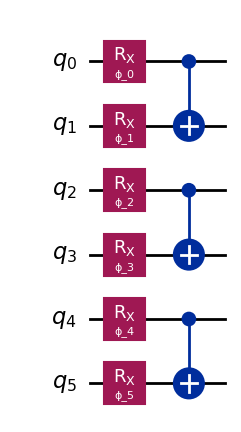

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


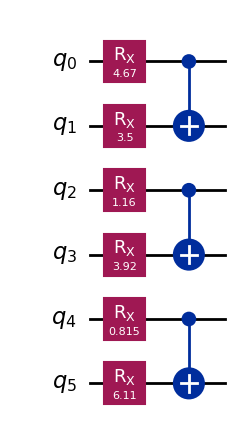

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

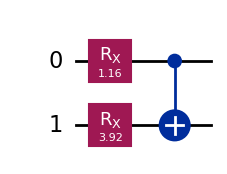

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

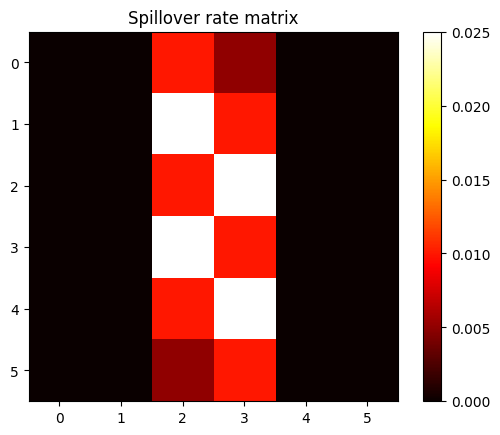

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 3] = 0.01  # γ_2->3
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
gamma_matrix[0, 2] = 0.01  # γ_0->2
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 2] = 0.01  # γ_1->2
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 2] = 0.01  # γ_4->2
gamma_matrix[5, 2] = 0.005  # γ_5->2
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.   , 0.   , 0.01 , 0.005, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.01 , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.01 , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.005, 0.01 , 0.   , 0.   ]])

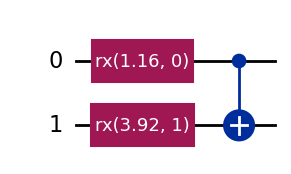

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j],
       [0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '3b81f1b101c04791bec7b7a68a84fdc8',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99004246+0.j        , 0.        -0.14076906j],
              [0.        -0.14076906j, 0.99004246+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': '1adb1287d0e547bb83a9eca8aef4c930',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99459537+0.j      , 0.        -0.103827j],
              [0.        -0.103827j, 0.99459537+0.j      ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x157b1f450>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '3b81f1b101c04791bec7b7a68a84fdc8',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99004246+0.j        , 0.        -0.14076906j],
              [0.        -0.14076906j, 0.99004246+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': '1adb1287d0e547bb83a9eca8aef4c930',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99459537+0.j      , 0.        -0.103827j],
              [0.        -0.103827j, 0.99459537+0.j      ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


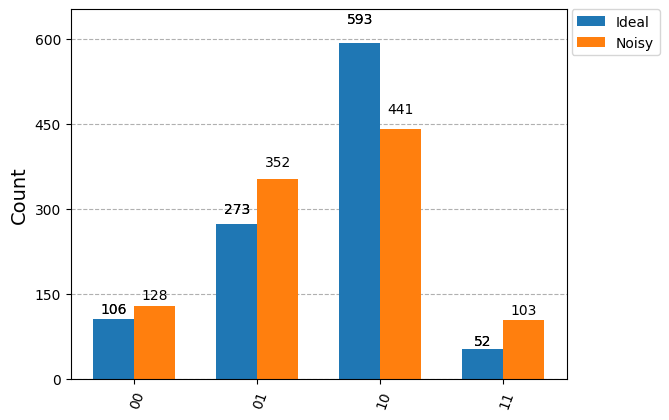

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9756941140306822

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        new_params[0],
        -0.5 * np.pi,
        0.5 * np.pi,
        q_reg[0],
    )
    my_qc.u(
        0,
        new_params[1],
        new_params[2],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.3, high=0.3, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[10,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [22]:
# Constructing general angle spillover env

from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=2,
    applied_qubits=[0, 1, 2, 3, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)
rescaled_g_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [23]:
rescaled_g_env.unwrapped.batch_size

32

In [24]:
print(rescaled_g_env.unwrapped.discrete_obs_vals_raw)

[[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]


In [25]:
obs, _ = rescaled_g_env.unwrapped.reset(
    debug_obs=rescaled_g_env.unwrapped.obs_raw_to_angles(np.array([1., 1., 1., 1., 1., 1.]))
)

Sampled angles:  [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
Environment Observation: [1. 1. 1. 1. 1. 1.]


In [26]:
print(general_env.observation_space.shape[0])

6


In [27]:
print(gamma_matrix.T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.01  0.025 0.01  0.025 0.01  0.005]
 [0.005 0.01  0.025 0.01  0.025 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [40]:
computed_spillover_angles = general_env.gamma_matrix.T @ general_env.phi_vec
print(computed_spillover_angles)
subsystem_spillover_angles = computed_spillover_angles[2:4]
print(subsystem_spillover_angles)
subsystem_spillover_angles / np.pi

opt_action = np.zeros((1, 7))
opt_action[0, [0, 3]] = -subsystem_spillover_angles

[0.         0.         0.26703538 0.26703538 0.         0.        ]
[0.26703538 0.26703538]


In [29]:
subsystem_spillover_angles[0] = 0.5 * subsystem_spillover_angles[0]
subsystem_spillover_angles

array([0.13351769, 0.26703538])

In [39]:
opt_action

array([[ 0.        ,  0.        , -0.26703538, -0.26703538,  0.        ,
         0.        ,  0.        ]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835131
Reward (avg): 0.9718971700835131 Std: 0.0
Number of repetitions: 2
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835131
Reward (avg): 0.9181682457104159 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835131
Reward (avg): 0.8200968698469463 Std: 0.0
Number of repetitions: 4
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835131
Reward (avg): 0.7140416209953335 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9718971700835131
Reward (avg): 0.5924790485698651 Std: 0.0
Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (

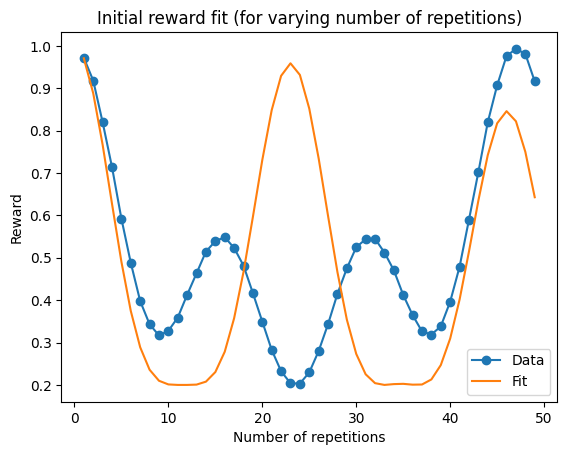

In [43]:
fig, reward_data = general_env.initial_reward_fit(
    np.zeros((1, 7)),
    # opt_action,
    ExecutionConfig(
        sampling_paulis=100,
        n_shots=10,
        n_reps=list(
            range(1, 50, 1),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    fit_p0=list(subsystem_spillover_angles)
)

[0.2832951  0.26186433]


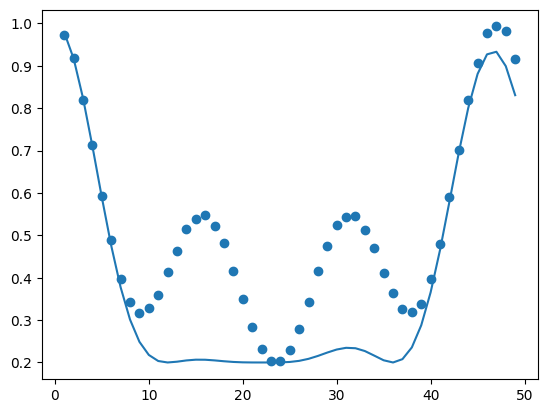

In [48]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

n_reps = np.array(list(range(1, 50, 1)))

def two_qubit_general_fit(n, phi_1, phi_2):
    channel_fid = np.cos(n * phi_1 / 4) ** 4 * np.cos(n * phi_2 / 2) ** 2
    return (4 * channel_fid + 1) / 5

p0 = [0.26, 0.26]  # Initial guess for the parameter
lower_bounds = [0., 0.0]
upper_bounds = [np.pi, np.pi]

popt, pcov = curve_fit(
    two_qubit_general_fit,
    n_reps,
    reward_data,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
)

print(popt)

plt.scatter(n_reps, reward_data)
plt.plot(n_reps, two_qubit_general_fit(n_reps, *popt))
plt.show()

In [31]:
general_env.batch_size

32

## Running Training for One Spillover Qubit, Fidelity Access, with Random Uniform Sampling

In [36]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 4, 5],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [37]:
train_env.batch_size

32

In [38]:
rescaled_q_env.unwrapped.batch_size

32

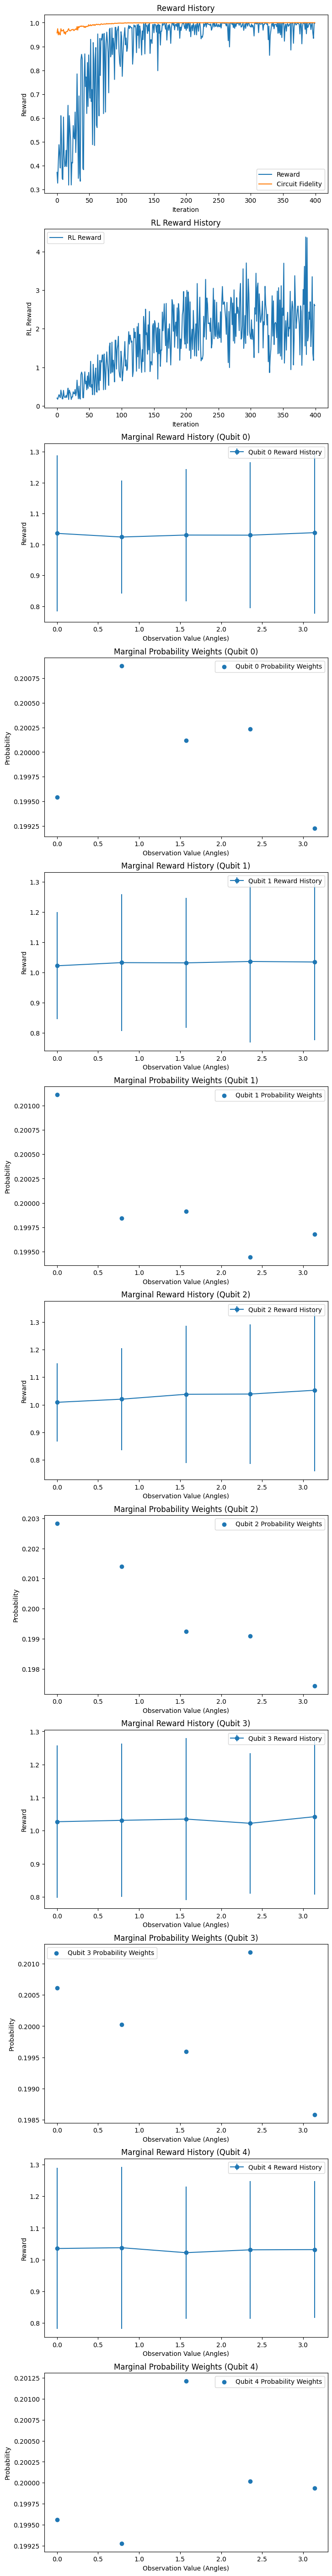

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1751538417/Test PPO CleanRL.cleanrl_model


In [39]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [40]:
NUM_EVAL = 25
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [2.35619449 1.57079633 0.78539816 0.         2.35619449 0.        ]
Environment Observation: [ 0.5  0.  -0.5  0.5 -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999229774941909
Reward (avg): 0.994422224678015 Std: 0.0004993701625720129
obs: [ 0.5  0.  -0.5  0.5 -1. ]
reward: [2.23839511 2.28266905 2.24252218 2.25088854 2.2441317  2.26800513
 2.35213876 2.22638591 2.22440471 2.2840116  2.27545176 2.25740304
 2.24889753 2.26240852 2.23559816 2.2283954  2.27222888 2.24215862
 2.31314923 2.28400951 2.23089486 2.26418684 2.20689734 2.19155464
 2.22218598 2.30475752 2.21227033 2.16957881 2.34241131 2.22638735
 2.2977281  2.26795352]
Sampled angles:  [3.14159265 1.57079633 0.78539816 0.         1.57079633 0.        ]
Environment Observation: [ 1.   0.  -0.5  0.  -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998611255344334
Reward (avg): 0.9879424785429578 Std: 0.0006121248902074411
obs: [ 1.   0.  -0.5  0.  -1. ]
reward: [1.87845564 1.92911278 1.92037794 1.90378591 1.92291567 1.9326499
 1.92793372 1.91584    1.91352313 1.9374164  1.8851751  1.93194282
 1.86644509 1.915659   1.90610061 1.89990427 1.92701521 1.94247462
 1.91878917 1.96054808 1.92144332 1.91327052 1.92715892 1.87899557
 1.90302774 1.91268221 1.92267993 1.93098616 1.93519095 1.97102231
 1.94350485 1.92143906]
Sampled angles:  [0.         1.57079633 0.78539816 0.         0.78539816 3.14159265]
Environment Observation: [-1.   0.  -0.5 -0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999756918653977
Reward (avg): 0.9778009609241256 Std: 0.0012035237476657288
obs: [-1.   0.  -0.5 -0.5  1. ]
reward: [1.64791412 1.63324335 1.62501583 1.65385711 1.65080903 1.63982408
 1.62038862 1.69083874 1.6508133  1.64691218 1.63634317 1.66336716
 1.63164076 1.7209061  1.63212524 1.64064274 1.65579003 1.69174659
 1.68464941 1.67456477 1.66307709 1.63484759 1.65496026 1.65919181
 1.62060031 1.64921213 1.67688327 1.62759087 1.64605801 1.66582547
 1.64380564 1.70495233]
Sampled angles:  [1.57079633 0.         0.         0.         3.14159265 3.14159265]
Environment Observation: [ 0. -1. -1.  1.  1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999752667646076
Reward (avg): 0.9766411429710584 Std: 0.0022921150403991046
obs: [ 0. -1. -1.  1.  1.]
reward: [1.58018122 1.66374672 1.60023053 1.69637965 1.59130575 1.6324246
 1.64397497 1.69020124 1.70239077 1.61019381 1.56729884 1.63978243
 1.61567852 1.68154759 1.57971241 1.71700225 1.64619155 1.55067056
 1.64994051 1.66051244 1.60234414 1.6377167  1.63392721 1.60940472
 1.62797272 1.60744901 1.65611195 1.6566309  1.64243014 1.65079903
 1.54944093 1.6821624 ]
Sampled angles:  [2.35619449 1.57079633 2.35619449 0.         0.         2.35619449]
Environment Observation: [ 0.5  0.   0.5 -1.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999020071963942
Reward (avg): 0.9927698577075041 Std: 0.00040680463919437395
obs: [ 0.5  0.   0.5 -1.   0.5]
reward: [2.15643225 2.15013628 2.08934901 2.09901475 2.10701863 2.08990994
 2.16411764 2.2018287  2.15479735 2.1562672  2.15831721 2.1344501
 2.1442767  2.13963021 2.15373103 2.13633982 2.15612594 2.14754614
 2.16232352 2.15516875 2.14416041 2.13385526 2.12466799 2.12809385
 2.12970623 2.13532088 2.16563562 2.15865945 2.11603115 2.17707693
 2.14379397 2.11526733]
Sampled angles:  [2.35619449 3.14159265 0.78539816 0.         1.57079633 2.35619449]
Environment Observation: [ 0.5  1.  -0.5  0.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999658555296931
Reward (avg): 0.9994914410635505 Std: 0.0002460749694397472
obs: [ 0.5  1.  -0.5  0.   0.5]
reward: [3.33638679 3.47616496 2.87833958 3.43853264 3.25040903 3.11690291
 3.46169049 3.39536984 4.00792492 3.33575731 3.39406883 3.2376141
 3.22667411 3.37675835 3.24754785 3.16150572 3.11785793 3.6518227
 3.6696768  3.36726175 3.39877921 3.14076371 3.65257847 3.01501497
 3.24716811 3.03006308 3.51109121 3.5339189  3.26976156 3.4067309
 3.30990101 3.34783532]
Sampled angles:  [0.         2.35619449 0.         0.         0.78539816 2.35619449]
Environment Observation: [-1.   0.5 -1.  -0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996864209505664
Reward (avg): 0.9697309687142882 Std: 0.0007610694687054052
obs: [-1.   0.5 -1.  -0.5  0.5]
reward: [1.52383043 1.52019902 1.5196346  1.51706327 1.51434524 1.5157775
 1.52168079 1.53922177 1.49032016 1.52758298 1.51298977 1.51926737
 1.50782851 1.52129227 1.4925208  1.51829292 1.51037465 1.50705994
 1.53260961 1.51564876 1.52205831 1.53817344 1.51202877 1.52365048
 1.52793155 1.51731955 1.52448724 1.5328358  1.52257127 1.5066567
 1.52865138 1.52848706]
Sampled angles:  [0.78539816 2.35619449 3.14159265 0.         0.         3.14159265]
Environment Observation: [-0.5  0.5  1.  -1.   1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999503624843361
Reward (avg): 0.9998075506104069 Std: 0.00010471296805030563
obs: [-0.5  0.5  1.  -1.   1. ]
reward: [3.76563635 4.10573394 3.6962297  3.9251048  3.84582874 3.9767373
 3.66992022 4.16752756 3.91532067 3.73860379 4.01956631 3.98845737
 3.87466929 3.75160969 3.41603111 3.58969662 3.85271932 4.12051051
 3.81632317 3.25325559 3.70651957 3.48520211 3.87743687 3.68489289
 3.68730724 3.86449641 3.61115578 3.48012499 3.48825433 3.50497828
 3.85625043 3.92087228]
Sampled angles:  [2.35619449 2.35619449 2.35619449 0.         0.         2.35619449]
Environment Observation: [ 0.5  0.5  0.5 -1.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999518846498356
Reward (avg): 0.9979212642104857 Std: 0.00027252798660523024
obs: [ 0.5  0.5  0.5 -1.   0.5]
reward: [2.77686681 2.70210995 2.72275876 2.65994826 2.62712265 2.60372543
 2.70724474 2.75501359 2.66506861 2.72262716 2.54899484 2.78944854
 2.65484699 2.61754951 2.73059764 2.80879785 2.74250205 2.68693252
 2.74263294 2.61690437 2.68758785 2.6612933  2.7101712  2.7181454
 2.63427191 2.68476332 2.66136237 2.65968104 2.63871187 2.70959898
 2.63064131 2.67138513]
Sampled angles:  [3.14159265 3.14159265 3.14159265 0.         0.         0.78539816]
Environment Observation: [ 1.   1.   1.  -1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999957572139902
Reward (avg): 0.9988348249869305 Std: 0.00018099297424777324
obs: [ 1.   1.   1.  -1.  -0.5]
reward: [3.01745836 2.89416648 2.82819964 3.02928487 3.03843315 2.92100761
 3.05992469 3.04987405 2.93373966 3.05427747 2.85095061 2.93498862
 2.87903738 2.87222291 2.85190683 2.89232751 2.93226246 2.86953879
 2.91898342 2.9019052  2.80924763 2.91647792 2.96130981 2.95699269
 3.00272467 3.01028271 2.98166542 2.90666238 2.95773269 2.86925098
 2.96968188 2.97273099]
Sampled angles:  [0.78539816 1.57079633 0.78539816 0.         0.78539816 1.57079633]
Environment Observation: [-0.5  0.  -0.5 -0.5  0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.99972296624906
Reward (avg): 0.9741299685544174 Std: 0.0011315872808365156
obs: [-0.5  0.  -0.5 -0.5  0. ]
reward: [1.58933179 1.60089742 1.58989724 1.59209104 1.58565951 1.58521011
 1.62217927 1.54975466 1.61378469 1.59217758 1.60620187 1.62352553
 1.57884992 1.60589283 1.57674726 1.5821203  1.58464351 1.55179682
 1.59113001 1.57601138 1.62052581 1.56019657 1.56966736 1.57672738
 1.56528767 1.61121274 1.60464186 1.5776713  1.59749687 1.57456805
 1.56881052 1.57911648]
Sampled angles:  [2.35619449 1.57079633 0.78539816 0.         3.14159265 0.78539816]
Environment Observation: [ 0.5  0.  -0.5  1.  -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999413299575826
Reward (avg): 0.9988164193127457 Std: 0.0002562246033686374
obs: [ 0.5  0.  -0.5  1.  -0.5]
reward: [2.9165414  2.90979049 2.80725624 2.90700016 2.9272433  3.16272406
 2.88757914 3.05742398 2.80740589 2.85398395 2.81003182 2.97643624
 2.90195766 2.91964606 2.93621761 2.91629791 2.76333751 2.82676903
 2.92954708 2.86133888 2.9223406  2.87655296 2.86884064 3.03148774
 2.99780956 3.00711274 3.1552787  2.88305139 3.0465432  3.12031816
 2.93576252 3.0881318 ]
Sampled angles:  [3.14159265 1.57079633 0.         0.         2.35619449 3.14159265]
Environment Observation: [ 1.   0.  -1.   0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998808347037345
Reward (avg): 0.9890213949713889 Std: 0.002175204498302853
obs: [ 1.   0.  -1.   0.5  1. ]
reward: [2.01211115 1.94307512 1.97729985 1.92899486 1.90876923 1.98372559
 1.85194159 1.97337859 1.72245889 1.99680039 1.94722502 2.06795865
 2.07932141 1.9296971  2.10241231 1.84793373 1.96652117 1.97691354
 1.99348491 1.8489678  2.12462859 1.90090665 2.02029853 1.94774923
 1.9232553  1.98453919 1.93279743 1.99801184 1.95862052 2.01850046
 2.05211406 2.02666617]
Sampled angles:  [2.35619449 0.         0.78539816 0.         2.35619449 0.        ]
Environment Observation: [ 0.5 -1.  -0.5  0.5 -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997379841276441
Reward (avg): 0.9764547359067176 Std: 0.0009102918716611105
obs: [ 0.5 -1.  -0.5  0.5 -1. ]
reward: [1.62019032 1.62494548 1.65645616 1.62088968 1.62038552 1.63336168
 1.61227298 1.63339065 1.63835162 1.60346252 1.58995766 1.64769638
 1.62040966 1.63216923 1.64386183 1.6114687  1.63111202 1.60629458
 1.64560576 1.63898587 1.61043079 1.61884836 1.66278541 1.61978849
 1.62803813 1.6351837  1.60970482 1.64484397 1.64571402 1.65211492
 1.63965069 1.6110833 ]
Sampled angles:  [1.57079633 0.         2.35619449 0.         2.35619449 3.14159265]
Environment Observation: [ 0.  -1.   0.5  0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998788904244463
Reward (avg): 0.9989449961790166 Std: 0.00025012700947908337
obs: [ 0.  -1.   0.5  0.5  1. ]
reward: [2.97849594 3.05165536 3.30704861 3.04123759 2.81318122 3.04154235
 3.08443272 2.96888696 2.99866393 3.09480989 3.10853174 3.10436654
 2.9660767  2.80600661 2.97231326 3.00531652 2.99619225 3.02848465
 2.89112962 2.84465869 2.96406357 2.93539933 2.93353045 2.97326945
 2.92778698 2.94915451 2.9828792  2.91219061 2.79936381 3.1556727
 2.89161915 3.13652082]
Sampled angles:  [3.14159265 0.78539816 1.57079633 0.         3.14159265 1.57079633]
Environment Observation: [ 1.  -0.5  0.   1.   0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999003789808798
Reward (avg): 0.9992544167377373 Std: 0.00027377534451792534
obs: [ 1.  -0.5  0.   1.   0. ]
reward: [3.16137383 3.20808183 3.14212826 3.07654373 3.45179459 3.32234779
 3.02451686 3.0374746  3.09401331 3.23591949 2.98707037 3.18725119
 3.40502289 3.32980923 3.05266197 3.06244809 3.07221722 3.29376204
 3.07359157 3.0510561  3.16931179 3.1250458  3.55505516 3.21745533
 3.37912011 2.89255513 3.21701969 2.77108344 3.09027926 3.0069645
 3.171873   3.12482174]
Sampled angles:  [3.14159265 3.14159265 0.78539816 0.         1.57079633 2.35619449]
Environment Observation: [ 1.   1.  -0.5  0.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999965639827586
Reward (avg): 0.9994880005975288 Std: 0.0004337546636285611
obs: [ 1.   1.  -0.5  0.   0.5]
reward: [3.36822784 3.60239794 3.55772271 3.64551101 3.75336563 2.80933052
 2.79676278 2.69604831 3.19184106 3.69584883 3.50589393 3.71494737
 3.55004916 3.35807624 3.13885013 3.54125092 3.36179206 3.25661048
 3.21695373 3.39722822 3.03903578 3.63290306 3.47627964 3.38779839
 3.26314649 3.24472272 3.17034609 3.55243343 3.611368   3.76636245
 3.74814563 3.63811544]
Sampled angles:  [0.         0.         0.         0.         0.78539816 2.35619449]
Environment Observation: [-1.  -1.  -1.  -0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9991485050643392
Reward (avg): 0.9184199781900759 Std: 0.0018332198789519291
obs: [-1.  -1.  -1.  -0.5  0.5]
reward: [1.08833259 1.08924988 1.08347129 1.09562829 1.0799577  1.09338992
 1.08739484 1.10723789 1.09887953 1.09952723 1.08665528 1.09146005
 1.07257506 1.07920532 1.07655702 1.07753749 1.10314383 1.08666148
 1.08089022 1.0856315  1.08770248 1.077732   1.08020926 1.09303704
 1.09153224 1.0973192  1.07350506 1.09011665 1.08541308 1.07741177
 1.10378811 1.11169702]
Sampled angles:  [2.35619449 3.14159265 0.78539816 0.         0.78539816 3.14159265]
Environment Observation: [ 0.5  1.  -0.5 -0.5  1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999512854878116
Reward (avg): 0.9973936353544035 Std: 0.00046447068680734437
obs: [ 0.5  1.  -0.5 -0.5  1. ]
reward: [2.64661718 2.6450914  2.49872792 2.67741263 2.68023631 2.64603087
 2.50696661 2.38421613 2.56425384 2.48502834 2.57459846 2.58320488
 2.57255796 2.59484623 2.6805926  2.71485502 2.64904831 2.5397292
 2.66436289 2.60960494 2.52244017 2.63920556 2.67757021 2.62973845
 2.50880751 2.53579469 2.49222826 2.53864125 2.59281983 2.62318755
 2.58043105 2.63224763]
Sampled angles:  [0.78539816 0.         0.         0.         2.35619449 2.35619449]
Environment Observation: [-0.5 -1.  -1.   0.5  0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999602671059184
Reward (avg): 0.9617875670113576 Std: 0.0015645386185722308
obs: [-0.5 -1.  -1.   0.5  0.5]
reward: [1.4168587  1.43022264 1.40912381 1.4317314  1.44862778 1.41164084
 1.41287647 1.3769683  1.43434624 1.42123876 1.39960217 1.42037165
 1.41670571 1.42476213 1.44976234 1.44209814 1.39411878 1.45001775
 1.40259663 1.40556871 1.41184216 1.41287251 1.40660468 1.38922212
 1.42777547 1.41249265 1.41720438 1.3998987  1.43915436 1.4398213
 1.40021411 1.4247515 ]
Sampled angles:  [1.57079633 2.35619449 2.35619449 0.         1.57079633 0.        ]
Environment Observation: [ 0.   0.5  0.5  0.  -1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999973476792718
Reward (avg): 0.9997973878160967 Std: 8.276251491235179e-05
obs: [ 0.   0.5  0.5  0.  -1. ]
reward: [3.79229868 3.55321615 3.7193824  3.44821271 4.11242393 3.49225162
 3.62987107 3.64118243 3.9097211  3.84435125 3.92310684 3.66937447
 4.26128131 3.60993898 3.54125691 4.26671316 3.88754591 3.65950058
 3.54051287 3.53633631 3.81015587 3.49611668 3.90757572 3.5803596
 3.76584885 3.51063412 3.53038127 3.7390628  3.68867778 4.16048502
 3.6988517  3.76307218]
Sampled angles:  [0.         0.78539816 0.         0.         0.         3.14159265]
Environment Observation: [-1.  -0.5 -1.  -1.   1. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9991543031705962
Reward (avg): 0.91902607059002 Std: 0.0015495768924992804
obs: [-1.  -0.5 -1.  -1.   1. ]
reward: [1.09740826 1.09655203 1.08476903 1.08742443 1.08414769 1.08228913
 1.07690728 1.10529861 1.10168126 1.07353182 1.08529051 1.09858338
 1.08751724 1.0881728  1.09585386 1.08866851 1.09587172 1.08105254
 1.08979216 1.09503381 1.08060445 1.09194403 1.08804515 1.08897494
 1.1101799  1.09796834 1.09047303 1.09467396 1.09447119 1.10240431
 1.09650564 1.10340597]
Sampled angles:  [2.35619449 1.57079633 0.78539816 0.         0.         2.35619449]
Environment Observation: [ 0.5  0.  -0.5 -1.   0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996576058119953
Reward (avg): 0.9677203728282644 Std: 0.0011504143763417921
obs: [ 0.5  0.  -0.5 -1.   0.5]
reward: [1.49809038 1.49081841 1.48983983 1.49488478 1.46373321 1.49255242
 1.4897712  1.51757546 1.48242679 1.48937586 1.48660424 1.46234389
 1.51854009 1.52611161 1.51433929 1.49606734 1.50378388 1.49749653
 1.47745734 1.48682548 1.49798541 1.48860613 1.49553466 1.46220321
 1.48964945 1.49330176 1.4818206  1.461823   1.48693724 1.49149785
 1.51004333 1.48506849]
Sampled angles:  [2.35619449 2.35619449 1.57079633 0.         2.35619449 0.78539816]
Environment Observation: [ 0.5  0.5  0.   0.5 -0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999514780817071
Reward (avg): 0.9993540739732483 Std: 0.00013369079408095318
obs: [ 0.5  0.5  0.   0.5 -0.5]
reward: [3.26674596 3.22058193 3.11883961 3.16536875 3.17756455 3.14376397
 3.12258953 3.26267296 3.26644447 3.27259737 3.30320336 3.1575555
 3.01617068 3.36715207 3.27077    3.2529764  3.09240385 3.28167247
 3.11001909 3.04801894 3.23241386 3.1490171  3.18221183 3.26805634
 3.23157991 3.05280217 3.08125983 3.21545854 3.40107602 3.22019741
 3.22241898 3.19352567]
Sampled angles:  [3.14159265 2.35619449 1.57079633 0.         2.35619449 1.57079633]
Environment Observation: [1.  0.5 0.  0.5 0. ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999217176712545
Reward (avg): 0.9982399344075314 Std: 0.00025503135953784363
obs: [1.  0.5 0.  0.5 0. ]
reward: [2.7188737  2.87686593 2.80356889 2.76392497 2.64854843 2.82879014
 2.8292253  2.66173566 2.71478201 2.82478892 2.78934526 2.7593108
 2.77066524 2.78459865 2.85420366 2.71652001 2.80680892 2.8368392
 2.66604989 2.71484513 2.63473041 2.79490793 2.75959415 2.75645107
 2.78390801 2.76599285 2.72322053 2.67051191 2.72771336 2.6943319
 2.8109038  2.7927843 ]


In [53]:
print(ppo_agent.env.unwrapped.discrete_reward_history)

[[0.86257813 1.         1.         ... 1.         1.         1.        ]
 [0.69874336 1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [54]:
arr = ppo_agent.env.unwrapped.discrete_reward_history

inds = np.where(arr != 1.)
inds

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [56]:
print(len(inds[0]))

425


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_93315/730542476.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


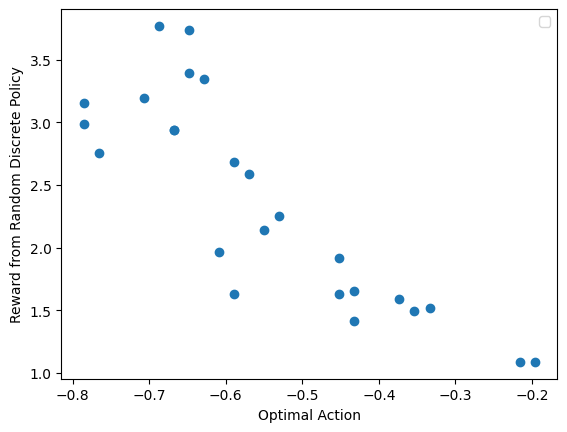

In [41]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.2

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [42]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 3125)


In [43]:
print(df_hist)

[[0.86257813 1.         1.         ... 1.         1.         1.        ]
 [0.69874336 1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


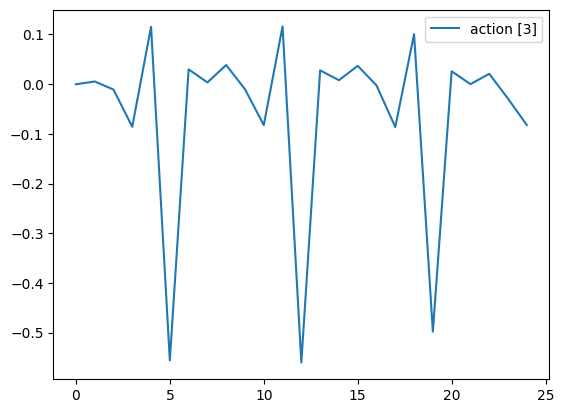

In [44]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

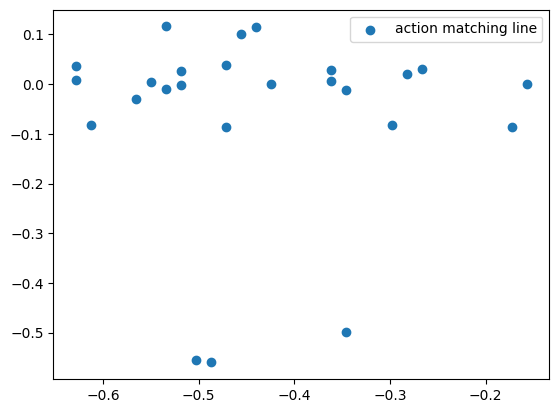

In [45]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [47]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=4,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 4, 5],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [48]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.2
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [49]:
o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles

In [50]:
ana_sum = -np.sum(o_vals, axis=1) * 0.025
ana_sum

array([-0.        , -0.01963495, -0.03926991, ..., -0.35342917,
       -0.37306413, -0.39269908])

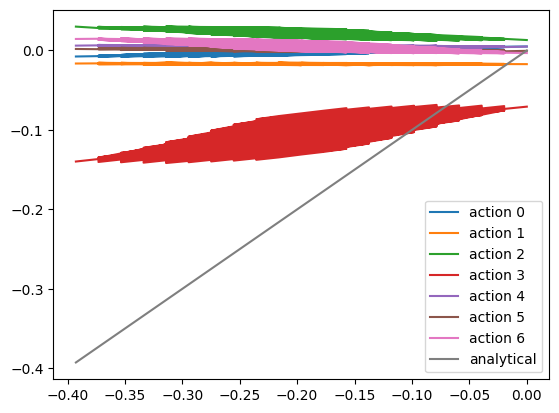

In [51]:
actions = np.array(actions)

for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

## Running Training with Scaleable Algo

In [32]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
import collections

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(fidelity_range, env.fidelity_history, label="Circuit Fidelity")
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(-np.log10(1. - np.mean(env.reward_history, axis=1)), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            ax[2 + qubit_idx * 2].errorbar(
                angles, marginal_rewards, yerr=marginal_std, fmt='-o', label=f"Qubit {qubit_idx} Reward History"
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            ax[3 + qubit_idx * 2].scatter(
                angles, marginal_probs, label=f"Qubit {qubit_idx} Probability Weights"
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(self, env, use_combined_networks, activation_function_str, layer_size, robust_ppo):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_mean = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn()
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

class PPO_ContextBuffer:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        # --- NEW: Hyperparameters Tuned for Shorter Training Runs ---
        num_warmup_updates: int = 20,
        context_buffer_size: int = 500,
        sampling_prob: float = 0.3,
        eviction_strategy: str = 'hybrid', # 'fifo' or 'hybrid'
        evict_best_prob: float = 0.2, # Probability of evicting highest-reward sample
        anneal_noise: bool = True,
        initial_noise_scale: float = 0.15,
        final_noise_scale: float = 0.05,
    ):
        self.agent_config = agent_config
        self.exp_name = agent_config["exp_name"]
        self.seed = agent_config["seed"]
        self.torch_deterministic = agent_config["torch_deterministic"]
        self.cuda = agent_config["cuda"]
        self.track = agent_config["track"]
        self.wandb_project_name = agent_config["wandb_project_name"]
        self.wandb_entity = agent_config["wandb_entity"]
        self.save_model = agent_config["save_model"]
        self.plot_real_time = agent_config["plot_real_time"]
        self.num_prints = agent_config["num_prints"]

        self.num_updates = agent_config["total_updates"]
        self.learning_rate = agent_config["learning_rate"]
        self.num_envs = agent_config["num_envs"]
        self.num_steps = agent_config["num_steps"]
        self.anneal_lr = agent_config["anneal_lr"]
        self.anneal_num_updates = agent_config["anneal_num_updates"]
        self.exp_anneal_lr = agent_config["exp_anneal_lr"]
        self.exp_update_time = agent_config["exp_update_time"]
        self.plateau_lr = agent_config["plateau_lr"]
        self.gamma = agent_config["gamma"]
        self.gae_lambda = agent_config["gae_lambda"]
        self.num_minibatches = agent_config["num_minibatches"]
        self.update_epochs = agent_config["update_epochs"]
        self.norm_adv = agent_config["norm_adv"]
        self.activation_function_str = agent_config["activation_function_str"]
        self.use_combined_networks = agent_config["use_combined_networks"]
        self.layer_size = agent_config["layer_size"]
        self.clip_coef = agent_config["clip_coef"]
        self.clip_vloss = agent_config["clip_vloss"]
        self.ent_coef = agent_config["ent_coef"]
        self.vf_coef = agent_config["vf_coef"]
        self.max_grad_norm = agent_config["max_grad_norm"]
        self.target_kl = agent_config["target_kl"]
        self.robust_ppo = agent_config["robust_ppo"]

        # --- UPDATED: Attributes for Fast Rank-Based Curriculum ---
        self.num_warmup_updates = num_warmup_updates
        self.context_buffer_size = context_buffer_size
        self.SAMPLING_PROB = sampling_prob
        self.eviction_strategy = eviction_strategy
        self.evict_best_prob = evict_best_prob
        self.anneal_noise = anneal_noise
        self.initial_noise_scale = initial_noise_scale
        self.final_noise_scale = final_noise_scale

        # Using standard lists to allow for custom eviction logic
        self.context_buffer = []
        self.context_rewards = []
        self.mean_action_buffer = []

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert self.anneal_lr + self.exp_anneal_lr, "Learning Rate Combination doesn't work"

        self.run_name = f"PPO_ContextBuffer__{self.exp_name}__{self.seed}__{int(time.time())}"

        if self.track:
            import wandb
            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s" % (
                "\n".join([f"|{key}|{value}|" for key, value in self.agent_config.items()])
            )
        )

        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        self.env = env

        self.agent = Agent(
            self.env, self.use_combined_networks, self.activation_function_str,
            self.layer_size, self.robust_ppo
        ).to(self.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.learning_rate, eps=1e-5)

    def add_to_context_buffer(self, context: np.ndarray, reward: float, mean_action: np.ndarray):
        """
        Adds context, reward, and action to buffers.
        Applies a hybrid eviction strategy if the buffer is full.
        """
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        self.mean_action_buffer.append(mean_action)

        # Eviction logic for when buffer exceeds its maximum size
        if len(self.context_buffer) > self.context_buffer_size:
            if self.eviction_strategy == 'hybrid' and np.random.random() < self.evict_best_prob:
                # Evict the sample with the highest reward (easiest success)
                idx_to_remove = np.argmax(self.context_rewards)
            else:
                # Evict the oldest sample (FIFO)
                idx_to_remove = 0
            
            self.context_buffer.pop(idx_to_remove)
            self.context_rewards.pop(idx_to_remove)
            self.mean_action_buffer.pop(idx_to_remove)
    
    def sample_context(self, update_step: int) -> np.ndarray:
        """
        Samples context using rank-based prioritized replay, tailored for short runs.
        """
        is_warmup = update_step <= self.num_warmup_updates
        
        if is_warmup or len(self.context_buffer) == 0:
            # self.sampling_sources.append("random_warmup")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )

        if np.random.random() < self.SAMPLING_PROB:
            # --- Rank-Based Prioritized Point Replay ---
            rewards = np.array(self.context_rewards)
            # Lower reward gets lower rank (e.g., rank 1 is the hardest)
            ranks = np.argsort(np.argsort(rewards)) + 1
            # Probability is inversely proportional to rank
            prob_weights = 1.0 / ranks
            prob_weights /= np.sum(prob_weights) # Normalize

            idx = np.random.choice(len(self.context_buffer), p=prob_weights)
            context = self.context_buffer[idx]
            
            # --- Optional: Anneal noise scale over the training run ---
            if self.anneal_noise:
                progress = (update_step - self.num_warmup_updates) / (self.num_updates - self.num_warmup_updates)
                progress = np.clip(progress, 0.0, 1.0)
                current_noise_scale = self.initial_noise_scale * (1 - progress) + self.final_noise_scale * progress
            else:
                current_noise_scale = self.initial_noise_scale

            noise = np.random.normal(0, current_noise_scale, context.shape)
            noisy_context = context + noise
            
            # self.noise_magnitudes.append(np.linalg.norm(noise))
            # self.sampling_sources.append("buffer_ranked")
            return np.clip(
                noisy_context,
                self.env.observation_space.low,
                self.env.observation_space.high
            )
        else:
            # self.sampling_sources.append("random_explore")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )

    def plot_buffer_reward_distribution(self, filename="buffer_reward_distribution.png"):
        """Plot histogram of rewards in the buffer."""
        # This function is relevant again for point-based replay
        if not self.context_rewards:
            print("No rewards in buffer to plot.")
            return
        plt.figure(figsize=(10, 6))
        plt.hist(self.context_rewards, bins=30, density=True, alpha=0.7, label="Buffer Rewards")
        plt.xlabel("Reward")
        plt.ylabel("Density")
        plt.title("Distribution of Rewards in Context Buffer")
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f"Buffer reward stats - Mean: {np.mean(self.context_rewards):.3f}, Std: {np.std(self.context_rewards):.3f}")
    
    def plot_policy_behaviour(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="policy_behaviour.png"
    ):
        """
        Plots the agent's reward against the optimal action required to
        counteract spillover noise.

        A robust agent should show a flat reward profile, while a naive
        agent's reward will decrease as the optimal action magnitude increases.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot policy behaviour.")
        #     return

        # 1. Convert buffers to numpy arrays for calculation
        obs_arr = np.array(self.context_buffer)
        rewards_arr = np.array(self.context_rewards)

        # 2. Calculate the optimal action based on the provided formula
        # Assumes the dimensions of obs_arr correspond to the spillover_qubits
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        
        # Calculate the total spillover angle for each context in the buffer
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        
        # The optimal action is the one that perfectly cancels this spillover
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)
        
        # Scatter plot of raw data points
        plt.scatter(optimal_action, rewards_arr, alpha=0.1, label='Raw Data Points', color='royalblue')

        # Calculate and plot a binned average to show the trend clearly
        try:
            bins = np.linspace(optimal_action.min(), optimal_action.max(), 15)
            bin_indices = np.digitize(optimal_action, bins)
            binned_rewards_mean = [rewards_arr[bin_indices == i].mean() for i in range(1, len(bins))]
            binned_rewards_std = [rewards_arr[bin_indices == i].std() for i in range(1, len(bins))]
            bin_centers = (bins[:-1] + bins[1:]) / 2

            plt.errorbar(
                bin_centers,
                binned_rewards_mean,
                yerr=binned_rewards_std,
                fmt='-o',
                color='red',
                markersize=8,
                capsize=5,
                linewidth=2.5,
                label='Binned Average Reward'
            )
        except Exception as e:
            print(f"Could not compute binned average for policy behaviour plot: {e}")

        plt.title("Agent Reward vs. Optimal Corrective Action")
        plt.xlabel("Optimal Action Magnitude (to counteract spillover)")
        plt.ylabel("Achieved Reward")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()

    def plot_action_comparison(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="action_comparison.png"
    ):
        """
        Plots the agent's actual output action against the analytically
        calculated optimal action.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot action comparison.")
        #     return

        # 1. Get data from buffers
        obs_arr = np.array(self.context_buffer)
        agent_actions = np.array(self.mean_action_buffer)

        # 2. Calculate the optimal action for each observation
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)

        # Plot each dimension of the agent's action
        for i in range(agent_actions.shape[1]):
            if i == 3:
                plt.scatter(
                    optimal_action, 
                    agent_actions[:, i], 
                    alpha=0.2, 
                    label=f'Agent Action Dim {i}'
                )

        # Plot the "perfect" policy line for reference
        plt.plot(
            optimal_action, 
            optimal_action, 
            'r--', 
            linewidth=2.5, 
            label='Analytical Optimal (y=x)'
        )

        plt.title("Agent's Learned Action vs. Optimal Action")
        plt.xlabel("Optimal Corrective Action (Calculated)")
        plt.ylabel("Actual Action (From Agent Policy)")
        plt.legend()
        plt.grid(True, which='both', linestyle='--')
        # plt.axis('equal') # Ensures the y=x line is at a 45-degree angle
        plt.show()
    
    def run_training(self):
        self.obs = torch.zeros((self.num_steps, self.num_envs) + self.env.observation_space.shape).to(self.device)
        self.actions = torch.zeros((self.num_steps, self.num_envs) + self.env.action_space.shape).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            context = self.sample_context(update_step=update)
            angles = self.env.unwrapped.obs_raw_to_angles(context)
            next_obs, _ = self.env.unwrapped.reset(debug_obs=angles)

            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = self.learning_rate * np.exp(-update / self.exp_update_time) + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(next_obs)
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                cpu_action = action.cpu().numpy()
                # The mean action over the parallel environments for this step
                mean_action_for_step = np.mean(cpu_action, axis=0) 
                try:
                    self.env.unwrapped.mean_action = self.env.action(mean_action_for_step)
                except AttributeError:
                    self.env.unwrapped.mean_action = mean_action_for_step

                next_obs, reward, terminations, truncations, infos = self.env.step(cpu_action)

                mean_reward = np.mean(reward)
                # UPDATED: Pass the mean action to the buffer
                self.add_to_context_buffer(context, mean_reward, mean_action_for_step) 

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    # context = self.sample_context(warmup=is_warmup)
                    # self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                            self.writer.add_scalar("charts/episodic_return", info['episode']['r'], global_step)
                            self.writer.add_scalar("charts/episodic_length", info['episode']['l'], global_step)

            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = self.rewards[t] + self.gamma * nextvalues * nextnonterminal - self.values[t]
                    advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + self.values

            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(newvalue - b_values[mb_inds], -self.clip_coef, self.clip_coef)
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar("losses/explained_variance", explained_var, global_step)
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)
                    self.plot_buffer_reward_distribution()
                    gamma_matrix = self.env.unwrapped.gamma_matrix # Assuming gamma is in your env
                    self.plot_policy_behaviour(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[0, 1, 2, 3, 4, 5], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.3         # As per your example
                    )
                    self.plot_action_comparison(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[0, 1, 2, 3, 4, 5], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.3         # As per your example
                    )

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [ ]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
import collections

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(fidelity_range, env.fidelity_history, label="Circuit Fidelity")
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(-np.log10(1. - np.mean(env.reward_history, axis=1)), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            ax[2 + qubit_idx * 2].errorbar(
                angles, marginal_rewards, yerr=marginal_std, fmt='-o', label=f"Qubit {qubit_idx} Reward History"
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            ax[3 + qubit_idx * 2].scatter(
                angles, marginal_probs, label=f"Qubit {qubit_idx} Probability Weights"
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(self, env, use_combined_networks, activation_function_str, layer_size, robust_ppo):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_mean = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn()
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01)
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0)
            )
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(env.action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

class PPO_ContextBuffer:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        # --- NEW: Hyperparameters Tuned for Shorter Training Runs ---
        num_warmup_updates: int = 20,
        context_buffer_size: int = 500,
        sampling_prob: float = 0.3,
        eviction_strategy: str = 'hybrid', # 'fifo' or 'hybrid'
        evict_best_prob: float = 0.2, # Probability of evicting highest-reward sample
        anneal_noise: bool = True,
        initial_noise_scale: float = 0.15,
        final_noise_scale: float = 0.05,
        explore_edge_prob: float = 0.5, # Prob. of sampling edges during random exploration
    ):
        self.agent_config = agent_config
        self.exp_name = agent_config["exp_name"]
        self.seed = agent_config["seed"]
        self.torch_deterministic = agent_config["torch_deterministic"]
        self.cuda = agent_config["cuda"]
        self.track = agent_config["track"]
        self.wandb_project_name = agent_config["wandb_project_name"]
        self.wandb_entity = agent_config["wandb_entity"]
        self.save_model = agent_config["save_model"]
        self.plot_real_time = agent_config["plot_real_time"]
        self.num_prints = agent_config["num_prints"]

        self.num_updates = agent_config["total_updates"]
        self.learning_rate = agent_config["learning_rate"]
        self.num_envs = agent_config["num_envs"]
        self.num_steps = agent_config["num_steps"]
        self.anneal_lr = agent_config["anneal_lr"]
        self.anneal_num_updates = agent_config["anneal_num_updates"]
        self.exp_anneal_lr = agent_config["exp_anneal_lr"]
        self.exp_update_time = agent_config["exp_update_time"]
        self.plateau_lr = agent_config["plateau_lr"]
        self.gamma = agent_config["gamma"]
        self.gae_lambda = agent_config["gae_lambda"]
        self.num_minibatches = agent_config["num_minibatches"]
        self.update_epochs = agent_config["update_epochs"]
        self.norm_adv = agent_config["norm_adv"]
        self.activation_function_str = agent_config["activation_function_str"]
        self.use_combined_networks = agent_config["use_combined_networks"]
        self.layer_size = agent_config["layer_size"]
        self.clip_coef = agent_config["clip_coef"]
        self.clip_vloss = agent_config["clip_vloss"]
        self.ent_coef = agent_config["ent_coef"]
        self.vf_coef = agent_config["vf_coef"]
        self.max_grad_norm = agent_config["max_grad_norm"]
        self.target_kl = agent_config["target_kl"]
        self.robust_ppo = agent_config["robust_ppo"]

        # --- UPDATED: Attributes for Fast Rank-Based Curriculum ---
        self.num_warmup_updates = num_warmup_updates
        self.context_buffer_size = context_buffer_size
        self.SAMPLING_PROB = sampling_prob
        self.eviction_strategy = eviction_strategy
        self.evict_best_prob = evict_best_prob
        self.anneal_noise = anneal_noise
        self.initial_noise_scale = initial_noise_scale
        self.final_noise_scale = final_noise_scale
        self.explore_edge_prob = explore_edge_prob # NEW

        # Using standard lists to allow for custom eviction logic
        self.context_buffer = []
        self.context_rewards = []
        self.mean_action_buffer = []

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert self.anneal_lr + self.exp_anneal_lr, "Learning Rate Combination doesn't work"

        self.run_name = f"PPO_ContextBuffer__{self.exp_name}__{self.seed}__{int(time.time())}"

        if self.track:
            import wandb
            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s" % (
                "\n".join([f"|{key}|{value}|" for key, value in self.agent_config.items()])
            )
        )

        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")
        self.env = env

        self.agent = Agent(
            self.env, self.use_combined_networks, self.activation_function_str,
            self.layer_size, self.robust_ppo
        ).to(self.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.learning_rate, eps=1e-5)

    def add_to_context_buffer(self, context: np.ndarray, reward: float, mean_action: np.ndarray):
        """
        Adds context, reward, and action to buffers.
        Applies a hybrid eviction strategy if the buffer is full.
        """
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        self.mean_action_buffer.append(mean_action)

        # Eviction logic for when buffer exceeds its maximum size
        if len(self.context_buffer) > self.context_buffer_size:
            if self.eviction_strategy == 'hybrid' and np.random.random() < self.evict_best_prob:
                # Evict the sample with the highest reward (easiest success)
                idx_to_remove = np.argmax(self.context_rewards)
            else:
                # Evict the oldest sample (FIFO)
                idx_to_remove = 0
            
            self.context_buffer.pop(idx_to_remove)
            self.context_rewards.pop(idx_to_remove)
            self.mean_action_buffer.pop(idx_to_remove)

    def _generate_boundary_sample(self) -> np.ndarray:
        """
        Generates a sample with one or more dimensions at the boundary
        of the observation space to ensure exploration of edges and corners.
        """
        space = self.env.observation_space
        d = space.shape[0]
        
        # Create a sample initialized with uniform values
        context = np.random.uniform(space.low, space.high, size=space.shape)
        
        # Decide how many dimensions to push to the boundary (at least one)
        k_boundaries = np.random.randint(1, d + 1)
        
        # Randomly choose which dimensions to push
        boundary_indices = np.random.choice(d, k_boundaries, replace=False)
        
        # For each chosen dimension, randomly set it to the min or max value
        boundary_values = np.random.choice([space.low[0], space.high[0]], size=k_boundaries)
        context[boundary_indices] = boundary_values
        
        return context
    
    def sample_context(self, update_step: int) -> np.ndarray:
        """
        Samples context using rank-based prioritized replay and a mixed
        exploration strategy that targets the boundaries of the context space.
        """
        is_warmup = update_step <= self.num_warmup_updates
        
        if is_warmup or len(self.context_buffer) == 0:
            # self.sampling_sources.append("random_warmup")
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape
            )

        if np.random.random() < self.SAMPLING_PROB:
            # --- Rank-Based Prioritized Point Replay ---
            # ... (This part remains unchanged) ...
            # self.sampling_sources.append("buffer_ranked")
            # ... (returning a noisy context from buffer)
            rewards = np.array(self.context_rewards)
            ranks = np.argsort(np.argsort(rewards)) + 1
            prob_weights = 1.0 / ranks
            prob_weights /= np.sum(prob_weights)
            idx = np.random.choice(len(self.context_buffer), p=prob_weights)
            context = self.context_buffer[idx]
            if self.anneal_noise:
                progress = (update_step - self.num_warmup_updates) / (self.num_updates - self.num_warmup_updates)
                progress = np.clip(progress, 0.0, 1.0)
                current_noise_scale = self.initial_noise_scale * (1 - progress) + self.final_noise_scale * progress
            else:
                current_noise_scale = self.initial_noise_scale
            noise = np.random.normal(0, current_noise_scale, context.shape)
            return np.clip(context + noise, self.env.observation_space.low, self.env.observation_space.high)
        else:
            # --- MODIFIED: Mixed Random Exploration Strategy ---
            if np.random.random() < self.explore_edge_prob:
                # self.sampling_sources.append("random_edge")
                return self._generate_boundary_sample()
            else:
                # self.sampling_sources.append("random_uniform")
                return np.random.uniform(
                    self.env.observation_space.low,
                    self.env.observation_space.high,
                    self.env.observation_space.shape
                )

    def plot_buffer_reward_distribution(self, filename="buffer_reward_distribution.png"):
        """Plot histogram of rewards in the buffer."""
        # This function is relevant again for point-based replay
        if not self.context_rewards:
            print("No rewards in buffer to plot.")
            return
        plt.figure(figsize=(10, 6))
        plt.hist(self.context_rewards, bins=30, density=True, alpha=0.7, label="Buffer Rewards")
        plt.xlabel("Reward")
        plt.ylabel("Density")
        plt.title("Distribution of Rewards in Context Buffer")
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f"Buffer reward stats - Mean: {np.mean(self.context_rewards):.3f}, Std: {np.std(self.context_rewards):.3f}")
    
    def plot_policy_behaviour(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="policy_behaviour.png"
    ):
        """
        Plots the agent's reward against the optimal action required to
        counteract spillover noise.

        A robust agent should show a flat reward profile, while a naive
        agent's reward will decrease as the optimal action magnitude increases.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot policy behaviour.")
        #     return

        # 1. Convert buffers to numpy arrays for calculation
        obs_arr = np.array(self.context_buffer)
        rewards_arr = np.array(self.context_rewards)

        # 2. Calculate the optimal action based on the provided formula
        # Assumes the dimensions of obs_arr correspond to the spillover_qubits
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        
        # Calculate the total spillover angle for each context in the buffer
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        
        # The optimal action is the one that perfectly cancels this spillover
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)
        
        # Scatter plot of raw data points
        plt.scatter(optimal_action, rewards_arr, alpha=0.1, label='Raw Data Points', color='royalblue')

        # Calculate and plot a binned average to show the trend clearly
        try:
            bins = np.linspace(optimal_action.min(), optimal_action.max(), 15)
            bin_indices = np.digitize(optimal_action, bins)
            binned_rewards_mean = [rewards_arr[bin_indices == i].mean() for i in range(1, len(bins))]
            binned_rewards_std = [rewards_arr[bin_indices == i].std() for i in range(1, len(bins))]
            bin_centers = (bins[:-1] + bins[1:]) / 2

            plt.errorbar(
                bin_centers,
                binned_rewards_mean,
                yerr=binned_rewards_std,
                fmt='-o',
                color='red',
                markersize=8,
                capsize=5,
                linewidth=2.5,
                label='Binned Average Reward'
            )
        except Exception as e:
            print(f"Could not compute binned average for policy behaviour plot: {e}")

        plt.title("Agent Reward vs. Optimal Corrective Action")
        plt.xlabel("Optimal Action Magnitude (to counteract spillover)")
        plt.ylabel("Achieved Reward")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.savefig(f"runs/{self.run_name}/{filename}")
        plt.show()

    def plot_action_comparison(
        self,
        gamma_matrix: np.ndarray,
        spillover_qubits: list,
        target_qubit: int,
        action_scale: float,
        filename="action_comparison.png"
    ):
        """
        Plots the agent's actual output action against the analytically
        calculated optimal action.
        """
        # if len(self.context_buffer) < 100:
        #     print("Not enough data in buffer to plot action comparison.")
        #     return

        # 1. Get data from buffers
        obs_arr = np.array(self.context_buffer)
        agent_actions = np.array(self.mean_action_buffer)

        # 2. Calculate the optimal action for each observation
        source_angles = 0.5 * (obs_arr + 1) * np.pi
        spillover_factors = gamma_matrix[spillover_qubits, target_qubit]
        total_spillover_angle = np.sum(source_angles * spillover_factors.reshape(1, -1), axis=-1)
        optimal_action = -total_spillover_angle / action_scale

        # 3. Create the plot
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(10, 7), dpi=100)

        # Plot each dimension of the agent's action
        for i in range(agent_actions.shape[1]):
            if i == 3:
                plt.scatter(
                    optimal_action, 
                    agent_actions[:, i], 
                    alpha=0.2, 
                    label=f'Agent Action Dim {i}'
                )

        # Plot the "perfect" policy line for reference
        plt.plot(
            optimal_action, 
            optimal_action, 
            'r--', 
            linewidth=2.5, 
            label='Analytical Optimal (y=x)'
        )

        plt.title("Agent's Learned Action vs. Optimal Action")
        plt.xlabel("Optimal Corrective Action (Calculated)")
        plt.ylabel("Actual Action (From Agent Policy)")
        plt.legend()
        plt.grid(True, which='both', linestyle='--')
        # plt.axis('equal') # Ensures the y=x line is at a 45-degree angle
        plt.show()
    
    def run_training(self):
        self.obs = torch.zeros((self.num_steps, self.num_envs) + self.env.observation_space.shape).to(self.device)
        self.actions = torch.zeros((self.num_steps, self.num_envs) + self.env.action_space.shape).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            context = self.sample_context(update_step=update)
            angles = self.env.unwrapped.obs_raw_to_angles(context)
            next_obs, _ = self.env.unwrapped.reset(debug_obs=angles)

            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = self.learning_rate * np.exp(-update / self.exp_update_time) + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(next_obs)
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                cpu_action = action.cpu().numpy()
                # The mean action over the parallel environments for this step
                mean_action_for_step = np.mean(cpu_action, axis=0) 
                try:
                    self.env.unwrapped.mean_action = self.env.action(mean_action_for_step)
                except AttributeError:
                    self.env.unwrapped.mean_action = mean_action_for_step

                next_obs, reward, terminations, truncations, infos = self.env.step(cpu_action)

                mean_reward = np.mean(reward)
                # UPDATED: Pass the mean action to the buffer
                self.add_to_context_buffer(context, mean_reward, mean_action_for_step) 

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    # context = self.sample_context(warmup=is_warmup)
                    # self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                            self.writer.add_scalar("charts/episodic_return", info['episode']['r'], global_step)
                            self.writer.add_scalar("charts/episodic_length", info['episode']['l'], global_step)

            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = self.rewards[t] + self.gamma * nextvalues * nextnonterminal - self.values[t]
                    advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + self.values

            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [((ratio - 1.0).abs() > self.clip_coef).float().mean().item()]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(newvalue - b_values[mb_inds], -self.clip_coef, self.clip_coef)
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.agent.parameters(), self.max_grad_norm)
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            self.writer.add_scalar("charts/learning_rate", self.optimizer.param_groups[0]["lr"], global_step)
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar("losses/explained_variance", explained_var, global_step)
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)
                    self.plot_buffer_reward_distribution()
                    gamma_matrix = self.env.unwrapped.gamma_matrix # Assuming gamma is in your env
                    self.plot_policy_behaviour(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[0, 1, 2, 3, 4, 5], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.3         # As per your example
                    )
                    self.plot_action_comparison(
                        gamma_matrix=gamma_matrix,
                        spillover_qubits=[0, 1, 2, 3, 4, 5], # As per your example
                        target_qubit=3,          # Example target
                        action_scale=0.3         # As per your example
                    )

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [33]:
# PPO Details

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 3, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": True,
    "wandb_project_name": "Context-Aware Training",
    "wandb_entity": "quantumcontrolwithrl",
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 1200,
    "learning_rate": 1e-3,
    "num_envs": 32, # 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1200,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 128, # 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
# ppo_agent = PPO_ClusterCurriculum(
#     agent_config, 
#     rescaled_q_env,
#     num_warmup_updates=20,
#     context_buffer_size=75,
#     noise_scale=0.1,
#     sampling_prob=0.4,
#     n_clusters=25,
#     cluster_update_freq=10,
# )

ppo_agent = PPO_ContextBuffer(
    agent_config, 
    rescaled_q_env,
    num_warmup_updates=20,
    context_buffer_size=100,
    sampling_prob=0.25,
    eviction_strategy='hybrid', # 'fifo' or 'hybrid'
    evict_best_prob=0.2, # Probability of evicting highest-reward sample
    anneal_noise=True,
    initial_noise_scale=0.15,
    final_noise_scale=0.05,
)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aniken04 (quantumcontrolwithrl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


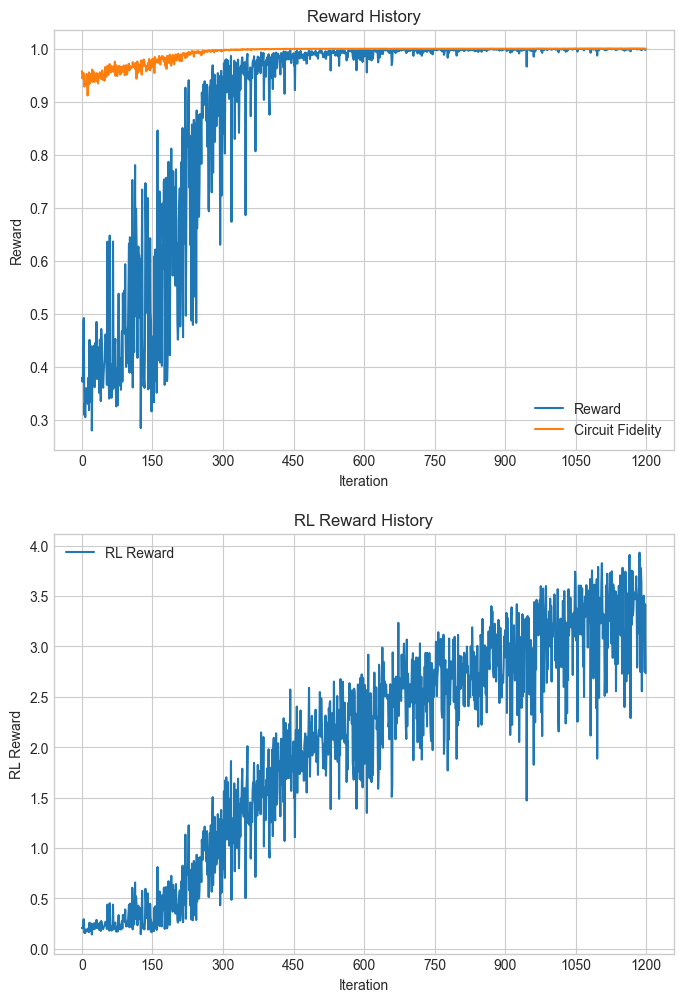

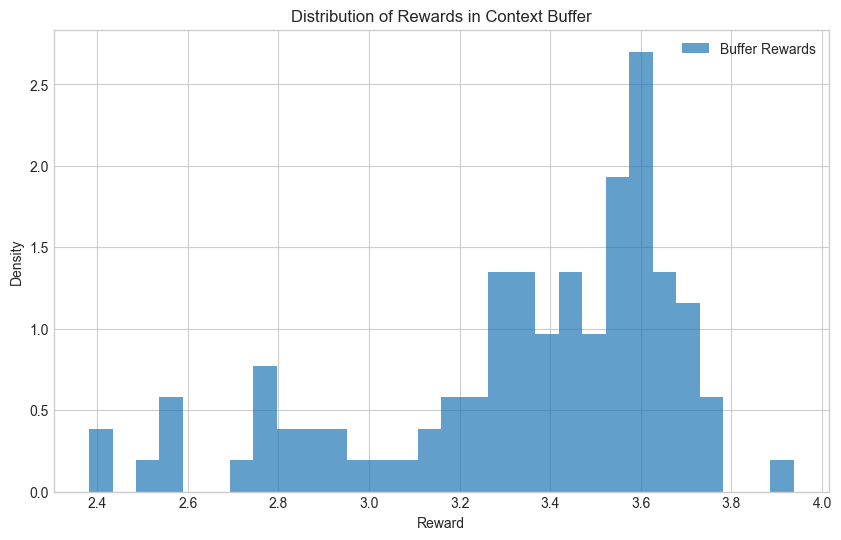

Buffer reward stats - Mean: 3.345, Std: 0.342


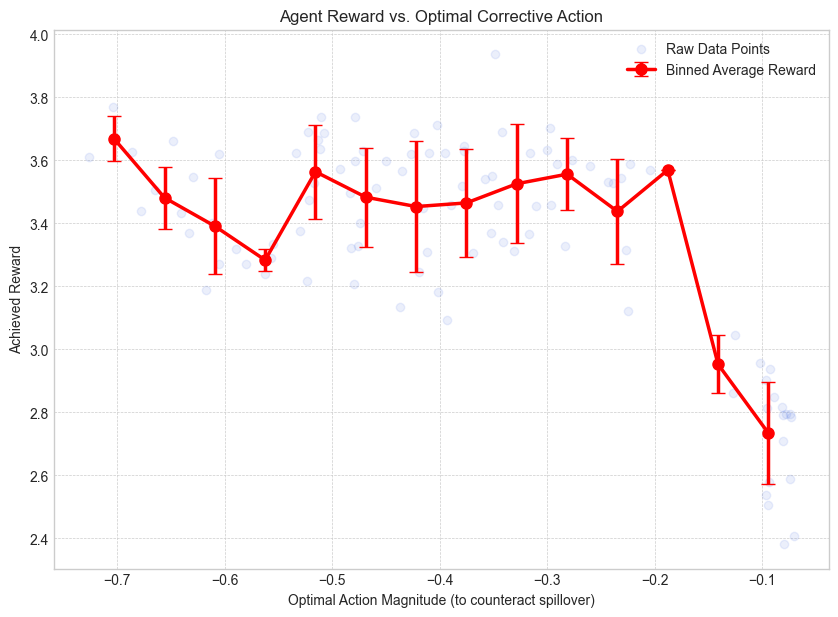

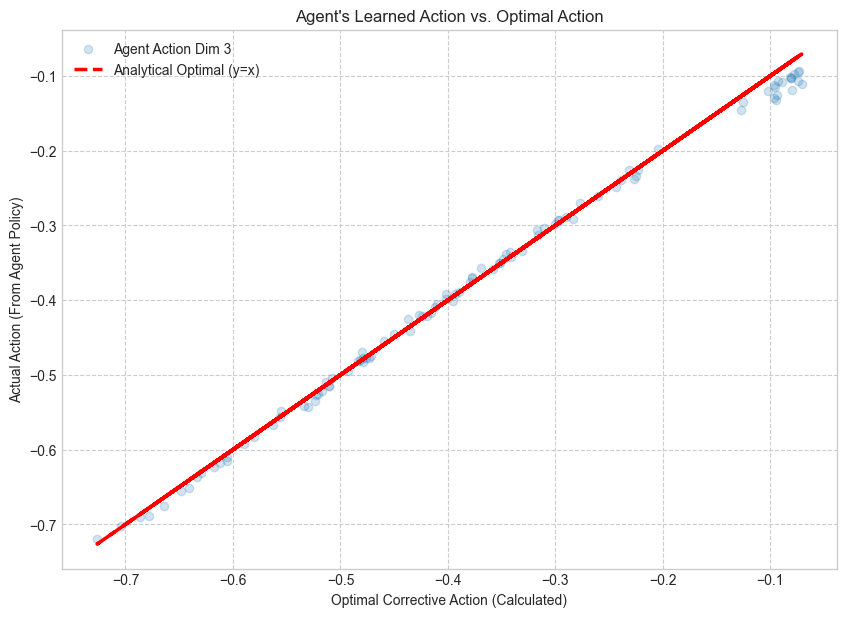

model saved to runs/PPO_ContextBuffer__Test PPO CleanRL__1__1753160176/Test PPO CleanRL.cleanrl_model


In [34]:
ppo_agent.run_training()

In [35]:
NUM_EVAL = 200
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    obs_angles = 0.5 * (obs + 1) * np.pi
    computed_angles = obs_angles * gamma_matrix[[0, 1, 2, 3, 4, 5], 3]
    spillover_angle = np.sum(computed_angles)
    action_scaled = -spillover_angle / 0.3
    print(action_scaled)
    batch_action[:,3] = action_scaled
    # print(batch_action.shape)
    # assert False
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.3543651  2.98129325 0.18048781 0.61856277 0.23295689 0.02624984]
Environment Observation: [-0.77440417  0.89795023 -0.88509789 -0.60621071 -0.85169504 -0.98328883]
-0.16123000599775572
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999820356704889
Reward (avg): 0.9996822545030619 Std: 0.0003239681033167138
obs: [-0.77440417  0.89795023 -0.88509789 -0.60621071 -0.85169504 -0.98328883]
reward: [3.46795668 3.32475916 3.94439288 3.02181267 4.23145321 3.44925078
 3.89793092 3.25087548 4.51775086 3.9866779  3.46876397 3.93169604
 3.27125858 3.25517272 3.00933785 4.36746848 4.68698153 2.99792555
 4.49965169 3.74438936 4.21869579 3.67130113 3.67100999 3.66577782
 4.06628587 3.72220269 2.97278605 3.05397866 3.81765619 4.52675307
 4.20827939 4.11095484]
Sampled angles:  [1.0758156  2.67172817 3.08590535 2.00851961 0.66409692 0.1322784 ]
Environment Observation: [-0.31511452  0.70087498  0.96454836  0.2786633  -0.57722277 -0.91578896]
-0.49084798842586347
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999817608950899
Reward (avg): 0.9998330200188363 Std: 0.00012598211448889887
obs: [-0.31511452  0.70087498  0.96454836  0.2786633  -0.57722277 -0.91578896]
reward: [3.79299751 3.82389944 4.16577159 4.16385048 3.48894339 6.
 3.69690005 4.13727631 4.58655283 4.07737691 3.73974234 3.97379719
 3.95043333 4.29430197 3.66363185 3.50658329 3.32720129 3.76961513
 3.56347725 4.45582251 3.39997797 4.14966882 4.18381982 3.87769597
 3.97216833 3.95561708 3.34363358 3.88321337 3.38901903 3.80475962
 3.78321089 4.2184911 ]
Sampled angles:  [0.5914849  1.55815132 3.02201266 1.83958373 0.90023743 1.06043604]
Environment Observation: [-0.62344902 -0.00805006  0.92387301  0.17111538 -0.42689105 -0.32490545]
-0.48531795927083865
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999390677406884
Reward (avg): 0.9995823211520619 Std: 0.00032131585457777803
obs: [-0.62344902 -0.00805006  0.92387301  0.17111538 -0.42689105 -0.32490545]
reward: [3.08011816 3.43189771 3.47563273 3.89213462 3.55906043 3.30969274
 3.47372866 4.15791491 3.58583265 4.07132912 4.28670219 3.11809456
 3.43817053 3.22769439 3.77659057 3.15401158 3.59729937 3.14383506
 3.09391972 3.10130114 4.03692655 3.56560389 3.40884078 3.43382993
 4.09591981 3.06174107 4.40751572 3.22052455 3.52520124 3.44131239
 2.82343333 3.97596739]
Sampled angles:  [1.41183945 0.73415829 3.12984485 0.56498233 0.18207738 0.66628613]
Environment Observation: [-0.10119509 -0.53262032  0.99252112 -0.64032108 -0.88408594 -0.57582908]
-0.36503840157583506
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999738931755304
Reward (avg): 0.9999018961601414 Std: 7.032017633501849e-05
obs: [-0.10119509 -0.53262032  0.99252112 -0.64032108 -0.88408594 -0.57582908]
reward: [4.00124911 4.59818825 3.94986541 3.69644082 4.10057349 3.62126508
 5.12787348 4.6544313  4.31642452 4.11336911 3.47444528 4.04040077
 4.29676708 4.05391257 4.2507945  4.42460565 3.90482594 4.19195683
 4.13268295 4.09945393 3.89341041 4.80701825 3.65290353 4.11211006
 4.05335447 4.1565134  4.08030401 4.2633859  4.33774728 3.77594248
 3.80249749 3.9332927 ]
Sampled angles:  [1.87644447 0.4860957  2.11815206 1.57886052 0.22717127 1.54260567]
Environment Observation: [ 0.19458165 -0.69054187  0.34845748  0.00513383 -0.85537828 -0.01794673]
-0.34696974822675475
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999797479892244
Reward (avg): 0.9998788678623848 Std: 9.003919164807437e-05
obs: [ 0.19458165 -0.69054187  0.34845748  0.00513383 -0.85537828 -0.01794673]
reward: [3.93599642 4.37438655 3.62910664 4.17999445 3.97371814 4.03094963
 3.97421448 3.90933113 4.02805781 3.54805508 4.94738712 4.76227617
 4.04243265 3.73026005 4.07312012 4.30387939 4.07025461 4.07990905
 4.24999386 4.09069364 3.42930868 3.9022267  4.04970282 3.97042178
 4.4302009  3.89562114 3.87922388 4.32651325 4.00998701 3.67100476
 3.39369813 3.94182041]
Sampled angles:  [3.06353671 0.0778267  2.20327417 1.59655806 2.56149396 1.34185976]
Environment Observation: [ 0.95030804 -0.95045398  0.4026479   0.01640043  0.6306977  -0.14574554]
-0.5486644400108092
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999832531578866
Reward (avg): 0.9998443195934691 Std: 0.00010652350163981458
obs: [ 0.95030804 -0.95045398  0.4026479   0.01640043  0.6306977  -0.14574554]
reward: [3.91607193 4.00891801 3.42720036 3.68962265 4.47205187 4.39793151
 3.73239133 3.3227721  4.05752277 3.82477578 3.862092   3.60140697
 3.65141281 4.04078357 3.9961635  3.46109782 3.60372023 4.07025137
 4.28419383 4.76609132 4.11189926 4.43674907 3.8035254  3.90955788
 4.02102789 3.91966542 3.88889049 4.68607335 3.69007968 3.77685696
 3.58644164 3.56788186]
Sampled angles:  [0.30622314 1.25908222 0.95274282 0.31764744 0.76803794 1.16144018]
Environment Observation: [-0.80505229 -0.19844336 -0.39346509 -0.79777936 -0.51105186 -0.26060422]
-0.23977444374780718
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999981720719787
Reward (avg): 0.9995224303061128 Std: 0.0003423741464350582
obs: [-0.80505229 -0.19844336 -0.39346509 -0.79777936 -0.51105186 -0.26060422]
reward: [3.22551738 3.06913488 3.93736968 3.24452105 3.69942748 3.41077124
 2.77478769 3.4249524  3.41093927 3.80627116 3.54187183 3.14605889
 3.33352944 4.25897112 3.30570538 3.80255665 3.06001349 3.84111317
 3.07285357 3.12601932 3.3427015  3.79453652 3.18743603 3.3358058
 3.37364635 4.3929613  3.2294695  3.91469354 3.16226482 2.97896979
 3.39325774 3.86299202]
Sampled angles:  [2.07780834 0.43381082 2.15411234 1.53328089 1.55958593 2.00147643]
Environment Observation: [ 0.32277387 -0.72382745  0.37135051 -0.02388307 -0.00713676  0.27417947]
-0.4763905994868589
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999811973374205
Reward (avg): 0.999862919448256 Std: 0.00010058743464369528
obs: [ 0.32277387 -0.72382745  0.37135051 -0.02388307 -0.00713676  0.27417947]
reward: [3.47042538 3.77593786 3.77144034 4.13352717 4.14915602 3.94619883
 4.4402819  4.3099335  3.67158464 3.99839337 3.35834757 4.41681592
 3.72695603 4.55829411 4.47782756 3.84071782 3.69677435 4.358399
 4.0803823  3.47079792 3.81163609 4.19905874 4.36563911 3.97610951
 3.66857403 3.81516945 3.84521401 3.73933723 3.55767806 4.63680142
 4.34112657 3.93880172]
Sampled angles:  [0.76837401 0.57882064 1.07721194 1.88195897 3.08403652 0.50574264]
Environment Observation: [-0.51083791 -0.63151133 -0.31422558  0.19809229  0.96335863 -0.67803424]
-0.45846101348345975
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999559092672103
Reward (avg): 0.9986856166010059 Std: 0.00636821369240181
obs: [-0.51083791 -0.63151133 -0.31422558  0.19809229  0.96335863 -0.67803424]
reward: [4.07204515 4.16403252 3.14607452 4.04387814 4.18462327 4.63932043
 4.01315808 3.36956651 3.47378631 3.10198496 4.24733493 4.13710826
 5.44116504 3.8561518  4.11833471 4.03756859 5.41337976 3.49223486
 4.30971929 3.2403161  4.02869736 4.00074311 4.47755197 4.03291237
 5.30458003 1.43469642 3.85262885 3.49620338 4.50638277 3.62355823
 4.19031411 3.99182567]
Sampled angles:  [2.6343506  1.49087096 2.15875612 2.90376875 3.09875286 2.12171492]
Environment Observation: [ 0.67707968 -0.05088207  0.37430683  0.8485966   0.97272734  0.35072567]
-0.6992434126424079
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999632272782171
Reward (avg): 0.9997204868404168 Std: 0.0009135274278446679
obs: [ 0.67707968 -0.05088207  0.37430683  0.8485966   0.97272734  0.35072567]
reward: [2.27220629 3.91587294 4.11729687 3.64537026 3.81146071 4.00396995
 4.08584177 4.57384891 4.51446973 4.13707287 3.88067917 4.11262769
 3.72850693 3.71216691 4.09455208 3.86614594 4.50992949 3.95620114
 4.38633453 3.96456807 3.61494424 3.44136083 3.8389934  4.9787358
 4.44383838 3.76819503 3.98592731 4.63174139 5.19393375 4.09829557
 3.45350632 4.08057829]
Sampled angles:  [3.05239846 2.73949599 1.23255219 1.06429339 0.8902825  0.74681271]
Environment Observation: [ 0.94321721  0.74401732 -0.2153329  -0.32244979 -0.43322856 -0.52456426]
-0.379462935490534
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999810263295753
Reward (avg): 0.9997587553951487 Std: 0.00017253957988480698
obs: [ 0.94321721  0.74401732 -0.2153329  -0.32244979 -0.43322856 -0.52456426]
reward: [3.97649326 3.72165418 3.90221541 3.78805931 3.25289863 4.08140146
 3.86489307 3.78116513 3.69035525 3.47421977 3.1622245  3.82528823
 3.38971791 4.30471471 3.76387427 3.7410592  3.19847992 3.85149746
 4.40340783 3.42360497 3.93151945 3.6760691  3.77702464 3.52299841
 3.99562428 3.4939324  4.53903281 3.3314679  4.0477502  3.54152689
 3.27845926 3.70207168]
Sampled angles:  [0.94500522 2.73553519 2.46344175 2.58019816 2.17322161 2.64739375]
Environment Observation: [-0.39839099  0.74149579  0.56827572  0.64260517  0.38351585  0.68538321]
-0.6675762705360893
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999955940329031
Reward (avg): 0.9998281984305446 Std: 0.0004773032713516572
obs: [-0.39839099  0.74149579  0.56827572  0.64260517  0.38351585  0.68538321]
reward: [4.71479967 2.60662412 4.30673519 4.73414617 4.26848639 3.99076771
 4.30823815 4.52459303 4.60630602 4.44055497 4.175043   4.29985593
 4.59009106 4.32341341 5.50671982 2.85748717 4.75956139 3.571305
 4.34218661 4.51126214 4.45989513 4.82530812 3.86114904 4.11010009
 4.42372446 3.74638515 4.57340599 4.96594862 5.38919494 4.60594413
 3.86649054 4.89932362]
Sampled angles:  [0.48526714 2.5509845  1.28191939 0.82630012 0.49484614 2.9823996 ]
Environment Observation: [-0.69106935  0.62400717 -0.18390477 -0.47396101 -0.68497116  0.89865456]
-0.3681410539674003
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999792559345355
Reward (avg): 0.9995235109977914 Std: 0.0002902197844781532
obs: [-0.69106935  0.62400717 -0.18390477 -0.47396101 -0.68497116  0.89865456]
reward: [3.37551782 3.49895371 4.02432064 3.46339926 2.95815037 3.06472206
 3.23665849 3.41030607 3.5305933  3.31392144 3.76556417 3.11460974
 3.59792181 3.27913227 3.03098268 3.06755061 3.56526095 4.0898176
 3.22169608 3.52762166 3.45398722 3.51751932 3.56547657 3.19824775
 3.04731681 3.44643737 3.40589251 3.83959646 3.45370115 2.9155425
 3.27576554 3.80979648]
Sampled angles:  [1.83570893 1.17499888 2.98436743 1.22476657 0.53009892 0.04783548]
Environment Observation: [ 0.1686486  -0.25197248  0.89990732 -0.22028939 -0.66252854 -0.96954699]
-0.4050540428105073
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999983714502267
Reward (avg): 0.9997132030632139 Std: 0.0002039587156503688
obs: [ 0.1686486  -0.25197248  0.89990732 -0.22028939 -0.66252854 -0.96954699]
reward: [4.00130774 4.97276407 3.07354458 3.31529131 3.24448969 3.44471663
 3.40534359 3.86973403 3.38375948 3.74854679 3.57253938 3.86331675
 4.149173   3.26022539 3.55134338 3.89435613 3.10579394 3.3900371
 4.15475355 3.59040982 3.65190066 4.18322796 3.53842444 3.69000275
 4.0152655  3.34877409 3.72308068 3.31668524 3.74536567 4.19648434
 3.47050912 3.79756442]
Sampled angles:  [2.11363423 1.55861506 2.8915326  0.18727345 2.40016497 1.92853491]
Environment Observation: [ 0.34558134 -0.00775484  0.84080683 -0.88077802  0.52799248  0.22774346]
-0.5986828152011938
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999802504420557
Reward (avg): 0.999920875245078 Std: 6.979019030124043e-05
obs: [ 0.34558134 -0.00775484  0.84080683 -0.88077802  0.52799248  0.22774346]
reward: [3.76676268 3.62534175 4.50522123 5.02672581 4.11305038 4.34192689
 3.96467061 4.31326345 4.04430719 4.91733028 3.95916437 4.32119287
 3.72326536 4.84679027 4.39513692 4.29180048 4.50785565 4.45324806
 3.78752296 4.42933173 4.32760786 4.83764855 4.14363004 3.93052533
 3.84876511 4.62090676 3.59371    4.27617496 4.64419554 4.86929298
 3.6785667  4.90672852]
Sampled angles:  [0.06865716 0.99833898 2.88450536 2.28545385 2.63520026 0.22988587]
Environment Observation: [-0.95629149 -0.36443766  0.83633314  0.45496511  0.67762059 -0.85365011]
-0.5782423778374318
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999057447627162
Reward (avg): 0.99983978984976 Std: 0.00029024310222996574
obs: [-0.95629149 -0.36443766  0.83633314  0.45496511  0.67762059 -0.85365011]
reward: [4.13997568 4.36444496 4.91337254 3.47130632 3.42298198 2.88715521
 3.72288052 3.9097571  4.58996327 3.92911395 4.22852908 4.23360541
 2.93835103 4.15361933 5.18068846 4.84592721 4.21351928 3.52004647
 4.03141429 4.81372132 4.4077734  4.56581635 3.88376388 4.92965275
 4.04317198 3.99687435 4.31520594 4.23469299 4.71877528 3.88346351
 4.60651736 4.76744346]
Sampled angles:  [2.61810407 0.30356866 1.17130826 2.03521872 2.98297937 0.61829744]
Environment Observation: [ 0.66673682 -0.80674219 -0.254322    0.29566048  0.89902365 -0.60637962]
-0.48839519820405336
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999829570093155
Reward (avg): 0.9998262231217189 Std: 0.00016745370405693864
obs: [ 0.66673682 -0.80674219 -0.254322    0.29566048  0.89902365 -0.60637962]
reward: [3.13590905 3.35280184 3.78801839 4.1040999  4.09781755 4.32014523
 4.68734112 4.87466644 4.11492856 4.15111994 3.88548479 3.40326764
 4.6418044  4.11965003 4.08690574 4.09326468 3.4712115  4.30849469
 3.50752624 3.40401191 4.25828648 4.28044221 3.57275184 4.47841552
 3.6329334  4.57768081 3.70013208 4.46291296 3.43113478 3.38782782
 3.80870053 3.92246172]
Sampled angles:  [2.24589598 1.28703374 0.43477412 2.83944199 0.96986685 1.94506848]
Environment Observation: [ 0.42978179 -0.18064887 -0.7232142   0.80764491 -0.38256359  0.23826906]
-0.35686982111186577
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999851390296157
Reward (avg): 0.9995734519641728 Std: 0.0002690065582235714
obs: [ 0.42978179 -0.18064887 -0.7232142   0.80764491 -0.38256359  0.23826906]
reward: [3.61321268 3.46120946 3.0344663  3.1801443  3.00631862 3.26307633
 3.39997515 2.98224964 3.29707588 3.99505546 3.80460022 3.11387641
 3.27457821 3.50310762 3.82797195 3.31327336 3.52910836 3.48978604
 3.62084767 3.6562771  3.846702   3.80291498 3.25828951 3.88788162
 4.19957018 3.60647697 3.80657811 3.26194534 3.47537902 3.08749773
 3.20889832 3.18827058]
Sampled angles:  [0.28410517 1.2089132  0.84382153 0.2995539  3.05819787 1.33545686]
Environment Observation: [-0.81913303 -0.23038196 -0.46280653 -0.80929807  0.94690923 -0.14982176]
-0.42470083513329004
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999809941395117
Reward (avg): 0.9995117174626688 Std: 0.00035948902110599033
obs: [-0.81913303 -0.23038196 -0.46280653 -0.80929807  0.94690923 -0.14982176]
reward: [3.62886857 3.49327493 3.15445748 2.802101   3.30173486 3.3855694
 2.97458695 3.45454577 4.18104333 3.33445339 2.81158452 3.23884391
 3.6802998  3.38768364 4.34393141 3.51140163 3.32920507 3.24421981
 3.31598321 3.69590406 3.1157689  3.5178694  3.34549725 3.42126247
 3.69755677 3.21570361 3.37122102 4.02330842 3.92749127 3.36918335
 3.01579087 3.41343446]
Sampled angles:  [2.50233295 0.0695594  0.98812214 1.95424736 2.82766195 1.76546499]
Environment Observation: [ 0.59303463 -0.95571711 -0.37094191  0.24411251  0.80014551  0.12392992]
-0.4859966147099853
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999817139083315
Reward (avg): 0.9998166931864025 Std: 0.00015063195826257875
obs: [ 0.59303463 -0.95571711 -0.37094191  0.24411251  0.80014551  0.12392992]
reward: [4.26217796 3.28009877 3.65576537 4.31134573 3.98113875 3.57936185
 3.38422615 3.88734818 3.82727292 4.16630313 3.57100991 4.26126466
 4.56748936 3.42638455 3.8427875  4.08441667 3.44377243 3.70159282
 4.14069342 3.18659738 3.5738217  3.48322948 4.83858232 3.87510132
 3.73742115 4.3808831  4.00351269 4.19194616 4.11981724 3.62591968
 4.26419228 3.80074196]
Sampled angles:  [1.14763572 0.26284334 2.36931809 1.36051865 2.56422408 2.68246876]
Environment Observation: [-0.26939241 -0.83266873  0.50835474 -0.13386693  0.63243575  0.70771265]
-0.5737834679226449
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999825366489679
Reward (avg): 0.9996518635951304 Std: 0.000269021021107053
obs: [-0.26939241 -0.83266873  0.50835474 -0.13386693  0.63243575  0.70771265]
reward: [3.69514372 3.43077606 3.4489447  3.61235226 4.00396841 3.07898596
 3.1798474  4.24330991 3.34172519 3.23871612 3.61719459 3.34618665
 3.51099402 3.94649467 3.35262484 3.35110652 3.69634736 4.08731341
 3.45753384 2.94501717 3.66755368 4.17738323 4.21555932 3.17108826
 3.35444294 4.55823611 3.74871314 4.15577003 3.73281735 3.83198175
 3.03641743 3.27704796]
Sampled angles:  [1.0119884  2.84809358 0.65333162 1.04386836 2.73945766 0.67899581]
Environment Observation: [-0.35574818  0.81315269 -0.58407617 -0.33545276  0.74399291 -0.56773785]
-0.45196417170176806
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999868573447468
Reward (avg): 0.9998618750616985 Std: 0.00012050184162750901
obs: [-0.35574818  0.81315269 -0.58407617 -0.33545276  0.74399291 -0.56773785]
reward: [4.4798361  4.68866403 4.45897396 3.53927878 4.37191349 3.62524765
 4.5902623  4.91456276 3.55103789 4.25185251 4.59986071 3.71348774
 3.76807267 4.79281815 3.78070072 4.00390205 3.70389199 3.89002108
 3.62224416 4.25695521 3.37124312 4.27199428 3.33980858 4.00089619
 3.95866592 4.44226285 4.32033319 3.47403439 3.88503703 4.58055061
 3.90741973 3.59896636]
Sampled angles:  [1.96203395 2.54517695 2.3362234  0.31543548 0.36380575 2.62802278]
Environment Observation: [ 0.24906961  0.62030997  0.48728601 -0.79918753 -0.76839407  0.67305126]
-0.440657502021322
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999811110412127
Reward (avg): 0.9998664587092267 Std: 0.00011895204305484025
obs: [ 0.24906961  0.62030997  0.48728601 -0.79918753 -0.76839407  0.67305126]
reward: [4.09536269 4.08872725 3.61958746 3.69775547 4.03788637 3.72950283
 4.28135217 4.19578622 3.78851505 4.94489881 3.76457813 4.03161144
 3.82955995 3.92220433 3.67393067 3.8670243  4.09962641 3.60097592
 3.75912882 3.61065719 4.22658191 4.1432118  4.59188047 4.57647771
 4.72730451 3.78878436 3.81086767 4.13830463 4.93455292 3.86014895
 4.21661266 3.17353256]
Sampled angles:  [2.81882504 0.22788095 3.05176726 2.00903748 2.56258772 1.22129762]
Environment Observation: [ 0.79451976 -0.85492648  0.94281538  0.27899298  0.63139401 -0.22249779]
-0.6301172010715288
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999360805862892
Reward (avg): 0.9998200105773417 Std: 0.00010785049197986535
obs: [ 0.79451976 -0.85492648  0.94281538  0.27899298  0.63139401 -0.22249779]
reward: [3.78799735 3.7346784  3.50830235 3.39290221 3.64327727 3.4641953
 4.40227652 3.77006001 3.87457374 3.87058417 4.13701815 3.69686728
 3.79121458 4.13994018 4.24381009 3.91217392 4.12080974 3.63198541
 3.43680078 3.7755625  3.88466411 4.13897711 4.06505336 4.62695896
 4.12396293 3.44067799 3.41233972 3.7170274  3.50105841 3.79047946
 4.0039842  3.67074139]
Sampled angles:  [0.22795484 0.31019046 2.29198664 2.6659203  2.81355025 2.20567723]
Environment Observation: [-0.85487944 -0.80252662  0.45912401  0.69717757  0.79116172  0.40417774]
-0.6019869205827943
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999107908829752
Reward (avg): 0.9993144410842445 Std: 0.001961109151654906
obs: [-0.85487944 -0.80252662  0.45912401  0.69717757  0.79116172  0.40417774]
reward: [4.20046987 4.53736343 4.2492876  3.29242622 3.87361307 4.69981492
 2.06053806 2.40920533 4.13701101 4.53403452 4.00963999 2.16526634
 4.1844141  4.70188033 4.46466335 4.0539692  4.40846656 4.2499419
 3.77484564 4.61162734 4.02601174 4.0624334  3.70145958 4.51429823
 4.17340498 4.961701   4.39503505 3.46991422 4.20703635 4.5194093
 4.64309696 4.78607608]
Sampled angles:  [0.07582657 0.25909573 0.40229502 2.30629939 0.33817459 0.02227235]
Environment Observation: [-0.9517273  -0.83505454 -0.74389103  0.46823579 -0.78471137 -0.98582098]
-0.1492251601039987
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999874423024515
Reward (avg): 0.9998568764117148 Std: 0.00011871804045974518
obs: [-0.9517273  -0.83505454 -0.74389103  0.46823579 -0.78471137 -0.98582098]
reward: [4.56407773 3.79873495 4.01740348 3.46521394 4.72895417 4.62567038
 4.1962892  3.91565167 3.65408462 3.57161267 4.49339706 3.35994594
 3.43843    3.75225243 3.74231913 4.03954209 3.4673337  4.67899854
 4.02355372 4.09307576 4.1108054  4.2636334  3.74270307 3.69978326
 4.3947891  4.98569912 3.44590422 3.65873568 3.94846645 4.37453939
 4.58151307 4.01576171]
Sampled angles:  [1.23984126 2.1859568  0.16852525 2.40467287 1.78675565 2.7379094 ]
Environment Observation: [-0.21069254  0.39162332 -0.8927135   0.53086229  0.13748397  0.74300726]
-0.42788873109307884
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999818306625872
Reward (avg): 0.9997107243114736 Std: 0.00032581076735055766
obs: [-0.21069254  0.39162332 -0.8927135   0.53086229  0.13748397  0.74300726]
reward: [3.88408216 4.30185327 3.47870654 3.63400372 3.168431   3.52861091
 3.0803844  3.61784367 3.43291086 4.42436191 3.9561551  3.61235397
 3.46201396 2.7667622  3.77154597 3.62438338 4.71557978 4.72083516
 3.9168831  4.23337255 4.08362057 3.78747029 3.21684828 4.70176545
 3.97931329 4.385849   3.73228198 3.32374845 3.57699374 3.99055105
 3.33249495 3.28996414]
Sampled angles:  [1.76223223 0.2716206  1.77582741 0.1421441  2.55113232 1.85374764]
Environment Observation: [ 0.12187188 -0.82708096  0.13052684 -0.90950825  0.62410128  0.1801324 ]
-0.46553425970157825
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999373726579782
Reward (avg): 0.9988789585044308 Std: 0.005559338899355606
obs: [ 0.12187188 -0.82708096  0.13052684 -0.90950825  0.62410128  0.1801324 ]
reward: [4.02412381 4.73789413 4.36174051 3.53476887 3.78334028 4.02455149
 3.86555773 3.62901666 3.84651357 4.43971004 3.91982854 1.49389986
 4.161328   4.2748097  3.69973114 3.8409782  3.56555257 3.64939769
 4.29067719 4.24144813 4.42004986 4.4101924  4.97821113 4.71610931
 4.17533899 3.60960724 3.81868813 3.63033005 4.33816083 3.99334832
 4.28854765 3.45486759]
Sampled angles:  [2.50124577 0.66993141 1.79649904 1.22465333 1.34844918 3.11321447]
Environment Observation: [ 0.59234251 -0.57350842  0.14368681 -0.22036147 -0.14155059  0.98193389]
-0.4706930887120815
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999853093744131
Reward (avg): 0.9997814440904073 Std: 0.00016635061947096723
obs: [ 0.59234251 -0.57350842  0.14368681 -0.22036147 -0.14155059  0.98193389]
reward: [4.30214304 3.83653855 3.68252173 3.41257321 3.6742854  4.2467276
 4.01611794 4.51038443 3.9723561  3.55083444 3.798589   4.74612102
 3.1072916  3.33126592 3.64279422 4.10467084 3.36735453 3.54271255
 3.71945125 3.90225874 3.93015152 3.7206887  3.69315961 4.10206028
 3.50279035 4.28689539 3.33807842 3.67538288 3.46269282 3.34519859
 4.4851176  3.69186155]
Sampled angles:  [1.55186448 2.28618011 1.90957002 0.9643076  0.72306521 0.5269179 ]
Environment Observation: [-0.01205239  0.45542746  0.21567003 -0.38610272 -0.53968239 -0.66455365]
-0.3711641972068326
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999810510663656
Reward (avg): 0.9995173290525362 Std: 0.0003362286141886784
obs: [-0.01205239  0.45542746  0.21567003 -0.38610272 -0.53968239 -0.66455365]
reward: [3.54678215 3.61480962 3.25569582 3.24027545 3.4568901  3.33315425
 3.24109056 3.53376935 3.65646953 3.84520021 3.51129847 3.54900655
 3.59368432 3.4511731  3.21383389 2.90771981 3.32637638 3.29353936
 3.78176923 4.0682501  2.77846511 3.18953737 3.10907196 3.11867884
 3.03867737 3.13204263 4.09351095 3.12130161 3.62926984 3.39261598
 3.47831442 3.81111235]
Sampled angles:  [1.05563117 3.06065405 2.43152385 2.92531704 2.69831565 2.76422994]
Environment Observation: [-0.32796432  0.94847288  0.54795616  0.86231467  0.7178011   0.75976343]
-0.7367538450966994
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999647807197614
Reward (avg): 0.9998242808953823 Std: 0.00039582174199019837
obs: [-0.32796432  0.94847288  0.54795616  0.86231467  0.7178011   0.75976343]
reward: [3.75977977 4.33590026 4.69440356 3.78846853 4.23280421 4.6431195
 4.17993916 4.08842035 4.59759624 4.08286023 4.11690039 4.50141763
 4.17979763 4.20890579 4.72249267 3.92921975 4.10204211 2.92846368
 4.30966506 3.69082374 4.38158736 4.09112073 4.03393825 3.80425259
 4.09617342 4.49699612 4.01584066 3.8568429  2.68049481 4.36791918
 3.91228121 4.54987566]
Sampled angles:  [3.08153786 2.08097467 0.61019271 2.62644242 1.03897506 2.59423103]
Environment Observation: [ 0.96176793  0.32478962 -0.61153926  0.67204518 -0.33856794  0.65153876]
-0.43217788169330135
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999980835413918
Reward (avg): 0.9995396057698298 Std: 0.00032227346324210693
obs: [ 0.96176793  0.32478962 -0.61153926  0.67204518 -0.33856794  0.65153876]
reward: [3.17901271 2.94753245 3.77628021 3.91501207 3.81201342 3.50120668
 3.15848089 4.04650275 3.85185842 3.24261236 3.5751087  3.2578806
 3.3867212  3.45811037 3.35438142 3.84671004 3.17136516 3.26590467
 3.3246185  3.25427401 3.34414596 2.92130169 3.91568932 3.95751919
 3.01993506 3.51841452 2.8989726  3.87415078 3.32161198 4.1400272
 3.20981091 3.239759  ]
Sampled angles:  [0.13061402 2.66380056 0.59932262 3.11706602 1.39746157 0.84251785]
Environment Observation: [-0.91684853  0.69582811 -0.61845937  0.98438586 -0.11034833 -0.46363648]
-0.3893550646866198
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999799955159554
Reward (avg): 0.9994797538904597 Std: 0.0003034016291411683
obs: [-0.91684853  0.69582811 -0.61845937  0.98438586 -0.11034833 -0.46363648]
reward: [3.11570475 3.75972056 2.98699032 3.19827468 3.29619967 3.12051877
 3.06970962 3.19726114 3.06861919 3.5926114  3.26514839 3.39222084
 3.19389482 3.16645331 3.17701253 3.55639733 3.06595569 4.35754589
 3.89734684 3.87479748 3.9809355  3.34636242 3.38874317 3.18617919
 4.25962704 3.31030795 3.09377879 3.44050416 3.72621889 3.42695708
 3.24341071 2.87026593]
Sampled angles:  [0.78417886 1.11389143 1.10538703 3.11104571 2.65768618 0.92179316]
Environment Observation: [-0.50077623 -0.29087469 -0.29628876  0.98055321  0.69193557 -0.41316825]
-0.49821675814795874
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999453883595135
Reward (avg): 0.9983729885675467 Std: 0.008505442528938924
obs: [-0.50077623 -0.29087469 -0.29628876  0.98055321  0.69193557 -0.41316825]
reward: [3.53501569 4.3632366  4.57593936 3.97961003 1.30999124 3.87200467
 3.84585109 4.08501068 3.9621     4.55170311 4.1281005  4.11453044
 4.26852837 4.48077033 4.57882638 3.94587204 4.31794768 4.32635263
 4.51210671 4.0703881  4.15810187 3.98740049 4.45544081 3.441679
 4.19208777 4.27777323 3.2149714  4.53591114 4.9165199  4.02274656
 4.70407289 4.08490087]
Sampled angles:  [0.95343436 1.96464525 2.36293161 1.93348461 0.94737434 0.85420617]
Environment Observation: [-0.39302484  0.25073201  0.50428899  0.23089453 -0.39688276 -0.45619546]
-0.4501606031215406
batch action shape: (32, 7)
Starting simulation benchmark...

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999742185201785
Reward (avg): 0.9995124862261365 Std: 0.0004233977442017589
obs: [-0.39302484  0.25073201  0.50428899  0.23089453 -0.39688276 -0.45619546]
reward: [3.54270932 3.53727395 3.93388661 3.07212029 3.9292857  3.01505668
 3.31972687 2.94033836 3.29931114 3.68974755 3.0193287  3.62701961
 3.25252572 3.41443071 3.50164695 3.30410984 3.43113146 4.13984257
 3.17340503 3.66949696 3.16738103 3.92134164 3.53377938 4.04068348
 3.6473051  3.86247834 3.44810646 2.64522389 3.20054313 3.08734792
 3.46091035 3.38929949]
Sampled angles:  [0.67892654 0.32289704 1.66617046 0.77485876 1.52667679 0.71740237]
Environment Observation: [-0.56778194 -0.79443736  0.06071706 -0.50670959 -0.02808737 -0.54328747]
-0.3378913186351106
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999838729498146
Reward (avg): 0.9995732611441728 Std: 0.0003326101335990477
obs: [-0.56778194 -0.79443736  0.06071706 -0.50670959 -0.02808737 -0.54328747]
reward: [3.53592995 3.32092324 3.32028128 3.34074378 3.51610991 3.39376292
 3.77355314 3.16186444 3.05449185 3.04262453 3.26193379 3.6517054
 3.48791151 3.0721812  3.48003581 3.53793749 3.71528341 4.21116059
 3.41399143 3.216959   4.18547257 3.92191463 3.31013612 3.61663417
 3.65313514 3.55932594 2.79614184 3.88315315 3.74464269 4.24881802
 3.49348829 2.96391538]
Sampled angles:  [0.02072694 0.9923856  0.19331924 0.98640102 0.32831314 2.48104536]
Environment Observation: [-0.98680482 -0.3682277  -0.87692915 -0.37203761 -0.79098937  0.57948254]
-0.1924758798971247
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999766166467821
Reward (avg): 0.9992672247126297 Std: 0.002753210072173206
obs: [-0.98680482 -0.3682277  -0.87692915 -0.37203761 -0.79098937  0.57948254]
reward: [1.79584761 5.26248776 3.58206924 3.84117355 4.13059497 3.81504854
 3.7763652  3.46350803 3.8638179  3.56004321 4.09113791 4.28911402
 3.42311251 4.09467585 3.27520591 3.29418573 4.07930794 4.72023362
 4.14993925 3.96956108 3.00688138 3.55862035 3.92853798 4.68507781
 3.68263198 3.59816613 4.51159192 3.8609812  3.43508456 3.49110528
 3.75547243 2.96533244]
Sampled angles:  [3.03544878 0.57433144 1.87185708 0.97507442 0.40311443 0.81777762]
Environment Observation: [ 0.93242671 -0.63436925  0.19166123 -0.37924834 -0.74336938 -0.4793866 ]
-0.3190778883943654
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999820436233819
Reward (avg): 0.9995552148935116 Std: 0.00033276894896050306
obs: [ 0.93242671 -0.63436925  0.19166123 -0.37924834 -0.74336938 -0.4793866 ]
reward: [4.17076248 3.97759631 3.89604452 3.36830431 3.24256245 3.36545057
 3.96574338 3.15842662 3.43169233 3.30076163 3.07506567 2.96097099
 3.61677998 3.1824911  3.94140958 3.45051593 3.43454    3.46430321
 3.72822038 2.88982107 3.89350731 3.60681242 3.61657286 3.29714551
 3.5639685  3.99109912 3.36856056 3.95887182 3.53277594 2.98375881
 3.01028299 3.00117163]
Sampled angles:  [1.68859985 1.30836342 0.65867491 1.59747304 2.21996852 2.03863983]
Environment Observation: [ 0.07499605 -0.16706998 -0.58067453  0.01698292  0.41327585  0.29783843]
-0.43284615888646594
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999798615912575
Reward (avg): 0.999835592630026 Std: 0.00018241927836799873
obs: [ 0.07499605 -0.16706998 -0.58067453  0.01698292  0.41327585  0.29783843]
reward: [4.02988847 3.45410951 4.26308727 4.01028377 3.36973501 3.63516691
 4.0256614  4.84787288 3.07546971 4.22566034 3.91969407 4.45346661
 4.03523111 3.33466843 3.93857702 3.98326706 5.25546172 3.88262118
 4.98683278 3.96717193 4.26063457 4.04485606 3.94266479 4.54444111
 4.5830351  3.65714437 3.4943288  4.93682503 3.37581266 3.37447447
 4.54286582 4.12501283]
Sampled angles:  [2.88417753 1.2237495  2.49699839 0.46657672 0.05547722 2.14139088]
Environment Observation: [ 0.83612444 -0.22093687  0.58963855 -0.70296803 -0.9646821   0.36325177]
-0.3884998296923947
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999832883822135
Reward (avg): 0.9999063970821749 Std: 9.672814347957682e-05
obs: [ 0.83612444 -0.22093687  0.58963855 -0.70296803 -0.9646821   0.36325177]
reward: [4.81982665 3.67495679 3.63251259 4.11603356 4.02757151 4.23311648
 4.4456139  3.81188308 4.13514477 4.67602026 4.22752996 4.47185599
 3.82870761 3.5019554  4.66672738 4.25472321 4.97771846 3.7378251
 5.09724932 4.50281122 4.18568933 4.16053438 4.37409496 4.28157285
 4.50820885 3.87187938 4.00131969 3.9673479  3.33878776 4.39585976
 4.77700723 4.40487539]
Sampled angles:  [1.91536738 1.34842069 1.91054245 2.54501148 0.38651354 0.27286342]
Environment Observation: [ 0.21936074 -0.14156873  0.2162891   0.62020463 -0.75393784 -0.82628975]
-0.36222064226225226
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999845185840104
Reward (avg): 0.9998116360963855 Std: 0.00014971793123611253
obs: [ 0.21936074 -0.14156873  0.2162891   0.62020463 -0.75393784 -0.82628975]
reward: [4.18685595 3.10528933 3.78199315 3.69105524 3.97595485 4.12411913
 3.37019206 3.48270515 3.88846455 3.56646564 3.92897735 4.00746457
 4.22679618 3.45303249 4.0990734  3.69303992 3.49606041 4.1064463
 4.87118775 3.6232398  3.8377087  3.58153226 3.91228789 3.86028558
 3.56099287 3.79577176 4.06927919 3.91474704 4.06132096 4.69433365
 3.44377986 3.86458861]
Sampled angles:  [1.315952   0.17875773 2.93239888 0.91023928 2.38291651 0.82340082]
Environment Observation: [-0.16223894 -0.8861993   0.86682311 -0.42052367  0.51701177 -0.47580676]
-0.528622076680003
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999724194444666
Reward (avg): 0.9996806097190027 Std: 0.0013728596923635434
obs: [-0.16223894 -0.8861993   0.86682311 -0.42052367  0.51701177 -0.47580676]
reward: [3.96614082 3.50490578 4.05972005 4.52908742 3.89288601 4.85691261
 4.39045418 3.71740474 4.04841013 4.62172936 5.1679055  4.52335115
 4.29340733 4.43175421 3.49499851 4.06398903 4.42777863 4.33937045
 4.62051748 4.06198139 4.87383621 5.09007813 3.8204409  4.28657631
 2.09957571 4.12014083 5.52443173 4.95891319 5.32291986 3.96132911
 4.7249577  4.13907993]
Sampled angles:  [0.86795933 3.04103722 1.32114221 2.27661048 3.08684192 2.24586823]
Environment Observation: [-0.44743993  0.93598442 -0.15893475  0.44933524  0.9651446   0.42976412]
-0.6339151968845433


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999659291161044
Reward (avg): 0.9991176812870383 Std: 0.002666233650225817
obs: [-0.44743993  0.93598442 -0.15893475  0.44933524  0.9651446   0.42976412]
reward: [3.06668714 3.10337118 3.34850249 3.69167593 4.07788642 3.1233727
 3.39253825 3.26489045 3.81876858 3.53486921 3.7178062  3.43979705
 3.06556531 4.42060313 3.76124996 3.27235429 3.87780017 3.14832428
 3.33660257 3.6138373  3.18069158 3.47543646 3.07794261 4.09933786
 3.3606079  3.48540868 3.6182202  3.45269499 1.80510348 3.37326773
 4.38339975 3.21696777]
Sampled angles:  [1.17682051 1.25662898 0.37975806 1.69091667 0.24931848 2.55879995]
Environment Observation: [-0.2508128  -0.20000515 -0.75823851  0.07647098 -0.84127892  0.62898264]
-0.2555815736651674
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999812158664984
Reward (avg): 0.99973970267627 Std: 0.00030400056930077993
obs: [-0.2508128  -0.20000515 -0.75823851  0.07647098 -0.84127892  0.62898264]
reward: [3.81928849 3.52946473 3.54590493 3.19667159 4.77511865 3.0672419
 4.30707368 4.58196283 3.4849158  3.85236341 4.14092166 4.45869266
 4.37157246 3.95570586 3.72813414 3.99927796 3.16727074 3.64401338
 4.17014442 3.88712302 3.43986795 2.82655766 3.63078567 3.24019223
 3.49255102 4.45438407 4.70009617 4.31904401 3.4681123  3.5691799
 3.77918954 4.53676365]
Sampled angles:  [1.56545082 1.25534394 2.4429467  1.36309589 2.78254248 1.85166262]
Environment Observation: [-0.00340306 -0.20082323  0.55522817 -0.13222621  0.77142156  0.17880504]
-0.6105516936367134
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999862903510088
Reward (avg): 0.999704594179742 Std: 0.00023817811065882173
obs: [-0.00340306 -0.20082323  0.55522817 -0.13222621  0.77142156  0.17880504]
reward: [4.21844157 3.70827838 3.46876579 3.81468725 3.52714012 3.08033793
 3.42032468 3.08078897 4.16875036 3.3508252  3.75407547 4.01699173
 3.79215918 3.84759823 3.74511864 3.21171277 3.21943761 3.88424598
 4.18990206 3.63011033 3.46845692 3.9189828  3.70648764 3.6796339
 4.49390654 3.30800714 4.25748804 3.25470086 3.77846024 3.57104009
 3.05073258 3.91198867]
Sampled angles:  [0.25918559 1.46391292 0.54344887 1.15724944 1.84664956 2.31126777]
Environment Observation: [-0.83499733 -0.06804409 -0.65402971 -0.26327213  0.17561362  0.47139876]
-0.36790896643217896
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999544932442048
Reward (avg): 0.9984448314811778 Std: 0.007493127205459983
obs: [-0.83499733 -0.06804409 -0.65402971 -0.26327213  0.17561362  0.47139876]
reward: [3.51134325 3.97971972 4.08269301 3.76734501 3.19293393 3.89984526
 4.15286096 3.9290559  3.54491466 3.93752959 3.69135908 3.65783084
 4.89716422 3.86126236 3.44849558 3.44880833 3.80887437 4.27756381
 4.63346926 3.3635886  3.86375554 4.14424264 4.02916272 1.36386055
 3.90567403 3.46726852 3.40344057 3.43092084 4.36135576 3.17268872
 3.97957935 3.75768429]
Sampled angles:  [1.85261796 2.77417299 2.59190515 0.82165634 1.2769429  1.5961612 ]
Environment Observation: [ 0.17941323  0.76609337  0.65005806 -0.47691733 -0.1870729   0.01614778]
-0.5263473211010365
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999835924112749
Reward (avg): 0.9998868745748108 Std: 0.00010725157381233313
obs: [ 0.17941323  0.76609337  0.65005806 -0.47691733 -0.1870729   0.01614778]
reward: [3.89288202 4.5379168  4.01762242 3.75006135 3.2724927  4.61425162
 3.72453802 4.97042518 4.00017851 3.85504011 5.02473093 4.10677297
 4.05648718 3.77621993 4.89445411 3.76488173 4.12891984 4.28224022
 3.79351209 4.53148094 4.19044543 3.62411994 4.78916421 3.96146565
 3.84059945 3.43555222 4.11308259 4.01425749 4.30247465 4.21201738
 4.85450522 3.95855762]
Sampled angles:  [2.30843239 1.20812506 0.08951941 2.56619557 0.49164473 0.78605984]
Environment Observation: [ 0.46959371 -0.2308837  -0.94301017  0.63369084 -0.68700924 -0.49957876]
-0.2389169005242355
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999800234943572
Reward (avg): 0.9996557620870278 Std: 0.00034867470739761297
obs: [ 0.46959371 -0.2308837  -0.94301017  0.63369084 -0.68700924 -0.49957876]
reward: [4.18199633 4.44174056 3.1010393  3.94251375 3.11847081 3.99719651
 3.46840272 3.28221839 3.20513176 3.21782068 4.26347199 2.77141831
 3.83460992 3.78468566 3.5654357  3.29591238 3.68824199 3.3865699
 3.16108789 5.18735242 4.34901228 3.43340691 4.13266945 3.07369848
 3.28557201 4.2706133  3.73172509 3.43097858 3.71479121 4.71422309
 3.77589441 4.17164688]
Sampled angles:  [1.29011824 2.88643112 1.85108685 1.87385301 0.87957043 1.1780665 ]
Environment Observation: [-0.17868522  0.83755913  0.17843849  0.19293187 -0.44004807 -0.25001957]
-0.4470017653729048
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999822776345029
Reward (avg): 0.9997472884253222 Std: 0.00018578164742834354
obs: [-0.17868522  0.83755913  0.17843849  0.19293187 -0.44004807 -0.25001957]
reward: [4.08556475 3.3161978  3.26754572 3.53957736 3.20789495 3.5495363
 4.08603973 3.51182744 3.6223388  4.12994764 3.2000169  3.76866954
 3.54609017 3.99083057 3.75156472 4.16677212 4.15044688 4.28592232
 3.68042518 3.92521645 3.86311093 4.067319   3.18906312 3.20621646
 4.09216922 4.00489915 3.72829636 3.69478154 3.42306819 3.8790446
 3.5150054  3.48117421]
Sampled angles:  [1.63762306 0.0125742  0.47944524 2.5065882  0.46586105 1.26700194]
Environment Observation: [ 0.04254322 -0.99199502 -0.69477568  0.59574361 -0.70342364 -0.19340152]
-0.23227472007748182
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999788441479889
Reward (avg): 0.9997368336286208 Std: 0.00014626701934998735
obs: [ 0.04254322 -0.99199502 -0.69477568  0.59574361 -0.70342364 -0.19340152]
reward: [3.45596543 3.52139002 3.39282529 3.49768905 3.32294941 4.22977242
 3.92817021 4.12038792 3.39976474 3.93724248 3.50087509 4.17696912
 3.87091479 4.00019031 3.41080078 3.56780534 3.29846118 3.78395875
 3.31089452 3.72620168 3.39777434 3.38205685 3.99172488 3.3738802
 4.58731318 3.51008094 3.84457453 3.62718091 4.25403601 3.51816242
 3.36841369 3.4616297 ]
Sampled angles:  [0.02710459 1.35550196 0.25717761 2.09579578 0.57562551 1.13484236]
Environment Observation: [-0.98274469 -0.13706065 -0.83627565  0.33422503 -0.63354542 -0.27753692]
-0.22272333984946377
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999815385636435
Reward (avg): 0.9997541655729528 Std: 0.00019406989153140157
obs: [-0.98274469 -0.13706065 -0.83627565  0.33422503 -0.63354542 -0.27753692]
reward: [5.07602878 3.28628227 3.89284001 3.58404297 4.65740538 3.57300121
 3.98898113 3.30284723 3.52694333 3.1316588  3.38191471 3.07062542
 4.14893996 3.90274243 4.02187798 3.96300012 4.14385626 3.69629039
 3.65153658 3.51919482 3.62187302 3.93242371 3.78980959 4.11345204
 3.66853809 3.3726701  3.67880511 3.37540974 3.80046792 3.50177918
 3.98035627 3.91652658]
Sampled angles:  [0.43250874 0.02059841 1.06668309 2.8621759  1.03657985 2.69478322]
Environment Observation: [-0.72465638 -0.98688665 -0.32092845  0.82211777 -0.34009277  0.71555228]
-0.368398975505505
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999841417234829
Reward (avg): 0.9996532967478515 Std: 0.00017997994132306255
obs: [-0.72465638 -0.98688665 -0.32092845  0.82211777 -0.34009277  0.71555228]
reward: [3.23939625 3.655609   3.81291633 3.74615489 3.3913123  3.85931272
 3.73212591 3.46863542 3.21475852 3.2916383  3.78857818 3.92624946
 3.20222901 3.84385517 3.34279606 3.14608037 3.37576604 3.65592094
 3.29616172 3.17300001 3.50579263 3.26618965 3.89774933 3.46097172
 3.47531606 3.63053155 3.26129446 3.71502941 3.42538265 3.80944505
 3.72572147 3.4207424 ]
Sampled angles:  [0.2675592  2.96924837 1.27947892 2.13508003 1.45170804 1.30979348]
Environment Observation: [-0.82966653  0.89028222 -0.18545842  0.35923416 -0.07581396 -0.16615957]
-0.44586229581934894
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999834160107202
Reward (avg): 0.9997805348407877 Std: 0.00013696834102690044
obs: [-0.82966653  0.89028222 -0.18545842  0.35923416 -0.07581396 -0.16615957]
reward: [3.51286497 3.77827856 3.89765988 3.62549192 4.84079734 3.1458388
 3.91754982 3.88463662 3.53487205 3.58597887 4.17419344 3.73663083
 3.55030019 3.56135998 3.30997186 3.91499672 3.62942122 3.92960184
 3.59008428 3.51124419 3.67369426 3.69119754 3.49866084 3.40291874
 3.56128749 3.76175376 3.72381677 4.02072325 4.436602   4.41148787
 3.85050138 3.6161956 ]
Sampled angles:  [0.23823903 1.48817667 1.50317776 1.21019847 0.62979217 0.11032932]
Environment Observation: [-0.84833232 -0.05259731 -0.04304732 -0.22956373 -0.59906185 -0.92976217]
-0.2753416265439703
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999852986661523
Reward (avg): 0.9998567265786571 Std: 8.445308881627261e-05
obs: [-0.84833232 -0.05259731 -0.04304732 -0.22956373 -0.59906185 -0.92976217]
reward: [4.21831615 4.39712438 3.79361108 3.58948775 3.84647567 3.99639973
 3.54042364 4.17650368 3.523704   3.75179202 4.42391705 3.49119385
 3.99243896 4.02892351 3.6372778  3.51764401 3.67527156 4.14515487
 4.07040872 3.69157724 3.93890814 3.67516982 3.89790711 4.48587662
 3.69280601 4.16368488 4.05540416 3.94792217 3.99013627 4.37534682
 4.03366929 3.86758945]
Sampled angles:  [2.81892556 2.46189228 1.95149767 0.73665572 0.66407663 0.66425887]
Environment Observation: [ 0.79458375  0.5672893   0.242362   -0.53103041 -0.57723569 -0.57711967]
-0.3937068464076223
batch action shape: (32, 7)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999858872377745
Reward (avg): 0.9997442386947941 Std: 0.00016017659622581844
obs: [ 0.79458375  0.5672893   0.242362   -0.53103041 -0.57723569 -0.57711967]
reward: [3.84930757 3.51772663 3.93441764 3.25930892 3.81921574 3.41134198
 3.44825343 3.45494576 3.84843091 3.28007797 3.43199995 4.02199611
 3.66869506 4.22422629 3.53643825 3.38933079 4.05801046 3.1536087
 3.30404551 3.85505871 3.5514316  4.30477673 3.43365717 3.63968871
 3.64057834 4.21709941 3.86406848 3.58957334 4.08845487 3.94038247
 3.70340584 3.53734465]
Sampled angles:  [1.54012757 2.97984948 1.36507759 2.73674478 2.26219519 1.58519753]
Environment Observation: [-0.01952434  0.8970311  -0.13096462  0.74226584  0.44015818  0.00916809]
-0.5713345836394322
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999780373878535
Reward (avg): 0.999646083211694 Std: 0.00030447129909279367
obs: [-0.01952434  0.8970311  -0.13096462  0.74226584  0.44015818  0.00916809]
reward: [3.31036502 3.89752041 3.79094141 3.50324666 3.09743317 4.7810273
 3.70692705 3.31675209 3.67108142 4.34266035 3.23323705 3.25567745
 3.76802195 2.78701763 3.69725247 3.6550285  3.53285351 3.64906912
 3.31201603 3.42609455 3.44778476 3.90887422 3.43063318 3.73505458
 4.04430011 3.47684335 3.11209149 3.6508525  3.97992474 3.22907135
 4.01419433 3.31050595]
Sampled angles:  [1.67535257 0.85811085 1.0486335  1.77968607 2.83079679 2.32535399]
Environment Observation: [ 0.06656257 -0.45370967 -0.33241918  0.13298334  0.80214121  0.48036633]
-0.5166467634039197
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999983587147842
Reward (avg): 0.9998560826278693 Std: 0.0001086531741375501
obs: [ 0.06656257 -0.45370967 -0.33241918  0.13298334  0.80214121  0.48036633]
reward: [3.97178307 4.4341762  4.17441897 3.39743715 4.43962542 4.87147561
 3.70123771 4.41037981 4.81421997 3.61020603 4.31548347 4.07168726
 3.8697553  4.20623576 3.69396099 3.79284404 3.68773039 4.16047017
 3.47041453 3.62471809 3.82112442 4.12963833 5.01967764 3.57796675
 3.97072006 3.57071826 3.78299714 4.22294518 3.36779791 3.86222941
 3.88450298 3.97322033]
Sampled angles:  [1.66602688 1.94854198 1.34370066 3.09947034 3.03755195 2.95534771]
Environment Observation: [ 0.06062565  0.24048035 -0.14457359  0.9731841   0.93376563  0.88143278]
-0.6596501660141387
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998972309034326
Reward (avg): 0.9975296542779551 Std: 0.012779900676217135
obs: [ 0.06062565  0.24048035 -0.14457359  0.9731841   0.93376563  0.88143278]
reward: [4.05703546 3.71226885 4.09419584 3.41017333 2.7316185  4.25719712
 4.719475   4.89295568 3.89448469 4.9510222  3.81825989 3.72385453
 3.9472746  4.72114674 3.65078698 3.68196531 4.07266815 3.87291146
 3.60100183 4.07119201 4.54280292 3.94663157 3.98913172 4.08223736
 3.683788   4.08569365 5.26813059 4.29097464 5.26195955 4.02317412
 3.41605873 1.13309867]
Sampled angles:  [0.95293515 0.57106519 2.4917903  2.07688682 2.58273017 2.47452015]
Environment Observation: [-0.39334264 -0.63644861  0.58632298  0.32218721  0.64421709  0.57532845]
-0.6095080304982069


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998265835835071
Reward (avg): 0.9988195867751006 Std: 0.003126206841902076
obs: [-0.39334264 -0.63644861  0.58632298  0.32218721  0.64421709  0.57532845]
reward: [3.54210227 3.20464045 3.69262021 3.42277975 2.82500732 3.5867647
 3.95953319 3.78566556 3.20512314 3.84564641 3.32624975 4.40301898
 4.13822929 3.94100253 3.69108812 1.90519276 1.85527398 3.28858195
 2.94538969 3.14396156 3.6224079  4.2547108  3.32306106 4.25783932
 2.98890383 3.69227384 3.96473725 3.25664533 3.35991331 4.30200997
 3.50732256 3.5089992 ]
Sampled angles:  [3.10365678 1.65423238 1.49912306 0.46843378 2.15912119 0.49098218]
Environment Observation: [ 0.97584927  0.05311704 -0.04562862 -0.70178579  0.37453924 -0.68743104]
-0.4437029113832505
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999983897121754
Reward (avg): 0.99973907676451 Std: 0.00019934696765284662
obs: [ 0.97584927  0.05311704 -0.04562862 -0.70178579  0.37453924 -0.68743104]
reward: [3.1762723  3.2837194  3.2017054  3.38540063 3.85218182 5.35416236
 3.63722992 3.63766109 3.57015167 3.58258222 3.04042697 3.67881473
 4.08192758 4.3040637  3.37010889 3.70278325 3.86242378 3.73697857
 4.42266519 4.13408174 4.13990055 3.55398087 3.49590047 3.6798634
 3.80545537 3.36411748 3.59007639 3.65632532 3.79165099 3.88444714
 4.17408076 3.43038948]
Sampled angles:  [0.35029437 0.6288061  1.04541798 2.47615971 3.13465608 0.79602216]
Environment Observation: [-0.77699568 -0.5996896  -0.33446624  0.57637223  0.99558404 -0.49323655]
-0.48421067629875647
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999753708296882
Reward (avg): 0.999406879784601 Std: 0.00047242533166558834
obs: [-0.77699568 -0.5996896  -0.33446624  0.57637223  0.99558404 -0.49323655]
reward: [3.8770749  3.01092477 2.98245729 3.54235933 2.69820316 3.66248603
 3.24291163 3.1395249  3.22330288 3.26806175 3.34343035 3.85495275
 3.33006797 3.56184104 3.69176416 3.15873485 3.14348245 3.41109938
 3.29442468 3.31077588 2.78221305 3.44839579 3.32330402 3.48733138
 3.74234301 4.15692422 3.98277507 2.90389227 3.37598693 3.60895321
 3.10291666 2.77289247]
Sampled angles:  [2.90100452 2.47706096 2.4843245  0.17398678 1.21156258 2.53742751]
Environment Observation: [ 0.84683683  0.57694598  0.5815701  -0.88923658 -0.22869531  0.61537652]
-0.5292898405588704
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999850330323988
Reward (avg): 0.9999136827591333 Std: 7.9967948139938e-05
obs: [ 0.84683683  0.57694598  0.5815701  -0.88923658 -0.22869531  0.61537652]
reward: [4.4837977  3.81779573 4.53638459 4.65950432 3.41007357 4.25677965
 3.84068806 4.3672339  3.88849781 4.74111822 4.49018927 3.70034564
 3.78033011 4.83456363 5.03547767 3.96262764 3.97661473 4.21708777
 4.98594212 4.30762304 4.22076666 4.00211747 4.53069502 4.32408939
 3.71941933 3.99874348 4.27025533 5.25774506 4.38017541 4.02181967
 4.27622675 3.66854005]
Sampled angles:  [1.32829097 0.82287939 1.47843328 0.24610075 0.02476965 0.85324699]
Environment Observation: [-0.15438371 -0.47613871 -0.05880014 -0.8433274  -0.98423115 -0.45680609]
-0.2114793315717319
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999767038616927
Reward (avg): 0.9998027643049837 Std: 0.0001291095690732089
obs: [-0.15438371 -0.47613871 -0.05880014 -0.8433274  -0.98423115 -0.45680609]
reward: [4.19564904 4.35052345 3.5399702  3.74244669 4.26934898 3.6026819
 3.74788101 3.500397   3.74816451 3.27561458 4.47780148 3.5356102
 3.75254263 3.92253379 3.56868897 4.22326856 3.36907008 3.48432967
 4.61713299 3.63744535 3.65510792 4.66820484 3.61333429 3.88099871
 4.1033322  3.41442105 3.41437874 3.75782133 3.56382438 5.3987517
 3.74881484 3.77072843]
Sampled angles:  [0.72460806 0.34105253 2.1291048  0.44376941 2.91552782 0.1418979 ]
Environment Observation: [-0.53870018 -0.78287921  0.35543022 -0.71748762  0.85608265 -0.90966499]
-0.46335351403721536
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999979409387528
Reward (avg): 0.9998490916970766 Std: 0.00014948281145724514
obs: [-0.53870018 -0.78287921  0.35543022 -0.71748762  0.85608265 -0.90966499]
reward: [3.62597706 4.09459767 4.10549939 4.39870516 4.1629173  4.65551422
 4.04692858 4.20639198 4.40842089 3.1896987  4.30189227 4.47210387
 4.92076241 3.50985936 3.38024446 3.66692473 3.47199256 4.14191661
 4.34963509 4.9183741  3.705229   4.65250453 3.40098588 4.30417462
 3.58149246 4.02639965 3.46800968 4.24505167 3.78338305 5.43140317
 3.63998697 3.8366662 ]
Sampled angles:  [0.63655106 2.14805176 1.25141658 0.5701664  2.75887301 0.72965395]
Environment Observation: [-0.59475901  0.36749223 -0.20332346 -0.6370208   0.75635311 -0.53548787]
-0.45972905389465923
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999979679500699
Reward (avg): 0.9994572175036863 Std: 0.0003011732731555924
obs: [-0.59475901  0.36749223 -0.20332346 -0.6370208   0.75635311 -0.53548787]
reward: [3.33382682 3.38860563 2.99146276 4.01533973 2.89778176 3.16155786
 3.7182642  2.94122108 3.28410756 2.92268959 3.75337077 3.25712274
 3.65752997 3.14699838 3.61011124 3.06025404 3.02858934 3.35941853
 3.30118244 3.4732211  3.69125476 3.26505189 3.46917404 3.18092857
 3.21437572 3.40439151 3.28097167 3.26925664 3.35328995 3.30211318
 3.61677675 3.40745001]
Sampled angles:  [1.63103442 1.33436906 2.71298929 1.2365219  0.55653463 2.91097299]
Environment Observation: [ 0.03834876 -0.15051428  0.72714263 -0.21280571 -0.64569905  0.85318296]
-0.48237303236744616
batch action shape: (32, 7)
Starting simulation benchmark...

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999830805205253
Reward (avg): 0.9996349055560717 Std: 0.00032063062102932836
obs: [ 0.03834876 -0.15051428  0.72714263 -0.21280571 -0.64569905  0.85318296]
reward: [3.62634691 3.61889391 3.36536985 3.32429197 3.57583725 3.27033752
 4.31328637 4.00054448 3.54979517 3.80639361 3.35006588 3.81435779
 3.49690941 3.92632363 5.1644695  3.30247471 3.69311794 3.2366388
 3.05950267 3.04083765 2.82220233 2.97828203 3.92040146 3.52296248
 3.57498525 3.99691775 3.34648565 3.52513541 3.49866059 3.92284726
 3.84699092 3.87412866]
Sampled angles:  [2.64909072 0.20760458 2.7727018  1.1422595  0.65512871 0.16167282]
Environment Observation: [ 0.68646353 -0.86783482  0.76515679 -0.27281502 -0.58293211 -0.89707588]
-0.3801886178483258
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999842487365667
Reward (avg): 0.9997424121554951 Std: 0.00018183476656767606
obs: [ 0.68646353 -0.86783482  0.76515679 -0.27281502 -0.58293211 -0.89707588]
reward: [3.11205706 3.46014585 3.28353261 3.62852571 3.67857496 3.6016167
 3.57851788 3.30342002 3.18267797 4.12596573 3.78310164 4.32432314
 4.00581297 4.11298604 4.01978838 3.45154097 3.82076285 3.97272511
 3.92377064 3.93901867 3.45286023 4.13625058 3.45138666 3.49563935
 3.33597893 3.38809239 3.65826283 4.46020422 3.70543327 3.36919068
 3.86711781 3.98815903]
Sampled angles:  [0.45562983 2.33270207 0.07936652 2.74382662 0.6540231  0.21343284]
Environment Observation: [-0.70993704  0.48504426 -0.94947371  0.74677428 -0.58363596 -0.86412443]
-0.24504168352642255
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999844909543177
Reward (avg): 0.9995714109144624 Std: 0.0003447970232337034
obs: [-0.70993704  0.48504426 -0.94947371  0.74677428 -0.58363596 -0.86412443]
reward: [3.50233164 3.62229419 3.87645374 4.59792445 2.93262898 3.39827681
 3.41695452 3.28799281 3.25948164 4.08457744 2.99272836 3.80100016
 3.40753275 3.82508412 3.15296736 3.24484869 3.60834753 3.78734994
 3.12123412 3.94689993 3.45079591 3.2004725  3.39047706 3.13032073
 4.21412375 3.22934755 3.58884265 3.57284386 2.81262299 4.09468395
 3.18207295 4.27662612]
Sampled angles:  [2.66520920e+00 2.76854563e+00 7.32639466e-01 9.97807680e-01
 1.83846283e-03 1.58951346e+00]
Environment Observation: [ 0.69672488  0.76251089 -0.53358723 -0.3647759  -0.9988296   0.0119157 ]
-0.2841555399526714
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999837688901817
Reward (avg): 0.9998616992911663 Std: 0.0001658852438417631
obs: [ 0.69672488  0.76251089 -0.53358723 -0.3647759  -0.9988296   0.0119157 ]
reward: [3.43293505 3.96275569 5.66563836 3.94597864 3.87581679 4.0227722
 3.77090956 5.18964899 3.65434535 3.17629105 3.15025689 5.8610795
 3.78391675 3.80560107 4.4506599  4.09610163 5.13148192 4.16543828
 4.43817082 3.67030259 3.6948953  4.27806654 3.55360069 4.52050496
 4.0990437  4.50548704 3.7867832  4.35108245 4.03490465 4.20648119
 5.17395346 4.6040553 ]
Sampled angles:  [0.899099   1.27694094 0.48247637 0.39647994 1.39063398 3.11453673]
Environment Observation: [-0.4276158  -0.18707415 -0.692846   -0.74759303 -0.11469491  0.98277566]
-0.3306760995689407
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999840340363723
Reward (avg): 0.9995560473583327 Std: 0.00030857546469651896
obs: [-0.4276158  -0.18707415 -0.692846   -0.74759303 -0.11469491  0.98277566]
reward: [3.57198403 4.25636468 3.45726358 3.98583278 3.28654331 3.2804751
 3.90348209 3.97489394 4.14198333 3.29209399 3.11135515 3.09117924
 3.33444833 3.42531948 3.49935427 3.34853734 3.218156   3.25522417
 3.80259909 3.4745247  3.03149794 3.24544219 3.69369355 2.88661718
 2.89324828 3.61684263 3.33339973 3.35333318 3.23566489 4.14073884
 3.59350687 3.39833261]
Sampled angles:  [2.68854386 1.52287064 0.0816537  1.8153643  0.10334557 1.22973228]
Environment Observation: [ 0.71158018 -0.03051044 -0.94801764  0.15569681 -0.93420816 -0.21712811]
-0.21249124435643307
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999806407979535
Reward (avg): 0.9996729635209614 Std: 0.00044358250538120025
obs: [ 0.71158018 -0.03051044 -0.94801764  0.15569681 -0.93420816 -0.21712811]
reward: [3.01543644 3.77124754 3.31820689 3.68528378 4.03462483 4.60101984
 3.03769534 3.48995137 5.44437046 4.36764262 4.52142378 3.01960458
 3.2484929  4.41621907 3.33143182 4.1639249  4.40378188 4.3533112
 4.59700208 3.1426145  4.20633396 4.34558144 4.49381919 4.51071799
 2.67136154 3.4893684  4.60471215 3.98228962 3.5718746  5.09284691
 3.13462824 3.28173284]
Sampled angles:  [1.11006903 2.29792246 2.12264584 1.02117475 2.85469908 1.75583759]
Environment Observation: [-0.2933081   0.46290288  0.35131831 -0.34989996  0.81735788  0.11780093]
-0.6024443875846219
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999857987339353
Reward (avg): 0.9996531651645906 Std: 0.00029052161191617384
obs: [-0.2933081   0.46290288  0.35131831 -0.34989996  0.81735788  0.11780093]
reward: [2.9738523  3.04888295 3.61827586 3.57442152 4.08037083 5.06873345
 4.28623881 3.5700962  4.14931099 3.089346   3.5372355  3.36550448
 4.56063442 3.06111086 3.79846124 3.75698866 3.28616861 3.49516813
 4.09381805 3.88781364 3.82857494 3.62350392 3.53597242 3.63994277
 3.25818917 3.85694187 3.58855628 3.51545956 3.12224768 4.67124052
 3.21456658 3.10069792]
Sampled angles:  [2.17795183 0.48834987 2.95128915 0.49763327 2.12531002 1.40047905]
Environment Observation: [ 0.3865272  -0.68910682  0.87884903 -0.68319682  0.35301438 -0.10842735]
-0.5388978673595921
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999813888907655
Reward (avg): 0.999902527156354 Std: 0.00010274057722431795
obs: [ 0.3865272  -0.68910682  0.87884903 -0.68319682  0.35301438 -0.10842735]
reward: [6.         3.62373033 5.08538644 4.08655496 3.50200407 3.90104544
 4.82588369 4.13377409 3.33977923 3.69145021 3.8727119  3.69313075
 4.28960974 4.45896641 5.40416716 4.57288182 3.76487839 4.46222568
 4.61868106 4.08037165 4.72618759 4.62747472 4.37797106 4.68504802
 3.59508049 4.19951829 3.95524141 4.33844455 4.38381452 3.98379977
 4.10685898 4.50268016]
Sampled angles:  [1.99786422 2.15579426 1.48520512 0.083062   2.04235698 0.89527528]
Environment Observation: [ 0.27187987  0.37242125 -0.05448905 -0.94712109  0.30020483 -0.43005006]
-0.43173229629320836
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999987995808405
Reward (avg): 0.9998976893932158 Std: 8.365631711976912e-05
obs: [ 0.27187987  0.37242125 -0.05448905 -0.94712109  0.30020483 -0.43005006]
reward: [4.91130504 3.91653566 3.53997059 3.99880189 4.28614683 3.76843854
 3.83963832 4.01543825 4.65523108 4.15434534 4.09655846 4.65795441
 4.65425325 4.24430601 3.94758377 4.16935161 4.50988265 3.80355919
 4.13998054 4.99844646 4.14142566 3.9540046  3.82861572 4.04751331
 4.24752026 3.49845184 3.68400815 3.48842237 4.55889786 3.8343237
 4.33379579 4.78541803]
Sampled angles:  [0.05500597 1.55970217 2.27447283 1.17649434 0.41107334 1.98087414]
Environment Observation: [-0.96498211 -0.00706276  0.44797438 -0.25102044 -0.73830258  0.26106364]
-0.3819479691889038
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999851596197442
Reward (avg): 0.9996227528915433 Std: 0.00030204131951238705
obs: [-0.96498211 -0.00706276  0.44797438 -0.25102044 -0.73830258  0.26106364]
reward: [3.155238   3.29090089 4.43465546 3.63063095 3.59791848 3.05289354
 3.5142347  3.31072527 3.30064327 3.0446303  3.99159051 3.73479249
 3.41338917 3.91974241 3.68968136 4.38396392 3.77737685 3.38691851
 3.30338108 4.24021072 4.40878485 3.43906521 3.55602295 3.27971234
 3.35997545 2.91091075 2.94568793 3.90201196 3.51236949 3.7035035
 3.57354368 3.73709232]
Sampled angles:  [1.65268795 2.95529461 0.81298651 2.82626748 0.60712125 0.60217934]
Environment Observation: [ 0.05213383  0.88139898 -0.48243671  0.79925776 -0.61349461 -0.61664073]
-0.3586784934263353
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999813089071141
Reward (avg): 0.9994587390861672 Std: 0.0003625817458874702
obs: [ 0.05213383  0.88139898 -0.48243671  0.79925776 -0.61349461 -0.61664073]
reward: [3.04647651 3.17760132 3.58457637 3.31008555 4.02266071 3.27591992
 3.10520911 3.39711086 3.16072567 3.1901895  3.06939492 2.78140788
 3.42894532 3.28744043 3.28758437 3.55738311 3.51129641 3.67930811
 3.34298697 3.40477929 3.65195832 2.95745954 3.76376634 3.76416793
 3.18097592 2.93140923 3.07291682 3.836291   3.87590916 3.43277566
 2.9423255  3.76330575]
Sampled angles:  [2.80313952 1.39724852 2.45853828 0.95197467 0.24080839 2.60660758]
Environment Observation: [ 0.78453404 -0.11048396  0.56515408 -0.3939541  -0.84669662  0.65941793]
-0.43685890676225325
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999844274405121
Reward (avg): 0.9997563031996133 Std: 0.00018626092409987366
obs: [ 0.78453404 -0.11048396  0.56515408 -0.3939541  -0.84669662  0.65941793]
reward: [3.44818961 4.68025587 3.43457428 3.76770365 3.64570856 3.40112695
 4.43199466 3.53827325 3.9619034  3.64603711 3.01826424 4.32875051
 3.36693105 3.58907904 3.53237002 3.58288302 4.16504514 3.85129599
 3.56668009 3.46254694 4.02911612 4.04942334 4.10529762 3.4878521
 3.31588079 3.42689373 4.66249593 3.31916517 3.79606995 3.87870113
 3.92118504 3.77489556]
Sampled angles:  [2.13746293 1.77274943 0.63838937 0.99170551 1.04129664 3.03595803]
Environment Observation: [ 0.36075116  0.12856734 -0.59358871 -0.36866067 -0.33708997  0.93275091]
-0.3689453149127784
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999841693255187
Reward (avg): 0.9997971263870663 Std: 0.00015087239352546913
obs: [ 0.36075116  0.12856734 -0.59358871 -0.36866067 -0.33708997  0.93275091]
reward: [3.58429833 4.03969984 3.36076875 3.53436701 4.16508647 3.84568431
 3.77634711 3.83674957 4.8257679  4.31334203 3.77218368 3.82049155
 5.07320465 3.70956819 4.05466803 4.19307524 3.42079043 4.00483226
 3.88750019 3.23037998 3.81601743 3.3390851  4.29475021 3.23701029
 3.75063474 3.45989252 3.65879532 4.43808644 3.5002089  3.7184429
 3.67093637 3.67657043]
Sampled angles:  [1.39342842 1.6666891  2.461666   1.09678241 1.07493366 0.30123141]
Environment Observation: [-0.11291592  0.06104724  0.56714525 -0.30176663 -0.31567598 -0.80823013]
-0.4200972088799282
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999743223873099
Reward (avg): 0.9994347177260398 Std: 0.000698791646550941
obs: [-0.11291592  0.06104724  0.56714525 -0.30176663 -0.31567598 -0.80823013]
reward: [3.33679307 3.73967524 3.37346198 3.11373403 3.24456634 3.88635472
 4.09221455 3.8829684  3.68691037 3.20354066 3.58262608 3.55289748
 4.01521554 3.35462621 3.21471761 3.12198377 3.67491321 3.57504798
 3.92876944 2.98503712 2.40189578 3.27825007 3.55178759 3.69331669
 3.36449918 3.09814847 2.82671237 3.07581435 2.97165344 3.13438978
 4.4761391  4.17258229]
Sampled angles:  [3.10365227 3.08881685 1.97661279 1.51444113 1.36717893 2.93181194]
Environment Observation: [ 0.9758464   0.96640188  0.25835078 -0.03587683 -0.12962686  0.86644945]
-0.5815458449538211
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999869204669021
Reward (avg): 0.9999138094635442 Std: 7.623541119173568e-05
obs: [ 0.9758464   0.96640188  0.25835078 -0.03587683 -0.12962686  0.86644945]
reward: [3.81142114 4.31789758 3.83787725 3.77066991 4.363796   4.34502924
 4.92018502 3.94817743 3.70942205 3.96640481 4.2152801  3.83326145
 4.10444254 4.43639798 4.95433183 4.05474746 3.73458395 4.45792554
 4.32140736 3.94096811 4.5992385  4.80847395 4.27257345 4.55683529
 5.31071683 4.45992795 4.11362369 4.13038977 4.30133477 3.75253737
 3.42856415 5.05410891]
Sampled angles:  [1.56221192 1.68751461 1.5497074  0.15150254 0.10701241 2.83105975]
Environment Observation: [-0.00546501  0.07430517 -0.01342563 -0.90355049 -0.93187378  0.80230861]
-0.3197660794472776
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999823372991976
Reward (avg): 0.9998536132667444 Std: 8.380427556018044e-05
obs: [-0.00546501  0.07430517 -0.01342563 -0.90355049 -0.93187378  0.80230861]
reward: [3.67297104 4.57167578 3.99340164 3.88098587 3.7473936  3.60324366
 4.44882801 3.81840186 4.18162705 4.13910136 3.83516427 4.23373887
 3.64142949 4.3969819  3.48368073 3.69112739 3.91158886 4.11958428
 4.17651122 3.59357315 4.79345492 3.57789698 4.01384702 3.49152819
 3.99218009 3.81511691 3.70205109 3.92320312 4.11330424 3.75000191
 3.71162772 3.67487646]
Sampled angles:  [2.49522155 2.81990078 0.2377732  0.70156607 2.47837343 0.8819399 ]
Environment Observation: [ 0.58850737  0.79520459 -0.84862888 -0.55336917  0.57778153 -0.43853962]
-0.4147128034587118
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999849428691845
Reward (avg): 0.9997737968747282 Std: 0.00020376499410881753
obs: [ 0.58850737  0.79520459 -0.84862888 -0.55336917  0.57778153 -0.43853962]
reward: [4.10097127 3.65740423 4.23142731 3.88234573 4.77615199 3.55492364
 3.59380832 3.30380665 3.61602047 3.42201835 3.38727754 4.11652014
 3.16811429 3.74474672 3.90600384 4.08405156 3.87430059 4.20533974
 3.64062302 3.50174819 3.28897919 4.33488333 3.62526812 3.98886989
 3.00614856 4.23367618 3.78215458 3.86997174 3.72345293 3.77097421
 4.08494159 3.97789692]
Sampled angles:  [1.68696337 0.32409886 1.89395804 0.95079275 0.67696442 3.12084491]
Environment Observation: [ 0.07395423 -0.79367226  0.20573114 -0.39470654 -0.56903107  0.98679158]
-0.3888841448712014


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999816327129529
Reward (avg): 0.9995486972763787 Std: 0.0003897290082139866
obs: [ 0.07395423 -0.79367226  0.20573114 -0.39470654 -0.56903107  0.98679158]
reward: [4.44774058 3.60756232 2.77588039 3.38578068 3.13050711 2.96338771
 3.47135417 3.6985106  2.9004897  3.86851083 3.20759434 3.3250405
 3.87088393 3.88168146 3.63700137 3.74218876 3.64100143 3.84868688
 3.36760948 3.74622158 3.3510071  3.62950076 3.02577771 3.06167039
 3.9767453  3.00824154 3.85999759 3.52173118 3.11028657 3.49928379
 4.17777148 3.41002626]
Sampled angles:  [1.62881347 2.34807327 1.98086266 1.96890502 0.94531355 2.53761438]
Environment Observation: [ 0.03693486  0.49482987  0.26105633  0.25344386 -0.3981947   0.61549549]
-0.49948133087319324
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999852501301426
Reward (avg): 0.9996872104849241 Std: 0.00017845932141346172
obs: [ 0.03693486  0.49482987  0.26105633  0.25344386 -0.3981947   0.61549549]
reward: [3.65762473 3.60090975 4.45693306 3.58960277 3.69882878 3.42524746
 3.87132183 3.60211049 3.37456796 3.34740162 4.07558705 3.38285677
 3.65357753 3.39288219 3.58890908 3.39680678 3.8893993  3.36552768
 4.09786606 3.09924989 3.47904987 3.61995918 3.21115541 3.22776409
 3.66487771 3.87889607 3.66608396 3.46473135 3.33025466 3.57089001
 3.17756244 3.96105041]
Sampled angles:  [2.08960586 1.23989556 0.78315542 2.66733868 2.1411526  2.02232162]
Environment Observation: [ 0.33028441 -0.21065797 -0.50142777  0.69808054  0.36310008  0.28744993]
-0.4761709616589823
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999848794913276
Reward (avg): 0.9995563900499013 Std: 0.0003207121942970743
obs: [ 0.33028441 -0.21065797 -0.50142777  0.69808054  0.36310008  0.28744993]
reward: [3.20252974 3.36884948 3.55929647 3.22183558 3.4207333  4.03541181
 3.7309696  3.32422788 3.3709473  3.48249272 3.11733003 3.61376555
 3.55220376 3.58367232 3.2221822  3.8422365  3.46094699 3.47927085
 3.23957943 3.27645786 2.81712689 3.16039681 3.26444864 4.08227331
 3.72097682 3.38264054 3.26930413 3.22135284 4.03957518 4.39775577
 2.86741873 3.63553809]
Sampled angles:  [1.63264567 1.0709343  0.3397389  0.70830673 0.1544929  0.93342176]
Environment Observation: [ 0.03937451 -0.31822205 -0.7837155  -0.54907793 -0.90164677 -0.40576525]
-0.15881883739961797
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999793528367424
Reward (avg): 0.9997358346158729 Std: 0.0002386792086836224
obs: [ 0.03937451 -0.31822205 -0.7837155  -0.54907793 -0.90164677 -0.40576525]
reward: [3.35165289 4.13992911 3.39188161 4.08023035 3.75379635 3.93396353
 3.57471772 3.55566044 3.29915596 3.29175322 3.64988952 4.15740969
 3.94528547 3.78762477 4.18865995 3.77464009 4.87436345 3.71272469
 4.1197288  3.76591162 3.67915049 3.04127116 3.96793027 3.57404426
 3.23809227 2.96732632 3.5649885  4.06188185 3.39052884 4.46581466
 3.65993045 3.76517918]
Sampled angles:  [1.1467564  0.26041414 2.75184724 1.05370784 1.41375787 2.29335514]
Environment Observation: [-0.2699522  -0.83421521  0.75188036 -0.32918875 -0.09997378  0.45999523]
-0.48649560358326654
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999914031114538
Reward (avg): 0.9996549760197782 Std: 0.0008950925886250725
obs: [-0.2699522  -0.83421521  0.75188036 -0.32918875 -0.09997378  0.45999523]
reward: [3.64261182 4.5893127  3.77704315 4.51902042 3.404073   3.63205131
 3.4129743  4.01561545 3.66788704 3.64474549 4.12349039 4.7500656
 3.24976755 2.27939634 4.99306317 3.8657836  3.85911954 3.77725008
 4.08445082 4.16257652 4.14512764 3.44422792 3.78062926 3.99444026
 3.71940991 3.62911246 4.07082871 3.8623379  3.52610057 3.95134353
 3.15705137 4.14392249]
Sampled angles:  [0.47691529 2.53432658 1.09410298 3.08781407 1.1449597  0.16820816]
Environment Observation: [-0.6963863   0.61340241 -0.30347241  0.96576349 -0.27109602 -0.89291536]
-0.387548771699129
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999817862369005
Reward (avg): 0.9998199891956052 Std: 0.00015791118696733896
obs: [-0.6963863   0.61340241 -0.30347241  0.96576349 -0.27109602 -0.89291536]
reward: [3.65898897 4.07587163 3.53046966 4.02307536 4.39145322 3.57000688
 3.2989166  3.87555306 3.93008147 4.2836362  3.41260643 3.36051582
 4.330637   4.17169605 4.10080889 3.68077426 3.87328471 4.99551087
 3.8710658  3.99159456 3.23422616 3.73319337 3.28117237 4.8697965
 4.1176734  4.15153212 4.22072716 3.47182822 3.96628564 4.32873314
 4.32679767 3.5285556 ]
Sampled angles:  [2.95991403 2.34586237 2.77658532 1.48798302 1.48251495 0.18954627]
Environment Observation: [ 0.88433979  0.49342237  0.76762911 -0.05272059 -0.05620167 -0.8793311 ]
-0.5383699785642586
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999815907605165
Reward (avg): 0.999426637017008 Std: 0.0006299670058924363
obs: [ 0.88433979  0.49342237  0.76762911 -0.05272059 -0.05620167 -0.8793311 ]
reward: [3.71585104 3.03911292 3.14931561 2.53058977 3.49800222 3.82956483
 3.05628049 3.27166606 4.09804695 3.16666776 2.92776594 3.61903592
 2.91851475 3.83267412 2.8037284  3.80862445 3.52050201 3.40991577
 3.34606108 3.67675774 3.89976006 3.16815439 3.25844702 2.68694616
 4.09662055 3.27261224 3.65510207 3.39059448 3.58684246 4.62112636
 4.03434764 4.2105111 ]
Sampled angles:  [0.30082548 2.82206979 0.04089093 2.76715553 0.81473389 2.9613878 ]
Environment Observation: [-0.80848855  0.79658543 -0.97396803  0.76162593 -0.4813243   0.88527802]
-0.36133626360279064
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999849602565019
Reward (avg): 0.9995855311981552 Std: 0.0003281964281677655
obs: [-0.80848855  0.79658543 -0.97396803  0.76162593 -0.4813243   0.88527802]
reward: [3.10791627 3.62680582 3.27955451 3.95013161 3.71606204 3.27193815
 2.95123829 3.78332463 3.92218189 3.75644338 3.40785873 3.38920626
 3.00722876 3.82703224 3.59280357 3.46512693 4.06002031 3.73610314
 3.09579733 3.81598954 4.16817326 3.04899361 3.85426765 2.93621402
 3.23518605 4.39365378 3.09615037 3.69856914 3.16029211 3.18528173
 3.6978106  3.91625471]
Sampled angles:  [0.95845653 0.07479811 0.96517275 0.41133726 0.61639745 2.08314486]
Environment Observation: [-0.38982762 -0.95238204 -0.38555194 -0.73813457 -0.60758919  0.32617121]
-0.23341446704916585
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999985687330951
Reward (avg): 0.999580871812294 Std: 0.00028559702911390563
obs: [-0.38982762 -0.95238204 -0.38555194 -0.73813457 -0.60758919  0.32617121]
reward: [3.42714824 3.76606741 3.18371846 3.90038655 3.17499943 3.17545178
 4.14630405 3.34152252 3.7909145  3.2100392  3.6766819  3.47606172
 3.33016    3.25698138 4.41559706 3.20215112 3.16222426 3.87998549
 4.07085726 3.38722198 3.42496787 3.82043701 2.91908852 3.30766543
 3.29281302 3.56967078 3.03379399 3.15378184 3.91348369 4.4181414
 3.06256503 3.61703524]
Sampled angles:  [2.31385219 0.22128853 1.58505079 2.89942126 1.304744   1.9333206 ]
Environment Observation: [ 0.47304406 -0.85912335  0.00907467  0.8458289  -0.16937417  0.23079012]
-0.4478481150113887
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999838172272676
Reward (avg): 0.9998931740393692 Std: 0.0001017605646434732
obs: [ 0.47304406 -0.85912335  0.00907467  0.8458289  -0.16937417  0.23079012]
reward: [4.2180736  4.0457546  4.10342027 4.0557408  4.07579939 4.61210002
 4.53440422 4.76885869 4.59329967 4.41809887 3.66538393 3.65617203
 3.88922336 3.98050636 3.66325942 4.29530168 4.12360192 3.77448853
 3.81338728 5.14459206 4.3887891  4.34402874 4.50649983 3.96442309
 3.70927466 3.51649405 4.20737124 3.29344505 3.97024037 4.61202301
 4.50024168 4.0923957 ]
Sampled angles:  [2.04201766 1.84518675 2.52200143 2.03140055 0.24120663 1.65528969]
Environment Observation: [ 0.29998882  0.17468237  0.60555598  0.29322976 -0.84644309  0.05379014]
-0.44869686523040714


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999742083186521
Reward (avg): 0.999458703584674 Std: 0.000587076378883646
obs: [ 0.29998882  0.17468237  0.60555598  0.29322976 -0.84644309  0.05379014]
reward: [3.28645716 3.82761896 4.51181598 3.46530545 2.90905761 3.15841695
 3.81396295 4.44043409 3.9563324  3.22094088 3.54081027 3.06978196
 3.11420168 3.78784894 3.45553469 3.24213191 3.18455236 4.03163171
 3.18368425 3.2804502  3.73296303 3.18724926 4.08161839 3.15099767
 3.05282106 3.29448172 4.18914547 3.42430285 3.44610297 2.83497811
 2.49656419 4.17084664]
Sampled angles:  [2.22616164 2.15093812 0.15220861 2.56031612 1.76734503 2.29462982]
Environment Observation: [ 0.41721852  0.36932974 -0.90310099  0.62994787  0.12512679  0.46080671]
-0.4305949659758912
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999799057318575
Reward (avg): 0.9997097202351846 Std: 0.00023751490839068974
obs: [ 0.41721852  0.36932974 -0.90310099  0.62994787  0.12512679  0.46080671]
reward: [4.08553749 3.17811955 3.62959688 4.43829167 3.25068859 3.36633365
 3.03501142 3.22755779 3.72953295 4.59574572 3.3767513  4.34848729
 4.58200386 3.49385108 3.62087186 3.36068609 3.80174621 3.60654067
 3.43594162 3.70115137 3.62526293 4.48282049 3.17036456 3.31040139
 4.04909993 3.81084565 4.44722866 3.14747941 4.53178677 3.72448413
 3.43546632 4.07040838]
Sampled angles:  [0.33677291 2.57321639 2.00959708 3.01749943 2.69789679 1.49221473]
Environment Observation: [-0.7856037   0.63816043  0.27934924  0.9209998   0.71753444 -0.0500266 ]
-0.6340017228363085
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999806192153997
Reward (avg): 0.999876546100877 Std: 9.995279056125476e-05
obs: [-0.7856037   0.63816043  0.27934924  0.9209998   0.71753444 -0.0500266 ]
reward: [4.0992728  3.66021824 3.65995819 4.02282546 3.87381489 3.9704755
 4.65196865 3.76761668 4.99405798 4.23651768 4.64007914 3.50710106
 3.92856892 4.11930546 4.24378214 3.82850877 3.84574723 3.93794361
 4.26474    4.6082295  4.25039955 4.57381484 3.7914127  4.05962984
 4.58188478 3.34328941 4.75465357 3.62146847 3.52035236 3.89383307
 3.6923057  4.18294908]
Sampled angles:  [0.035187   1.87339188 1.18182592 0.89923256 2.01700541 0.1392423 ]
Environment Observation: [-0.97759926  0.19263831 -0.24762625 -0.42753077  0.28406552 -0.9113556 ]
-0.3642179524546678
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999858259584076
Reward (avg): 0.9997559672269739 Std: 0.00018200264854821758
obs: [-0.97759926  0.19263831 -0.24762625 -0.42753077  0.28406552 -0.9113556 ]
reward: [3.41229023 3.25873213 4.06415054 3.53451824 4.01087482 3.46692471
 3.98784043 3.66200527 3.47330432 3.33571783 3.38016496 3.79582629
 4.64567464 3.90210392 4.14300692 4.10690747 3.13903898 4.05486524
 3.51200346 4.32499617 3.34325479 3.91867019 3.72841257 3.54972805
 4.2510823  3.50499647 4.04925926 3.42355578 3.20736145 4.90261522
 3.89040359 3.5992483 ]
Sampled angles:  [2.99631621 0.19936526 1.64833241 0.98482878 1.14131637 2.9776624 ]
Environment Observation: [ 0.90751415 -0.87308013  0.049361   -0.37303852 -0.27341543  0.89563876]
-0.421137883502658
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999835981680486
Reward (avg): 0.9996289624829047 Std: 0.0004460447297460366
obs: [ 0.90751415 -0.87308013  0.049361   -0.37303852 -0.27341543  0.89563876]
reward: [3.63225    3.95236109 3.68715151 3.95924059 3.45976214 3.62980184
 3.52951573 3.81245647 3.3752325  2.58707823 3.66243299 3.72632613
 3.22998637 4.13788752 3.76023328 3.24107803 3.61206506 3.47326208
 3.23412681 3.67392613 3.22368701 3.75669948 3.32732477 3.80274907
 2.9964068  3.58761958 3.75698344 4.84613838 4.21573285 3.55157552
 3.40266557 3.41070799]
Sampled angles:  [2.57005631 2.97788187 2.02836335 2.4093998  0.1486446  2.11084638]
Environment Observation: [ 0.63614866  0.89577848  0.29129621  0.53387155 -0.90536991  0.34380654]
-0.4741892025495288
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999843777186188
Reward (avg): 0.9997649053116686 Std: 0.0001630778842626129
obs: [ 0.63614866  0.89577848  0.29129621  0.53387155 -0.90536991  0.34380654]
reward: [3.46929157 3.67485738 4.23806235 3.32683916 4.33513439 4.22467235
 3.47855164 3.92838834 3.76012579 3.54939075 3.72131091 3.12798521
 3.69649442 4.28298822 3.21360197 3.48202357 4.41488839 3.79886866
 3.64029041 3.41008449 3.94199962 3.56886404 3.44159386 3.69586187
 4.00324287 4.28878586 3.7769216  3.57437134 3.70239696 3.39122103
 4.02427112 3.59160144]
Sampled angles:  [2.65889885 0.69990074 2.84492838 1.04460661 0.53557619 1.42924523]
Environment Observation: [ 0.69270758 -0.55442935  0.81113766 -0.33498278 -0.65904161 -0.09011423]
-0.4318154470987737
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999856065104078
Reward (avg): 0.9998702206834524 Std: 0.00010668995701200736
obs: [ 0.69270758 -0.55442935  0.81113766 -0.33498278 -0.65904161 -0.09011423]
reward: [3.92660602 3.69296704 3.79296098 3.75217731 3.57132714 3.33668516
 4.83826757 4.84406618 3.77829282 3.88475588 4.67105031 4.48001372
 4.3419596  4.185522   3.65291236 3.92287297 4.61267485 4.28804259
 3.38427703 4.2435857  3.89148299 4.08014317 3.55906037 4.05992108
 3.79476358 3.79006575 4.43225671 4.04073658 4.21668446 4.08484586
 4.41438803 3.74597107]
Sampled angles:  [1.0579798  2.62747111 0.98515835 1.11507432 2.51942182 1.96115915]
Environment Observation: [-0.32646914  0.67270006 -0.37282872 -0.29012164  0.60391374  0.24851269]
-0.49980482994666076
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999837105441172
Reward (avg): 0.9998708692801528 Std: 0.0001200859290354813
obs: [-0.32646914  0.67270006 -0.37282872 -0.29012164  0.60391374  0.24851269]
reward: [3.63667899 3.85994313 5.1321092  3.33522773 4.22963569 3.26313743
 4.56961534 4.01270614 5.18987221 4.28177242 3.53974188 4.15239994
 4.46657586 4.31745955 4.43314315 3.6472126  3.70109796 4.43310556
 3.97882737 4.10777019 4.12369421 3.7180009  3.91980249 4.37522695
 3.75529882 3.82231707 4.33250233 3.78712275 3.76139907 3.98527646
 4.34586661 4.0121607 ]
Sampled angles:  [0.44346399 2.2642046  0.85842183 0.75339219 0.1760558  1.76743266]
Environment Observation: [-0.71768205  0.44143741 -0.45351169 -0.52037564 -0.8879194   0.12518258]
-0.2530985169335316
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999775360832556
Reward (avg): 0.9996277344191726 Std: 0.00032135251961886287
obs: [-0.71768205  0.44143741 -0.45351169 -0.52037564 -0.8879194   0.12518258]
reward: [2.95100182 4.25073117 3.31181015 3.36754663 3.64166801 3.07541985
 3.56542142 3.76964907 3.21581332 4.0862244  3.63766884 3.56533704
 3.30393609 3.69569452 4.42792243 3.54461648 3.91184298 3.34659463
 3.41648708 3.4257475  3.71228095 4.24158362 3.04321142 3.34767805
 3.97506971 3.59111151 3.62081668 3.72527522 3.30728156 2.82139033
 3.6747791  3.80700915]
Sampled angles:  [0.08565637 1.25972149 2.70038874 1.08277445 2.32961462 2.90270365]
Environment Observation: [-0.94546946 -0.19803639  0.71912086 -0.31068438  0.48307873  0.84791854]
-0.5954345387614034
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999769997763912
Reward (avg): 0.999758671469118 Std: 0.00019721741235084652
obs: [-0.94546946 -0.19803639  0.71912086 -0.31068438  0.48307873  0.84791854]
reward: [4.71079681 4.38281    3.74012092 3.14632687 3.89169817 3.32653926
 3.55534658 3.31132828 3.05807871 3.59774429 3.43590427 3.92676331
 3.57687759 3.71593211 3.73197011 4.10625067 4.07140617 4.23868569
 4.04588894 3.48772572 4.07460475 3.58852372 3.3352664  4.13622904
 3.36965229 3.99316476 3.66648106 3.86499271 4.10261099 3.40816052
 4.17192143 3.67049621]
Sampled angles:  [2.1177823  1.86507743 2.0460035  1.19424007 2.12413056 0.31000745]
Environment Observation: [ 0.34822208  0.18734517  0.30252628 -0.23972316  0.35226351 -0.80264313]
-0.495118375037662
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999579764401424
Reward (avg): 0.9992099464540094 Std: 0.002175721755555597
obs: [ 0.34822208  0.18734517  0.30252628 -0.23972316  0.35226351 -0.80264313]
reward: [2.99255049 3.61335872 3.6354193  2.87445529 3.58606022 3.24145446
 3.10133748 3.1138778  3.39412542 3.42497422 5.28179234 3.70327995
 3.28056874 3.88445052 4.5603137  3.73444992 4.15780127 3.65808549
 1.89409737 3.0811943  4.02742759 3.23067725 4.09060619 3.94853064
 3.77131157 3.11252847 3.00110783 3.68416687 3.63222718 4.49247166
 3.32482377 3.24344593]
Sampled angles:  [0.58203733 0.61891056 1.98622858 2.4338515  0.9224292  0.64240949]
Environment Observation: [-0.62946353 -0.6059893   0.26447239  0.54943799 -0.41276333 -0.59102942]
-0.37526115566706186
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999785868184417
Reward (avg): 0.9996904397026474 Std: 0.00029930835597967236
obs: [-0.62946353 -0.6059893   0.26447239  0.54943799 -0.41276333 -0.59102942]
reward: [4.21488137 3.68283549 3.71039808 3.84096667 4.09914267 3.47560632
 3.39538134 2.82713982 3.53927802 4.46466057 4.25666729 3.97182864
 3.83252762 3.34972601 3.11625694 3.59870382 4.09926945 4.16435613
 4.06224579 3.52699288 3.87134784 3.41853398 3.63441115 3.54777572
 4.10931509 3.06810053 3.47649074 3.10290502 3.68716057 3.29311776
 3.77446926 3.40314734]
Sampled angles:  [0.67629661 3.08332522 2.44291214 0.09932859 2.35925264 1.19109039]
Environment Observation: [-0.5694562   0.9629058   0.55520617 -0.93676546  0.50194688 -0.24172831]
-0.5572434816567846
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999802944303582
Reward (avg): 0.9999007433485071 Std: 0.00011457417579230876
obs: [-0.5694562   0.9629058   0.55520617 -0.93676546  0.50194688 -0.24172831]
reward: [4.22129171 4.22952663 4.25166856 3.83392028 3.76839264 4.15600911
 3.75278822 3.93942896 4.04579052 4.36097117 3.98761487 4.16450562
 4.66578575 4.83363125 4.18526267 5.15383958 3.22791119 4.36100465
 4.18368654 4.92222254 3.76897849 4.30576199 3.55575881 4.11844876
 5.26927272 4.03754313 4.80990777 4.68498082 4.4010541  4.01490064
 4.49334213 3.49368514]
Sampled angles:  [1.83341707 1.98726049 2.36961754 0.50777243 0.62785757 0.51671621]
Environment Observation: [ 0.16718956  0.26512932  0.50854538 -0.67674203 -0.60029346 -0.67104824]
-0.38073818033173185
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999840104037239
Reward (avg): 0.999931734780301 Std: 9.126219014554661e-05
obs: [ 0.16718956  0.26512932  0.50854538 -0.67674203 -0.60029346 -0.67104824]
reward: [5.22074491 4.75903603 4.62055738 4.65450676 4.10740578 4.62086582
 4.93066222 4.08279165 5.38914539 4.60917346 4.52049199 3.60797543
 4.25045978 4.51561912 4.84471177 5.53223131 3.99341862 4.33702855
 4.53887386 4.83235402 4.63254409 4.44123779 3.52766849 4.21905157
 4.873487   3.42468352 3.94440782 3.58952721 4.68836434 4.34459258
 4.2328611  4.77751379]
Sampled angles:  [2.12421399 1.63347845 0.83810763 2.20295474 1.27075208 2.05901134]
Environment Observation: [ 0.35231663  0.03990468 -0.46644411  0.40244454 -0.1910141   0.31080733]
-0.40765669367581314
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999988303128573
Reward (avg): 0.9998574785012475 Std: 0.00012029303623261299
obs: [ 0.35231663  0.03990468 -0.46644411  0.40244454 -0.1910141   0.31080733]
reward: [4.80780452 3.57958593 3.6655286  4.30552874 3.94406132 4.24828913
 3.75879    3.4718457  4.31908037 4.07759796 3.84174524 3.34492668
 4.29204227 4.78905397 3.90449469 4.18558431 4.09882073 3.66480245
 4.37385157 3.83752581 3.55977597 3.62767493 4.17466674 4.0804477
 3.7916052  4.06697965 5.09146134 4.37226773 3.34495673 3.48111195
 4.03540025 4.48441228]
Sampled angles:  [0.35724669 0.74232124 2.9861117  0.90052797 0.42076016 1.78936879]
Environment Observation: [-0.7725697  -0.52742362  0.90101775 -0.42670609 -0.73213576  0.13914755]
-0.40426736606892666
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999800259906952
Reward (avg): 0.9999077875775082 Std: 8.524860986014912e-05
obs: [-0.7725697  -0.52742362  0.90101775 -0.42670609 -0.73213576  0.13914755]
reward: [4.56789938 4.96891454 3.87334084 4.02033162 4.41864717 4.28788983
 5.66381775 4.39819137 3.5577421  4.37929146 4.76648664 4.56341257
 3.79062787 4.82664691 3.72829827 4.0496194  4.12725285 4.16569938
 3.64934526 4.79980284 3.77924578 4.11417698 4.10066669 4.24921903
 5.21801686 3.96379324 4.56285102 5.00389906 3.45413732 3.97999288
 3.63865826 3.86600687]
Sampled angles:  [1.28433285 0.32703114 2.73637162 1.46476777 1.31449384 3.05283357]
Environment Observation: [-0.18236831 -0.79180551  0.74202828 -0.06749988 -0.16316723  0.94349421]
-0.5204654188480159
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999757529769967
Reward (avg): 0.9993042415788467 Std: 0.0005766341383013953
obs: [-0.18236831 -0.79180551  0.74202828 -0.06749988 -0.16316723  0.94349421]
reward: [3.5084108  3.57047491 3.37318201 3.25801281 2.88567308 4.09991542
 2.80001123 3.36239773 3.44668466 2.72607996 3.192646   3.11811938
 3.72360578 3.36262777 4.65718861 3.78099662 2.96191381 2.60158813
 3.02119118 3.11970113 3.38485865 3.3439074  3.43647095 2.85302315
 3.34036295 2.79678493 3.66768373 2.94761731 3.54991258 3.60776707
 3.18463028 3.46734516]
Sampled angles:  [2.66950361 2.3245724  2.48095039 1.49056905 0.54630988 2.94134688]
Environment Observation: [ 0.69945878  0.47986875  0.57942207 -0.05107427 -0.65220833  0.87251958]
-0.5219796932106026
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999774392094598
Reward (avg): 0.999560437353801 Std: 0.0003893025059441078
obs: [ 0.69945878  0.47986875  0.57942207 -0.05107427 -0.65220833  0.87251958]
reward: [4.29969918 3.3293072  3.57158325 3.22416052 3.82867524 2.78172422
 2.96734348 3.72765006 3.96890163 3.29074241 2.90336021 3.47753352
 3.43308486 3.13653088 3.69091813 3.57880099 3.30773594 3.76514835
 4.00310954 3.45950217 4.33122047 3.8498499  3.4930477  4.05109279
 3.44114007 3.08366585 3.91120543 4.03505414 2.92412629 3.50946184
 3.10460892 3.34616302]
Sampled angles:  [2.95874545 1.82223553 2.09306734 1.65557899 1.80015184 1.98950384]
Environment Observation: [0.88359585 0.16007117 0.33248805 0.05397432 0.14601226 0.26655748]
-0.5559913013990081
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999846147734486
Reward (avg): 0.999866015036415 Std: 0.00010767852478594386
obs: [0.88359585 0.16007117 0.33248805 0.05397432 0.14601226 0.26655748]
reward: [3.96778205 5.03659345 4.010637   4.24636913 3.59169396 3.72292205
 3.75659387 3.33443294 3.75847869 4.11797172 3.4621573  3.73485787
 4.11926326 4.27510061 3.89923771 4.38741119 3.76467534 4.27517015
 4.38339208 3.83311236 3.88942542 4.1045689  4.03096233 4.30732004
 3.3816132  4.65458892 4.71910827 4.17723272 4.26089365 3.73793296
 3.79612368 3.76162785]
Sampled angles:  [2.68717781 0.75257631 2.52357905 2.04455978 1.78808859 0.39648792]
Environment Observation: [ 0.71071053 -0.52089504  0.60656032  0.30160718  0.13833255 -0.74758795]
-0.5105460671914429
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999827581507044
Reward (avg): 0.9996492709266165 Std: 0.0003465920799165381
obs: [ 0.71071053 -0.52089504  0.60656032  0.30160718  0.13833255 -0.74758795]
reward: [3.33804284 3.412474   4.08674964 3.65472194 3.73223873 3.44897447
 2.7602246  3.17149784 3.38257235 3.0101155  3.50451427 3.73814681
 4.30182564 3.54046872 3.35354144 3.62683136 4.15415448 4.41114055
 3.11180345 3.18276366 4.1538221  3.93877065 3.97935387 3.22706981
 3.39823068 4.08323708 4.36587132 4.23362872 3.58694795 3.19105283
 3.59307337 4.26154703]
Sampled angles:  [2.89353447 1.18906719 3.1200047  2.67322002 1.62701782 0.14720787]
Environment Observation: [ 0.84208125 -0.24301631  0.98625668  0.70182472  0.03579172 -0.90628456]
-0.5774606210288068
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997472991454798
Reward (avg): 0.9999295101717813 Std: 6.797851521468005e-05
obs: [ 0.84208125 -0.24301631  0.98625668  0.70182472  0.03579172 -0.90628456]
reward: [3.79288302 4.31495707 4.65147388 4.10483287 4.10876925 3.55669352
 5.08139056 4.06483877 4.58062683 4.5544532  4.23578159 3.68347166
 4.02274749 4.61110858 3.77039434 4.72361777 4.2637804  5.10424411
 4.77045084 4.40934    3.81725917 4.54006394 4.70771987 3.67986553
 4.85783722 4.83165325 4.43751273 4.06134707 4.00086409 4.58530164
 4.51546103 4.49849292]
Sampled angles:  [2.11036748 0.43905683 1.7656801  2.50028784 3.09641858 2.84521403]
Environment Observation: [ 0.34350166 -0.72048774  0.12406686  0.59173268  0.97124129  0.81131951]
-0.6331663046905277
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999802524286094
Reward (avg): 0.9996147561128895 Std: 0.0005455431064508039
obs: [ 0.34350166 -0.72048774  0.12406686  0.59173268  0.97124129  0.81131951]
reward: [3.70071677 3.55312242 3.12862169 4.07002821 4.0354448  3.4259058
 3.68128554 3.42247463 3.75982658 3.50047351 4.17899204 3.37843293
 4.17451411 3.66681766 3.69551644 2.49547656 4.36611549 3.01541547
 3.45493737 3.35912391 3.28816968 3.49027517 3.31633716 4.07776849
 3.16230065 3.55954955 3.54217465 3.83719072 3.58640482 3.86332874
 3.76585227 3.83019422]
Sampled angles:  [0.97011588 0.60077603 0.50449366 1.78967358 1.75957558 1.47757306]
Environment Observation: [-0.38240505 -0.6175341  -0.67882936  0.13934159  0.12018061 -0.05934778]
-0.33377512425800393
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996952164010283
Reward (avg): 0.9886624451532957 Std: 0.062106526980967615
obs: [-0.38240505 -0.6175341  -0.67882936  0.13934159  0.12018061 -0.05934778]
reward: [4.09649293 3.72796159 3.17095974 4.31535489 5.04342488 4.4183361
 3.66169537 3.14781693 3.41352256 3.70352418 3.8719887  3.58319889
 4.07283792 4.34875291 4.00353779 4.15333904 3.32419596 3.53153828
 4.0098912  3.4753534  3.87597741 3.70362753 3.85239342 4.37140659
 5.20534402 4.37972043 3.83797682 4.37023261 4.39767063 0.44717282
 4.01445172 3.46944769]
Sampled angles:  [0.34095258 2.8833772  1.99183351 1.59149747 1.80109888 0.17714853]
Environment Observation: [-0.78294284  0.83561494  0.26804059  0.01317876  0.14661516 -0.88722375]
-0.4768276818518957
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999818688241643
Reward (avg): 0.9999098949610983 Std: 7.775427661977068e-05
obs: [-0.78294284  0.83561494  0.26804059  0.01317876  0.14661516 -0.88722375]
reward: [5.23639615 4.08982849 4.47763041 4.03331326 4.05107503 4.44891833
 4.26015853 3.99509975 4.57398067 3.9750331  4.17129802 5.10951739
 3.81863467 4.5224537  3.8823672  4.64367902 3.80777957 3.92931715
 3.68000502 4.09274329 4.62587369 4.5976381  3.72886178 4.57049537
 4.65440267 3.79618715 3.72329237 4.39375788 3.43386435 4.22154068
 4.91472621 3.77265931]
Sampled angles:  [0.58454342 2.01547551 1.98969299 0.22748804 2.01288627 2.47641143]
Environment Observation: [-0.6278681   0.28309156  0.2666779  -0.85517662  0.2814432   0.57653248]
-0.500603161145968
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999844792724293
Reward (avg): 0.9999181964662269 Std: 7.001123588617364e-05
obs: [-0.6278681   0.28309156  0.2666779  -0.85517662  0.2814432   0.57653248]
reward: [4.86395641 4.82659045 4.6279851  3.85326665 3.88762474 3.95447398
 4.33096623 4.25261417 4.89086254 5.26659811 3.58546493 3.67485882
 4.26760059 3.83462108 3.98839621 4.07791477 5.17181641 3.54213157
 3.83806112 4.31736014 5.41328269 4.16040269 4.35386842 4.05490804
 4.94979713 3.95063372 4.31803062 4.23911226 4.36581879 3.94093797
 4.16898301 4.22680711]
Sampled angles:  [2.69609541 0.24869774 0.13924511 1.07384635 0.26048926 0.68869633]
Environment Observation: [ 0.71638765 -0.8416741  -0.91135381 -0.31636818 -0.83416739 -0.5615623 ]
-0.14528746850719806
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999985686190468
Reward (avg): 0.9997758267105159 Std: 0.0002144637820388295
obs: [ 0.71638765 -0.8416741  -0.91135381 -0.31636818 -0.83416739 -0.5615623 ]
reward: [3.56169878 3.67476298 4.40346417 4.09849505 3.50080216 3.7054954
 4.29128487 4.39920827 4.58488898 3.98216201 3.50799394 4.67628657
 4.25932281 3.08311437 3.89686357 4.46171261 3.81739119 3.59528245
 3.40766026 4.04920715 3.65461284 3.21426587 3.42984444 4.11249069
 3.92011566 3.98333892 3.06335476 3.85049859 3.43716942 3.31507383
 4.08233768 3.88066255]
Sampled angles:  [1.20278643 0.36507166 2.49553328 0.84845252 1.07661651 2.17257217]
Environment Observation: [-0.23428238 -0.76758816  0.58870583 -0.45985835 -0.31460464  0.3831024 ]
-0.43059546813070754
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999794297389267
Reward (avg): 0.999822718684091 Std: 0.00012713223717936403
obs: [-0.23428238 -0.76758816  0.58870583 -0.45985835 -0.31460464  0.3831024 ]
reward: [3.81417326 3.81480271 3.71687315 3.176339   3.65783412 4.21826416
 4.17754148 4.4225894  4.10630024 4.00343806 4.62582746 3.7163186
 3.54218253 4.19763275 3.51629008 3.64402731 4.57841056 4.30167467
 3.73441033 3.56122931 3.68279629 3.7785648  3.70212475 4.20556085
 3.38622152 4.07952024 3.68879524 3.58291417 3.57151438 3.7876994
 3.91303759 3.78401429]
Sampled angles:  [1.77190555 1.20691952 1.64206736 1.09152508 0.92572682 0.57917407]
Environment Observation: [ 0.12803011 -0.23165117  0.04537255 -0.30511355 -0.410664   -0.63128633]
-0.33943523043513374
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999850262131297
Reward (avg): 0.9997405352510988 Std: 0.00016338509349089203
obs: [ 0.12803011 -0.23165117  0.04537255 -0.30511355 -0.410664   -0.63128633]
reward: [3.63806968 4.08372988 3.50553177 3.86727662 3.88544096 3.70113782
 3.78332813 3.29515512 3.20743605 3.30430207 3.70402801 3.730383
 3.88158305 3.94934456 3.50734178 3.22387093 3.63221463 3.39269514
 3.49777936 3.55333954 3.66843283 3.79276871 4.59246386 3.82509782
 3.33524298 4.05369475 4.21361107 3.31890457 3.83364995 3.31378466
 4.13747262 3.51353385]
Sampled angles:  [0.84480898 0.80856863 2.9875091  1.45264241 0.75160319 2.33136498]
Environment Observation: [-0.4621779  -0.48524922  0.90190736 -0.07521912 -0.52151455  0.48419304]
-0.4787587085271003
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999342504969944
Reward (avg): 0.999311163396184 Std: 0.0006055193349786771
obs: [-0.4621779  -0.48524922  0.90190736 -0.07521912 -0.52151455  0.48419304]
reward: [3.84374777 3.53652583 3.22423602 3.13826314 3.56280042 2.97808707
 2.79072551 3.55658107 2.56345093 4.8228753  3.00188621 3.4775537
 3.17067364 3.95504441 3.64467222 3.04215196 2.93235823 3.86876766
 3.03301495 2.99067542 3.96547389 4.11845152 3.3251459  3.90230054
 2.89430646 2.85449061 2.99890746 4.13865993 2.95208651 3.3124712
 2.80042364 4.01899034]
Sampled angles:  [0.10958293 2.01495094 2.50291628 2.31631319 0.88543463 2.66029298]
Environment Observation: [-0.93023734  0.28275761  0.59340599  0.47461077 -0.43631481  0.69359511]
-0.5172408609936173
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999790505559486
Reward (avg): 0.9998540914783056 Std: 0.00012701181248686883
obs: [-0.93023734  0.28275761  0.59340599  0.47461077 -0.43631481  0.69359511]
reward: [4.10499135 3.78005072 3.16250997 3.85090631 4.33719352 3.67755584
 3.75407972 3.82723087 4.69225385 4.63701246 3.77428142 4.25451167
 3.96533244 3.74179919 4.43774193 3.72986611 4.05440582 3.43644145
 4.76491994 3.99085727 3.93130098 3.65687109 3.75643732 3.91310441
 3.44487176 4.38664998 4.15710066 3.92423792 4.03852647 3.93762181
 3.94377059 3.93121153]
Sampled angles:  [1.36221516 1.21411389 1.57754787 0.88534188 1.17564902 1.48170091]
Environment Observation: [-0.1327869  -0.22707109  0.00429817 -0.43637385 -0.25155859 -0.0567199 ]
-0.3715085492986239
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999810001078078
Reward (avg): 0.9995173323630165 Std: 0.000375044106807845
obs: [-0.1327869  -0.22707109  0.00429817 -0.43637385 -0.25155859 -0.0567199 ]
reward: [3.5190363  3.10272676 3.29956112 3.2463895  3.31945979 3.12669261
 3.07186684 3.12286205 3.56880087 3.48404646 4.02513803 2.97418587
 3.5613308  4.14659771 4.197952   3.34759401 2.75238168 3.82492847
 3.07203654 3.84924056 3.21258028 4.05613005 3.29397175 3.35509446
 3.90940693 2.93330048 4.29135141 3.4555327  3.31474675 3.47140458
 3.19978293 3.84226421]
Sampled angles:  [1.44370259 2.13440082 0.44816268 1.7247549  2.36954094 0.27674424]
Environment Observation: [-0.08091039  0.35880176 -0.71469078  0.09801307  0.50849661 -0.82381915]
-0.3967336770715468
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999860959375625
Reward (avg): 0.9998457796660444 Std: 0.00012489750720573223
obs: [-0.08091039  0.35880176 -0.71469078  0.09801307  0.50849661 -0.82381915]
reward: [4.54169463 3.98883788 3.30987486 3.39500781 4.1403625  3.86489865
 3.95162766 4.11084067 4.02657515 3.49007382 4.85747401 4.18500298
 4.30390481 3.56392395 4.0268209  4.00612756 3.60358665 3.68772261
 3.48527566 4.0461633  3.53102601 3.66227977 4.11839602 3.41859708
 5.03800006 3.7770857  4.6314785  4.23828681 4.09172127 3.69899583
 4.12526635 4.33127763]
Sampled angles:  [1.72490584 2.21141161 0.38626245 1.36403875 2.537828   0.84646435]
Environment Observation: [ 0.09810916  0.40782835 -0.75409768 -0.13162596  0.61563149 -0.46112406]
-0.4198197923015287
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999802616565109
Reward (avg): 0.9997073023676712 Std: 0.00025968215792918927
obs: [ 0.09810916  0.40782835 -0.75409768 -0.13162596  0.61563149 -0.46112406]
reward: [3.98151512 4.32258784 3.5178771  3.63211231 3.02086768 3.87027974
 3.75203263 3.62609711 3.88940159 3.2969361  3.99986431 3.86178091
 3.20281401 3.87606335 3.01886517 3.56019796 3.73605988 3.98774134
 3.7543852  3.83574528 3.56518689 5.36966696 3.58818905 3.70544565
 3.91448074 3.42819501 3.72332804 3.00656076 3.43129939 3.20426911
 4.10140144 3.64043692]
Sampled angles:  [2.26033249 2.10126951 2.60840271 0.43529986 1.74333885 2.1220051 ]
Environment Observation: [ 0.43897235  0.33770972  0.66056074 -0.7228795   0.10984398  0.3509104 ]
-0.5556031539912416
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999660709073699
Reward (avg): 0.999829756945909 Std: 0.0003199360013677508
obs: [ 0.43897235  0.33770972  0.66056074 -0.7228795   0.10984398  0.3509104 ]
reward: [4.48035706 3.82977297 4.69865883 4.53946163 4.4065683  5.14759711
 4.57102275 4.9536688  3.7350936  4.76391797 4.51231871 4.69505036
 3.8901656  3.2712287  4.32251323 3.82300762 4.1565059  3.82164333
 4.23537637 4.55241822 3.80976676 3.6764833  4.29597575 3.98349408
 3.81711647 3.29735979 3.76259344 3.85115871 4.18644217 3.56487006
 2.74150889 4.14690262]
Sampled angles:  [1.8539197  0.22018916 1.88279917 1.70646052 1.59705861 0.37861968]
Environment Observation: [ 0.18024194 -0.85982322  0.19862718  0.08636651  0.01671909 -0.75896322]
-0.39772912235140867
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999792795509916
Reward (avg): 0.9998486949302237 Std: 9.249400305002783e-05
obs: [ 0.18024194 -0.85982322  0.19862718  0.08636651  0.01671909 -0.75896322]
reward: [3.78077712 4.05315813 4.16315954 3.44966059 4.13831163 3.68290052
 3.6424544  4.03633529 4.25606493 4.41998933 3.65664873 4.27189355
 3.94216893 3.63205726 3.92926946 3.81916951 3.92746574 3.8853932
 4.15054493 4.24271242 4.17931187 3.50484011 4.04255675 3.38918426
 3.60949083 3.70747795 3.8352334  3.64819072 3.89547612 3.65244882
 4.5241509  3.87624668]
Sampled angles:  [2.78532265 2.69361686 1.90960899 1.03136376 2.77104601 1.19868539]
Environment Observation: [ 0.77319147  0.71480975  0.21569484 -0.34341344  0.76410268 -0.23689318]
-0.6005988277906067
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999828327254485
Reward (avg): 0.999568359504734 Std: 0.0003751970721220925
obs: [ 0.77319147  0.71480975  0.21569484 -0.34341344  0.76410268 -0.23689318]
reward: [3.56843359 3.20312501 3.20647622 3.35437017 3.49655634 3.14485607
 3.43095742 3.7161453  3.51308048 3.83080703 3.34002334 3.52522697
 3.42943139 3.63776916 4.060199   3.81153039 4.8032456  3.69015812
 2.68891405 4.11413261 3.55968089 3.34290975 3.50903196 3.69653638
 3.44499088 3.1914957  3.89595406 3.24255958 3.10936379 3.10109617
 2.97095624 3.55914002]
Sampled angles:  [2.49118768 2.15209776 0.78612319 1.11457948 1.46013895 0.31663184]
Environment Observation: [ 0.58593934  0.37006799 -0.49953844 -0.29043666 -0.07044667 -0.79842591]
-0.3481519423127948
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999821183208413
Reward (avg): 0.9998017769288057 Std: 0.00015150808902200454
obs: [ 0.58593934  0.37006799 -0.49953844 -0.29043666 -0.07044667 -0.79842591]
reward: [3.94389761 3.46381992 4.94552653 4.06809364 3.72321609 4.29060382
 3.42873633 3.34451597 3.47230312 4.28474384 3.52675495 4.1326304
 4.4613273  3.49798137 3.52132019 3.43133974 4.68242243 3.78210324
 3.61869458 3.87465819 3.62066933 4.21417113 4.06603699 3.56484754
 4.05212701 4.2298859  3.582819   3.41762036 3.182638   3.86080012
 4.24151905 4.10835315]
Sampled angles:  [2.32180841 1.33042495 1.12412984 0.87346179 1.28763517 1.86845277]
Environment Observation: [ 0.47810914 -0.15302517 -0.28435672 -0.44393695 -0.18026599  0.18949398]
-0.3754218747568581
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999827824784082
Reward (avg): 0.9997055915628528 Std: 0.0002574223360574138
obs: [ 0.47810914 -0.15302517 -0.28435672 -0.44393695 -0.18026599  0.18949398]
reward: [3.73119337 3.73591488 3.60215803 3.84649131 3.86239934 2.85361607
 3.35667148 3.47441359 3.54797537 3.42179318 3.83390991 3.6889984
 3.48873239 3.7408953  3.37971565 4.05259064 3.28830386 4.40667912
 3.37819697 3.30255644 3.20381896 3.45005663 4.2601267  4.39878686
 3.77059003 3.71697413 4.4263978  3.71702255 3.49359248 4.23374271
 3.20102221 3.75570131]
Sampled angles:  [1.77247103 1.91668092 0.44369896 1.69957385 2.11835543 2.11321339]
Environment Observation: [ 0.1283901   0.22019697 -0.71753247  0.08198232  0.34858695  0.34531343]
-0.43402798860045333
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999850673043893
Reward (avg): 0.9997782223074768 Std: 0.00022155892385129474
obs: [ 0.1283901   0.22019697 -0.71753247  0.08198232  0.34858695  0.34531343]
reward: [3.3173812  4.15706437 4.13145019 3.35680572 4.32166308 4.06668571
 4.69454865 3.80776721 3.61940227 3.18607475 3.88353567 3.78545303
 4.10121721 4.135603   4.69278281 3.49417714 2.94722949 3.54579619
 3.86274368 4.06040856 3.40878052 4.10110664 3.89746    3.84836413
 3.92349483 3.5928608  4.05748464 3.46107326 3.59585751 3.3975103
 4.25796498 3.82346056]
Sampled angles:  [0.22173385 1.06298541 0.99442958 2.41330287 3.02043558 1.5597938 ]
Environment Observation: [-0.85883985 -0.32328247 -0.36692647  0.53635632  0.92286901 -0.00700443]
-0.506137063138082
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999749744188067
Reward (avg): 0.9994737908707211 Std: 0.0005814349384186128
obs: [-0.85883985 -0.32328247 -0.36692647  0.53635632  0.92286901 -0.00700443]
reward: [2.51322934 3.33148937 3.0234919  3.7558215  3.67405202 3.44655489
 3.16756787 3.01759559 4.51497497 3.70879989 3.37811727 3.356474
 3.41086591 3.70061292 3.66098886 3.3137233  3.50062596 3.83754673
 2.92851639 3.50641694 2.87385566 3.44513399 4.03738748 4.4669018
 4.33675162 3.40257861 2.9024145  3.16678728 3.03144845 3.73691573
 3.95702825 3.648845  ]
Sampled angles:  [1.18846779 0.3185424  1.23326808 1.89022425 0.77164802 0.01875697]
Environment Observation: [-0.24339791 -0.79720961 -0.21487716  0.20335413 -0.50875361 -0.98805894]
-0.26113492494408475
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999873150837594
Reward (avg): 0.9998975398089547 Std: 9.418007590190773e-05
obs: [-0.24339791 -0.79720961 -0.21487716  0.20335413 -0.50875361 -0.98805894]
reward: [3.96556555 4.35849563 3.75031328 4.40917371 4.16510625 3.3837243
 3.9145977  4.13674295 4.63929576 3.41524569 4.26625244 4.21726508
 3.93342535 3.97459629 4.13601769 3.71647668 4.53713209 4.30020702
 5.22862081 4.45882651 4.07309399 4.50917718 5.29033619 3.63820091
 3.84434844 4.06281931 4.6931237  4.39153589 3.93297872 3.84035652
 4.29297814 3.82194605]
Sampled angles:  [2.85592932 0.10250256 0.89811726 2.45981693 2.78979553 2.74934895]
Environment Observation: [ 0.81814107 -0.93474484 -0.4282408   0.5659681   0.77603899  0.75028991]
-0.5319805024338469
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999880078099377
Reward (avg): 0.9997144947631209 Std: 0.00020010815297797718
obs: [ 0.81814107 -0.93474484 -0.4282408   0.5659681   0.77603899  0.75028991]
reward: [3.57552106 3.627978   3.91449722 4.25536694 3.39150295 3.30180923
 3.52987275 3.56191148 4.05774598 3.44615179 4.04861602 3.3570108
 4.26712207 3.82839925 3.18496745 3.72049394 3.43475557 3.93787447
 3.84749892 3.16449132 3.45250556 3.50419103 3.07038872 3.52151901
 4.07166747 3.20051461 3.75020478 3.68616254 3.80483944 4.14622673
 3.41559779 3.90398429]
Sampled angles:  [1.48012738 2.37458535 2.71691739 2.22554101 1.57199387 2.2893044 ]
Environment Observation: [-0.05772164  0.51170798  0.72964333  0.41682341  0.00076238  0.45741645]
-0.6117257530885788
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999834892496521
Reward (avg): 0.9998806406822419 Std: 9.695545969484376e-05
obs: [-0.05772164  0.51170798  0.72964333  0.41682341  0.00076238  0.45741645]
reward: [4.33601764 3.6485787  3.69699952 3.78288202 3.84058285 3.85143418
 3.86515397 3.64169523 4.59185051 4.30254134 4.07958607 3.96779108
 4.75923703 4.49801366 3.46152279 4.45699658 3.48325033 4.28609102
 4.17911669 3.5094516  4.32653952 3.66800792 3.89062892 3.77510145
 5.3618351  5.11687145 4.22120179 3.61855272 3.9811199  4.39576543
 4.22199891 5.26487091]
Sampled angles:  [2.63313499 1.42285612 2.75629314 1.67744441 0.74617767 1.48832958]
Environment Observation: [ 0.6763058  -0.09418166  0.75471071  0.06789428 -0.52496854 -0.05249996]
-0.4887124883428048
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999986347860666
Reward (avg): 0.9995390757937392 Std: 0.00040214876192003706
obs: [ 0.6763058  -0.09418166  0.75471071  0.06789428 -0.52496854 -0.05249996]
reward: [4.08364222 3.8673395  3.78545034 3.623333   4.21379092 4.39150137
 3.9698615  3.34929693 3.45151943 3.25487348 3.05066627 2.96553488
 3.64047842 3.07298563 2.98898    3.36865233 3.05571969 3.18005698
 3.80517767 3.1384912  4.05301338 3.56257467 4.06578027 2.77534923
 3.45379125 2.8736626  3.29088156 3.47496748 3.49369064 4.32670034
 3.4697986  3.56763938]
Sampled angles:  [0.11066619 1.1502764  2.0590665  2.41154737 0.0626897  3.12008563]
Environment Observation: [-0.92954771 -0.2677113   0.31084245  0.53523874 -0.9600905   0.9863082 ]
-0.40138776668833664
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999983748907743
Reward (avg): 0.999770958955005 Std: 0.0002006555013127411
obs: [-0.92954771 -0.2677113   0.31084245  0.53523874 -0.9600905   0.9863082 ]
reward: [3.51681055 3.59357008 3.68714075 3.1024979  3.38129486 4.11935605
 4.16905773 3.78680723 3.82041108 3.91552861 3.67052139 4.15500955
 3.76171336 3.42928949 3.79255618 3.83944231 4.05872596 4.4802343
 3.94420404 4.10140949 3.69132096 3.43821697 4.2587839  3.93927531
 4.14262622 3.83015413 3.44346163 3.6232141  3.42049446 3.71067114
 3.66577331 3.00671788]
Sampled angles:  [0.80654076 1.04381037 1.09264753 2.63157276 1.54978462 0.0953077 ]
Environment Observation: [-0.4865402  -0.33548968 -0.30439898  0.67531125 -0.01337647 -0.93932523]
-0.35933471936601397
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999814783481015
Reward (avg): 0.9994537636728366 Std: 0.0004342197869026063
obs: [-0.4865402  -0.33548968 -0.30439898  0.67531125 -0.01337647 -0.93932523]
reward: [3.06691342 3.50990126 3.30097613 3.74071063 2.7450202  3.15268407
 3.53295542 3.4617273  3.8175317  3.26041591 3.49499772 3.65865895
 2.86692036 3.34677366 3.30318531 3.54102034 3.19255349 3.96274955
 3.66156618 3.62329624 3.02596249 4.27174081 3.27054038 3.81218316
 3.56145615 2.95346057 2.79089091 3.72022858 3.14918576 2.98131348
 3.24230046 3.61750785]
Sampled angles:  [2.89408236 2.32438169 0.49317198 2.76648639 1.80450816 1.7717488 ]
Environment Observation: [ 0.84243005  0.47974734 -0.68603697  0.76119994  0.14878557  0.12793031]
-0.4684619469719994
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999846116839612
Reward (avg): 0.9995734444110066 Std: 0.0002126003636374233
obs: [ 0.84243005  0.47974734 -0.68603697  0.76119994  0.14878557  0.12793031]
reward: [3.55988017 3.25809683 3.09082986 3.6786904  3.90762436 3.65578208
 3.46037891 3.84439126 3.03586348 3.16293383 3.37618671 3.57064128
 3.28770749 3.07095106 3.22928613 3.50749603 3.5069121  3.29628374
 3.17348452 3.43912154 3.17106016 3.39954827 3.45364745 3.30444432
 3.68896546 3.68281297 3.60985888 3.36527206 3.40762929 3.20441122
 3.96999066 3.37613671]
Sampled angles:  [0.53623904 2.15886727 0.8933517  2.48365503 0.5729474  2.22958621]
Environment Observation: [-0.65861962  0.37437759 -0.43127464  0.5811439  -0.63525035  0.41939867]
-0.3601991935930462
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999849043137858
Reward (avg): 0.9996537259439944 Std: 0.00021958483493004808
obs: [-0.65861962  0.37437759 -0.43127464  0.5811439  -0.63525035  0.41939867]
reward: [3.50634776 3.2298243  3.78976126 3.8292683  3.50810505 3.31096352
 4.20410874 3.45574889 3.43959864 3.66562997 4.16135154 3.81942012
 3.56553096 3.89724196 3.51490059 3.93930519 3.89943447 3.4139624
 3.21035162 3.55183348 4.09065432 3.49720101 3.30956861 3.27264388
 3.1450621  3.77321263 3.11966404 3.76736816 3.4184264  3.1743112
 3.03504336 3.37786075]
Sampled angles:  [1.28570186 2.6988383  1.53900344 2.88318241 2.35877373 2.13767262]
Environment Observation: [-0.18149678  0.71813383 -0.02023998  0.83549093  0.50164199  0.36088466]
-0.6035662393689766
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999803618746481
Reward (avg): 0.9998450475270563 Std: 0.00012866333113858977
obs: [-0.18149678  0.71813383 -0.02023998  0.83549093  0.50164199  0.36088466]
reward: [4.07828641 4.4021574  4.06903461 3.85416194 4.09410492 3.39218706
 3.79293558 3.49752002 4.15642156 4.53760792 3.8787605  4.20448833
 3.94544751 3.50153857 3.67663278 3.80456137 3.66180801 3.94729773
 4.00640341 3.47939403 3.43930877 4.41034262 3.93239546 4.18750122
 4.48160815 4.244716   4.00273103 3.74149384 3.22386842 3.94040798
 4.18211986 4.2050255 ]
Sampled angles:  [1.88532227 0.36991874 1.34412273 0.79224126 0.71544394 3.09865247]
Environment Observation: [ 0.20023343 -0.76450241 -0.14430489 -0.49564355 -0.54453424  0.97266343]
-0.34507967574863874
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999854415233665
Reward (avg): 0.9996128493877942 Std: 0.0003090504643848024
obs: [ 0.20023343 -0.76450241 -0.14430489 -0.49564355 -0.54453424  0.97266343]
reward: [3.89880535 3.09025546 3.69561624 2.91589682 3.88273682 2.98442583
 3.56392131 3.88219124 3.31259016 4.40046094 3.64533983 3.88612256
 3.72299384 3.68904592 3.75509309 3.59938697 3.12924907 3.76478787
 3.52234536 3.61543829 3.18236582 3.97772619 3.20513789 3.19678015
 3.55245854 4.16682948 3.56330459 3.10376909 4.12795314 3.30585606
 3.02979979 3.43330186]
Sampled angles:  [1.77821508 1.0995677  1.03300726 0.91826638 2.41999167 1.49106672]
Environment Observation: [ 0.13204688 -0.29999346 -0.34236715 -0.41541347  0.54061455 -0.05075744]
-0.43435018886012255
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999837591555051
Reward (avg): 0.9997736684612278 Std: 0.00016987240008469706
obs: [ 0.13204688 -0.29999346 -0.34236715 -0.41541347  0.54061455 -0.05075744]
reward: [3.8547709  3.24121142 4.24777088 3.67218098 4.79552702 4.15676049
 3.63457055 4.04450563 4.10090541 4.48439413 3.38260335 3.94605524
 3.1856886  3.76154526 3.39905372 3.51431408 3.97472627 3.42283475
 3.45916258 3.5983734  3.64286765 3.2858293  3.33155422 3.81529448
 3.9950928  3.68298361 3.89235604 3.61815276 4.28159856 4.24180842
 3.39231559 4.37850821]
Sampled angles:  [1.46173959 2.77589431 2.21980957 2.53666374 1.95290925 0.10816202]
Environment Observation: [-0.06942767  0.7671892   0.41317466  0.61489029  0.24326064 -0.93114192]
-0.5527795637835435
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999793374271071
Reward (avg): 0.9998900415263926 Std: 6.945870104913707e-05
obs: [-0.06942767  0.7671892   0.41317466  0.61489029  0.24326064 -0.93114192]
reward: [3.56882043 3.73033555 4.60398802 4.94338083 4.76364977 4.83900822
 4.27419239 4.45591735 3.97185151 3.74134784 3.83404216 3.99317617
 4.02183468 4.06305419 4.24652626 4.72249018 3.65315772 4.81030044
 3.91694763 4.19210905 4.06479976 3.69534388 3.74273217 3.7908948
 3.92866711 3.79669398 3.9831264  3.95447176 3.8734693  3.66886556
 3.77761593 4.28460704]
Sampled angles:  [1.93737201 1.63108525 2.71963681 2.0734677  2.19693952 2.19144228]
Environment Observation: [0.23336933 0.03838112 0.73137457 0.32001053 0.39861514 0.39511548]
-0.6385374020886567
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999708895133156
Reward (avg): 0.9997148359839605 Std: 0.00027731056114824637
obs: [0.23336933 0.03838112 0.73137457 0.32001053 0.39861514 0.39511548]
reward: [4.94311963 3.28799335 4.18743591 3.54294606 3.60669958 4.73910214
 4.2952709  3.61160077 2.96098883 3.36676082 3.24579694 3.31509454
 4.24198111 4.21333064 3.1105849  4.2047204  4.01079512 3.03551911
 4.08133559 4.1762381  3.47547831 3.54162981 4.33299908 3.83186085
 3.46309925 3.5215616  3.66350778 3.41829564 4.8814902  3.13854849
 4.15731872 3.93198237]
Sampled angles:  [0.33278491 1.96020437 2.54062051 0.21987218 2.31305121 2.2176943 ]
Environment Observation: [-0.78814254  0.24790486  0.61740925 -0.86002503  0.47253414  0.41182804]
-0.5566114202580188
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999978604312299
Reward (avg): 0.9998846709104428 Std: 0.00011202594608645175
obs: [-0.78814254  0.24790486  0.61740925 -0.86002503  0.47253414  0.41182804]
reward: [3.73970095 4.51199358 4.23700396 4.49759275 3.73333162 3.89565482
 4.00765921 4.06276778 4.2169182  3.94187702 4.25652254 4.20406535
 3.97005975 3.67840521 4.18329309 4.14147573 4.88076545 4.70257068
 4.23647423 4.06217013 3.66502592 4.91961076 3.5651626  4.46448665
 3.4574028  4.44607871 4.23900158 3.72812168 4.0783627  4.06449858
 3.24827193 4.16973659]
Sampled angles:  [1.08746528 0.9314448  2.97358446 3.13590164 2.16299849 2.8674201 ]
Environment Observation: [-0.3076981  -0.40702382  0.89304266  0.99637699  0.37700761  0.82545633]
-0.6773318855308973
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9997340034682193
Reward (avg): 0.9997641722926179 Std: 0.0008373308268538435
obs: [-0.3076981  -0.40702382  0.89304266  0.99637699  0.37700761  0.82545633]
reward: [5.43840482 3.93348411 4.15436504 3.37501346 2.31238862 4.56101694
 3.89116041 5.09320767 3.59120221 3.6645002  4.44322064 4.83544817
 4.78911694 4.48708343 4.40808745 4.24362383 3.90449771 4.38721396
 4.39107618 3.63244711 3.80939123 4.65031653 5.33844991 4.48443045
 4.0379039  4.39378732 3.77151794 4.51744867 4.45282991 4.33424862
 4.19118544 4.00289412]
Sampled angles:  [1.50605675 1.30590467 2.00713776 2.87828629 2.13246427 0.24881987]
Environment Observation: [-0.04121449 -0.16863526  0.27778358  0.83237397  0.35756892 -0.84159635]
-0.5178348099812767
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999467455064748
Reward (avg): 0.999402052065025 Std: 0.002868324878421814
obs: [-0.04121449 -0.16863526  0.27778358  0.83237397  0.35756892 -0.84159635]
reward: [4.86790576 3.722839   4.13558158 4.3682653  4.55908397 1.78082179
 4.10163413 4.66049596 3.98529342 4.80698793 3.62327878 3.61605342
 3.9307556  4.06627265 4.76342011 4.50253147 3.71947287 4.38403795
 4.00685076 3.80623559 4.14391795 4.61669025 4.17199512 4.07203178
 4.50425578 3.94416511 4.21814361 4.2456141  3.94105938 4.1851036
 4.47840685 4.21304857]
Sampled angles:  [2.49815687 0.85681019 1.65005553 0.64275098 2.19933869 2.88219274]
Environment Observation: [ 0.59037606 -0.45453769  0.05045798 -0.59081202  0.4001425   0.83486088]
-0.5084772627936911
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999833601991233
Reward (avg): 0.9996184671719411 Std: 0.000262981259036793
obs: [ 0.59037606 -0.45453769  0.05045798 -0.59081202  0.4001425   0.83486088]
reward: [3.36686362 3.27398608 3.54799739 3.09910372 3.22604962 4.13377424
 3.41403097 3.1954056  3.25353618 3.40904201 4.27725571 3.47327746
 3.74412822 3.18418017 2.98411984 3.24270296 3.26694531 4.16098331
 3.86285943 3.04902253 4.12603848 4.78959419 3.47019546 3.23711184
 4.13685176 3.199771   3.91986273 3.49773441 3.77880913 3.5766926
 3.97147623 3.43546637]
Sampled angles:  [1.9893676  1.63751012 0.91296996 1.03991551 3.0119766  2.70194163]
Environment Observation: [ 0.26647075  0.04247132 -0.41878527 -0.33796923  0.91748386  0.72010946]
-0.5395472489616792
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999804092779052
Reward (avg): 0.9997899838564996 Std: 0.00020498428397365502
obs: [ 0.26647075  0.04247132 -0.41878527 -0.33796923  0.91748386  0.72010946]
reward: [4.36190869 4.07990676 4.13067735 4.20622509 3.01308588 4.0855995
 4.05713749 3.90497418 4.52400489 3.44999283 3.96084592 3.57370263
 3.63388868 4.29309227 4.12838368 3.44584703 3.53492041 4.47863982
 3.4990211  3.96983985 4.29777913 4.49305213 4.75793843 3.58126909
 3.44253068 3.30401936 3.18237953 3.62255227 4.04762514 3.60014445
 3.42731477 3.86287955]
Sampled angles:  [2.68317001 0.0552888  2.10753154 3.0540586  3.00990852 1.5901933 ]
Environment Observation: [ 0.70815908 -0.96480206  0.34169625  0.94427409  0.91616728  0.01234849]
-0.6278241946758923
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998953588433565
Reward (avg): 0.9987030229998792 Std: 0.004398249331128176
obs: [ 0.70815908 -0.96480206  0.34169625  0.94427409  0.91616728  0.01234849]
reward: [3.99318396 4.47597611 4.11976207 4.18553605 4.66752334 3.96806762
 3.96766302 4.5979941  4.10122541 3.5959542  5.06887444 1.79152969
 3.464293   4.01139735 3.84724692 2.66616305 3.66047788 3.82851272
 1.69548744 4.76761686 3.77842424 4.14194738 4.23484839 4.24619164
 3.87484149 4.35822617 4.88534681 4.42317043 4.90599966 4.70367263
 3.50575747 3.59877674]
Sampled angles:  [2.99268446 2.62257544 3.03165423 1.26851023 0.01215509 2.71620506]
Environment Observation: [ 0.9052021   0.66958338  0.93001102 -0.19244131 -0.99226183  0.72918985]
-0.5237718748285124
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999820439662392
Reward (avg): 0.9996055211528807 Std: 0.0003175268881776332
obs: [ 0.9052021   0.66958338  0.93001102 -0.19244131 -0.99226183  0.72918985]
reward: [3.15062443 3.55769097 3.78777178 2.94677641 3.6664162  3.92438492
 4.04273981 4.77532428 3.34132041 2.90528403 3.14742084 3.51339019
 3.33511397 3.26699154 3.36935729 4.08435999 3.2286786  2.92500893
 3.85261144 4.07024116 3.92560242 3.76812982 3.65554204 3.68356144
 3.75789096 3.44270844 3.39195596 3.23458951 3.53308952 3.48554602
 3.20378972 3.73950857]
Sampled angles:  [1.38581755 2.44393922 0.61501272 0.15985762 0.93002841 1.98172961]
Environment Observation: [-0.11776115  0.55586003 -0.60847074 -0.89823148 -0.40792552  0.26160826]
-0.3047012686338985
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999849550967522
Reward (avg): 0.9995796543198654 Std: 0.00031056426143536196
obs: [-0.11776115  0.55586003 -0.60847074 -0.89823148 -0.40792552  0.26160826]
reward: [3.32839041 3.56764386 3.73605524 3.19765151 3.79119534 3.3072505
 4.30678009 3.11094401 3.05016328 3.71879827 3.38723844 3.6475347
 3.06834445 3.45821135 3.95030676 3.28860435 3.09079796 3.8065435
 3.07917534 3.19050962 2.83061026 4.18146286 3.57212497 3.4089451
 3.47887312 3.51212602 3.66514126 3.61232585 3.83784884 3.90748324
 3.56546287 3.23592728]
Sampled angles:  [1.93548642 2.08793166 0.90348679 1.14635965 1.76383821 0.84316803]
Environment Observation: [ 0.23216892  0.32921858 -0.42482245 -0.27020478  0.12289428 -0.46322256]
-0.3904505011872519
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999816002436352
Reward (avg): 0.9998375558324363 Std: 0.00013001043354296516
obs: [ 0.23216892  0.32921858 -0.42482245 -0.27020478  0.12289428 -0.46322256]
reward: [4.08872563 4.12190583 3.73014559 4.11035829 4.06204687 3.27128366
 4.81229612 3.46161858 3.638724   4.27574057 3.951007   3.55502738
 3.64409321 4.23451933 4.1883176  4.51517504 4.40162974 3.69015919
 3.87426002 3.82066916 3.82754681 4.55435003 3.90802449 4.09653898
 4.07253779 3.42554309 3.75387623 3.78133655 3.29778101 4.41988094
 3.54584061 3.69074627]
Sampled angles:  [0.7858805  0.4982491  0.52937346 0.8282915  1.29950154 1.12515782]
Environment Observation: [-0.49969293 -0.68280477 -0.66299039 -0.47269326 -0.17271162 -0.28370228]
-0.24722753883039822
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999986230796913
Reward (avg): 0.9998112064686082 Std: 0.0001489321167373138
obs: [-0.49969293 -0.68280477 -0.66299039 -0.47269326 -0.17271162 -0.28370228]
reward: [3.36505107 4.72163671 3.33325888 4.2525134  3.7010769  3.79160339
 4.54489098 3.92707649 3.54708325 3.87541393 4.62950937 3.71917403
 3.6463796  3.81655244 3.34446392 4.32283137 3.92917977 4.02687782
 3.61688051 3.32122818 3.22335973 4.89626598 3.55117478 4.15876005
 3.92979539 4.07799743 3.95091853 3.80426839 4.02959774 3.79136002
 3.54105736 3.82596493]
Sampled angles:  [0.81306537 0.39307894 0.67628799 0.06535638 1.34661589 1.61560231]
Environment Observation: [-0.48238651 -0.74975818 -0.56946169 -0.95839284 -0.1427177   0.02852438]
-0.2512610005928285
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999985305151265
Reward (avg): 0.9996268615964721 Std: 0.0002673741168278596
obs: [-0.48238651 -0.74975818 -0.56946169 -0.95839284 -0.1427177   0.02852438]
reward: [3.9506484  3.58854253 3.6010398  3.34916424 3.98742136 3.33138212
 3.7633636  3.75557579 3.43830013 3.77704751 3.69286831 3.56078846
 3.04153368 4.07335171 3.31615447 3.62526912 3.05456558 3.31017953
 3.80770426 3.76299023 3.54077584 3.62697024 3.43127861 3.13366589
 3.08129803 2.92001634 3.89715167 3.76109224 3.44118951 3.55665865
 3.36914984 3.29687514]
Sampled angles:  [2.66160854 1.84771755 3.03665536 1.35729579 2.93929457 1.3359419 ]
Environment Observation: [ 0.69443263  0.17629353  0.93319485 -0.13591867  0.87121304 -0.14951297]
-0.6937211448389112
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999954588343744
Reward (avg): 0.999509705879249 Std: 0.0004529052615466577
obs: [ 0.69443263  0.17629353  0.93319485 -0.13591867  0.87121304 -0.14951297]
reward: [4.62247639 2.70200008 3.17287301 3.45129622 3.38091045 4.12653581
 3.69831357 3.08567003 4.04023971 3.63971821 3.58562124 4.02689988
 3.63501036 3.3984904  2.84776977 3.62824586 3.34597563 3.25140006
 3.05542081 4.93994971 3.01534592 4.44384313 3.26290186 3.52245546
 3.15978865 3.42200188 4.5251571  3.33324214 2.84679076 3.23621961
 3.11151235 4.04858957]
Sampled angles:  [2.24616193 2.4959365  0.15383658 0.03404261 1.17808027 2.85296799]
Environment Observation: [ 0.4299511   0.58896253 -0.90206459 -0.9783278  -0.25001081  0.81625583]
-0.32786067287930865
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999800915212917
Reward (avg): 0.9989486972244883 Std: 0.0007100675645253401
obs: [ 0.4299511   0.58896253 -0.90206459 -0.9783278  -0.25001081  0.81625583]
reward: [3.89143335 2.95968068 3.00233913 3.19597078 3.08034357 3.66225865
 2.96739278 2.95825463 3.01530678 2.56901318 2.77157085 3.20946436
 3.25397667 3.21277143 3.4286283  3.35734105 2.94966764 2.95414356
 3.87578625 2.8949635  3.09637472 3.1991571  3.09809278 2.97691012
 2.45271229 2.69693219 2.91356934 2.93989341 2.98741478 2.94979513
 2.67149408 3.31032033]
Sampled angles:  [1.34653084 2.41860118 2.455321   0.20221406 0.49761107 2.4911416 ]
Environment Observation: [-0.14277184  0.53972933  0.5631059  -0.87126653 -0.68321096  0.58591   ]
-0.43891841441488955
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999838501326935
Reward (avg): 0.9999004704820579 Std: 8.846299962159608e-05
obs: [-0.14277184  0.53972933  0.5631059  -0.87126653 -0.68321096  0.58591   ]
reward: [4.67143366 4.02437285 4.3930113  4.18470129 5.4228057  3.67470631
 4.77326696 3.66428218 3.81232031 4.45871469 4.7920345  4.04419899
 4.72144846 4.27636158 4.87786947 3.70918423 4.19010551 3.76335187
 4.36621981 4.58773051 3.84481029 3.6633849  3.36564442 3.77882867
 4.16778487 4.33107901 3.91382108 4.52608315 3.95587866 4.184844
 4.05897146 3.8360577 ]
Sampled angles:  [1.18184505 2.55946305 1.68432196 1.45903596 2.30412232 0.11970308]
Environment Observation: [-0.24761407  0.62940478  0.07227266 -0.07114886  0.46684983 -0.92379465]
-0.49000784319733204


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9998136801875572
Reward (avg): 0.9961389213213537 Std: 0.02092022854429515
obs: [-0.24761407  0.62940478  0.07227266 -0.07114886  0.46684983 -0.92379465]
reward: [3.92510676 4.11932769 4.13099907 4.44998386 4.62355272 3.84284574
 3.38221524 3.7233348  4.86961708 4.16375293 3.99957519 4.39899577
 3.97428874 4.27895043 3.55235581 4.16697035 0.91959303 4.03337545
 3.96022194 4.73932437 3.76183106 4.12896021 3.79542945 4.3332205
 3.94768614 4.73979905 3.88561469 3.91609052 3.95411337 4.08679699
 3.96805706 4.27398109]
Sampled angles:  [2.80873272 2.25685976 1.7990695  0.38040616 1.43973802 1.67147138]
Environment Observation: [ 0.78809478  0.43676154  0.14532322 -0.75782591 -0.08343431  0.06409173]
-0.46033741563805614
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999983985102747
Reward (avg): 0.9999234877060551 Std: 5.910532305012679e-05
obs: [ 0.78809478  0.43676154  0.14532322 -0.75782591 -0.08343431  0.06409173]
reward: [4.57778332 4.21137047 4.27879738 4.10836225 4.39081925 4.16263641
 4.25948047 4.28299471 4.29407787 4.08034854 3.87869433 4.64056642
 4.04930258 4.25746535 4.84917305 4.26067911 4.67581756 4.12906892
 4.76606999 4.39665899 3.82659053 4.22645808 4.36660621 3.96203415
 3.8206291  3.73751962 4.32045448 3.84099561 4.18857233 4.29128547
 3.50817729 4.34515071]
Sampled angles:  [1.97876068 1.22075631 2.63566299 1.65094839 0.02242167 3.09711876]
Environment Observation: [ 0.25971817 -0.2228424   0.67791517  0.05102639 -0.98572592  0.97168704]
-0.45344718165022735
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999831126387009
Reward (avg): 0.999536397966871 Std: 0.00030731857677453124
obs: [ 0.25971817 -0.2228424   0.67791517  0.05102639 -0.98572592  0.97168704]
reward: [3.25527974 3.23559978 2.88254467 3.81901228 3.36995737 3.76868179
 3.04398122 3.19878069 4.00197172 3.04500188 3.78956753 3.70155648
 3.8775923  3.52943237 3.42809889 3.01781373 3.99930617 3.23449185
 3.0802081  3.23824076 4.05194713 3.10486374 3.23204658 3.24605963
 3.11486758 3.61239764 3.91140276 3.95823663 3.43337103 3.5762783
 3.33871024 3.28167   ]
Sampled angles:  [0.73765918 0.27157794 1.08888426 2.81316121 1.42749529 0.22071318]
Environment Observation: [-0.53039158 -0.82710812 -0.30679475  0.79091405 -0.09122828 -0.85948963]
-0.3321743591445277
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999826610953809
Reward (avg): 0.9995996866267778 Std: 0.00032141115597242347
obs: [-0.53039158 -0.82710812 -0.30679475  0.79091405 -0.09122828 -0.85948963]
reward: [3.69700105 3.28650977 3.38842151 4.01035041 3.7939636  3.52287489
 3.50218284 3.47699429 3.40591852 3.1258395  3.70496768 3.69327705
 3.95168388 3.85059564 3.28273181 4.3305546  3.15553601 3.76911353
 2.82260844 3.27562408 3.30949204 3.36985197 3.92673456 4.24232875
 3.83132884 3.40280735 3.0698514  3.00117445 3.82735224 3.93073853
 3.20147691 3.08008632]
Sampled angles:  [2.02047722 1.53279664 0.42544405 1.51523912 0.0309316  2.51456542]
Environment Observation: [ 0.28627575 -0.02419135 -0.72915391 -0.03536882 -0.98030833  0.60082207]
-0.25712596380106484
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999819636346268
Reward (avg): 0.9998299144369693 Std: 0.00014800512303835792
obs: [ 0.28627575 -0.02419135 -0.72915391 -0.03536882 -0.98030833  0.60082207]
reward: [3.6820098  4.1516389  3.69257325 3.80041753 4.06912777 3.29268229
 4.79891202 3.8893261  3.48851562 3.30851525 4.82482797 4.6650958
 4.16627851 4.04482116 4.25465814 4.56754414 3.34282665 3.61955321
 3.56590862 4.268687   3.61405808 4.41992052 4.1603259  4.14834765
 3.58393652 3.42362984 3.36158001 4.09153323 4.0851186  4.16805604
 3.73278832 4.40629467]
Sampled angles:  [2.76931244 3.11270392 0.7537141  1.85457319 0.35571134 2.03595927]
Environment Observation: [ 0.76299906  0.98160886 -0.5201707   0.18065796 -0.77354713  0.29613193]
-0.3720485399643758
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999833035264467
Reward (avg): 0.999825463546617 Std: 0.00015771375295987959
obs: [ 0.76299906  0.98160886 -0.5201707   0.18065796 -0.77354713  0.29613193]
reward: [3.32512505 3.93145558 4.35071554 3.30685072 5.34816101 3.2930676
 4.10710726 3.19072086 3.79284383 3.9746119  4.09777274 3.83532426
 3.68452727 3.66368362 3.86394043 3.46062738 3.79764081 4.4552154
 3.58981707 3.55525317 4.14454822 3.88641788 3.8253588  3.71138336
 4.35385426 4.54289348 3.76871192 4.44173438 4.66760073 3.82319669
 4.18445797 4.54009107]
Sampled angles:  [2.57473562 0.02626708 0.3111281  0.18754088 2.32070424 1.20020297]
Environment Observation: [ 0.63912761 -0.98327786 -0.8019297  -0.88060777  0.4774062  -0.23592706]
-0.309365319873045
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999824634693075
Reward (avg): 0.9993135998701133 Std: 0.0004571975118783107
obs: [ 0.63912761 -0.98327786 -0.8019297  -0.88060777  0.4774062  -0.23592706]
reward: [3.06068294 3.44663544 3.53272094 2.88590152 2.85217948 2.84284551
 3.61177639 3.64385145 3.8308728  3.48040478 3.1584091  3.10641657
 3.88678883 3.3502844  2.82877242 3.07670002 3.05286212 4.16238475
 4.40659805 3.32072644 3.08292646 3.20950084 3.09967394 3.09776164
 3.12406479 2.92972734 3.8531352  3.19356037 2.71284238 3.2042366
 3.30056634 3.15521532]
Sampled angles:  [0.68452575 2.67066996 1.71019143 1.49578171 2.73356837 0.00456517]
Environment Observation: [-0.56421737  0.7002013   0.08874168 -0.04775579  0.74024367 -0.99709372]
-0.5207559739702726
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999458510508625
Reward (avg): 0.9990727263312409 Std: 0.004340665142018206
obs: [-0.56421737  0.7002013   0.08874168 -0.04775579  0.74024367 -0.99709372]
reward: [3.97874267 3.46080258 4.16687271 4.17040615 3.58729301 4.0722922
 3.98714825 3.53735889 3.50664714 3.62913135 4.78940615 3.66364562
 1.60055272 4.36377002 4.08835642 4.3875746  4.61200299 3.62481371
 3.79201603 4.35901056 4.13403632 3.74788563 4.30167477 4.19607093
 5.1193979  4.35630936 3.31212648 3.5526196  3.83292136 3.60468779
 3.83617957 3.90553281]
Sampled angles:  [1.17686361 2.11559912 2.00314618 1.34046466 2.85204425 0.69357673]
Environment Observation: [-0.25078536  0.34683223  0.27524247 -0.1466337   0.81566776 -0.55845534]
-0.5625349460001544
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999793237865239
Reward (avg): 0.9997497613059018 Std: 0.00017184010260797738
obs: [-0.25078536  0.34683223  0.27524247 -0.1466337   0.81566776 -0.55845534]
reward: [3.72186159 3.72225564 3.6335946  3.63162431 3.73799919 3.88814494
 3.6356356  3.34379163 4.21348595 3.4107537  3.57414564 3.30769421
 3.74789263 3.75938229 4.14096515 3.93972316 3.06949605 3.82411537
 3.87185484 3.91092546 3.91157714 3.92796378 3.51154574 3.78117725
 3.29660038 4.11312797 3.42883184 3.56103149 3.97276778 3.42390787
 3.78600458 3.2459903 ]
Sampled angles:  [0.83449291 1.61818456 1.71826057 0.68254335 2.74453779 0.31656066]
Environment Observation: [-0.46874531  0.03016829  0.09387865 -0.56547941  0.74722702 -0.79847123]
-0.47305103041187896
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999792361013984
Reward (avg): 0.999543543300591 Std: 0.00033389517287794364
obs: [-0.46874531  0.03016829  0.09387865 -0.56547941  0.74722702 -0.79847123]
reward: [4.37743531 3.60352676 3.08306926 3.25375719 4.28117234 3.84681345
 3.09878261 3.75552131 2.94056167 3.86766668 3.57608693 3.22422387
 3.28504111 3.74308383 3.1405755  3.05397647 2.83182731 3.79476445
 3.40075462 3.93446436 3.54316008 3.58039229 3.01196829 3.70254271
 3.50034235 3.33842269 3.31366554 3.47107439 3.17948753 3.65180433
 3.3795524  3.26163917]
Sampled angles:  [2.97164404 2.22613611 1.58452711 2.17978573 1.22518026 0.4689208 ]
Environment Observation: [ 0.89180735  0.41720226  0.00874128  0.3876947  -0.22002602 -0.70147574]
-0.4461644363533196
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999802555903552
Reward (avg): 0.9995720782975026 Std: 0.0003125280264556008
obs: [ 0.89180735  0.41720226  0.00874128  0.3876947  -0.22002602 -0.70147574]
reward: [3.4806441  3.47592759 3.58110366 3.6048981  3.53967322 3.41842002
 3.30933285 2.97972961 4.00115211 3.5158305  3.72279475 3.16912026
 4.65970695 3.6741067  3.09058325 4.61792906 3.86928328 3.05899461
 3.16365598 3.18385315 2.95360404 3.59694948 3.7742297  3.17908957
 3.70739819 3.32015455 3.8741565  4.29974826 3.28675179 3.12553126
 3.64155941 2.97015337]
Sampled angles:  [1.67591106 2.47832094 0.31189915 0.85602862 0.75776084 2.30292196]
Environment Observation: [ 0.06691812  0.57774811 -0.80143884 -0.45503525 -0.51759447  0.46608565]
-0.3049792335125563
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999846865545163
Reward (avg): 0.9997902677034189 Std: 0.00023713890816922265
obs: [ 0.06691812  0.57774811 -0.80143884 -0.45503525 -0.51759447  0.46608565]
reward: [3.67522441 3.78630687 3.15172851 3.54293646 3.73404851 3.43519873
 4.62531992 3.88103345 3.69489407 3.57995841 4.42500868 4.38258529
 3.53174913 2.88047124 4.30832267 3.86570145 3.79320867 4.15933858
 3.9707081  3.76020133 3.70432266 4.02837433 3.70071647 4.13054675
 4.16128258 3.63146471 3.52136196 3.97791955 4.62212493 3.64206057
 4.00675575 3.78653163]
Sampled angles:  [2.46545998 2.03095376 1.15352358 1.1717613  1.64014507 0.15900797]
Environment Observation: [ 0.56956057  0.29294532 -0.26564408 -0.25403359  0.04414878 -0.89877238]
-0.38595415461275895
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999786975146363
Reward (avg): 0.9998646813506639 Std: 0.00012198332750175357
obs: [ 0.56956057  0.29294532 -0.26564408 -0.25403359  0.04414878 -0.89877238]
reward: [4.31796402 3.86438652 3.86907177 3.98098142 3.86910121 3.80873691
 4.81789599 3.38741919 4.74789855 4.00686992 4.30360708 4.060615
 4.24305559 4.22005163 3.29765253 4.3381639  3.59659802 4.01592365
 3.8728379  4.90621788 3.98873358 3.46455122 4.50748271 3.53053643
 3.46540275 4.73962299 4.34541199 3.74652154 3.75427525 4.59695815
 3.8156476  4.19934512]
Sampled angles:  [0.50884884 0.98668888 0.58818996 0.78403431 0.13238966 2.62136177]
Environment Observation: [-0.67605677 -0.37185435 -0.62554664 -0.50086825 -0.91571813  0.66881074]
-0.21493194763690532
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999625365400182
Reward (avg): 0.9989092104267951 Std: 0.005072204308345885
obs: [-0.67605677 -0.37185435 -0.62554664 -0.50086825 -0.91571813  0.66881074]
reward: [4.01318912 4.23009298 3.62608078 4.27557537 3.68509475 4.357316
 4.124794   3.77065236 4.40929469 4.1675858  3.56947508 3.33697107
 3.89765785 3.63054037 3.52506156 3.75078537 3.55350861 3.68896483
 3.5303296  4.10461208 3.73181961 1.53276074 3.59531786 3.39108763
 4.16267382 3.58533342 3.50884732 4.2034339  4.03670702 3.67645946
 4.44338428 3.65113273]
Sampled angles:  [1.08726459 2.10608983 1.68157642 0.17327793 2.43510807 1.95902282]
Environment Observation: [-0.30782586  0.34077843  0.0705248  -0.88968784  0.55023795  0.24715266]
-0.5024578032594976
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999818863070903
Reward (avg): 0.9998870015781052 Std: 6.73396605629709e-05
obs: [-0.30782586  0.34077843  0.0705248  -0.88968784  0.55023795  0.24715266]
reward: [3.99792393 3.89391567 4.14716096 3.89952018 4.15402279 3.85832495
 4.3609532  4.02322029 4.01757938 4.57905218 4.33543168 4.42827597
 3.75046282 3.93992924 4.27635907 3.78456566 4.05675768 4.34992753
 3.74544053 3.65634473 4.10548094 3.66004398 3.92466231 3.65611199
 3.63542962 5.9946293  3.67362791 3.6281426  4.01202769 4.14097369
 4.53357069 4.09950919]
Sampled angles:  [1.8510273  1.68229235 1.78889775 2.78862553 1.11883285 0.12780809]
Environment Observation: [ 0.17840058  0.07098057  0.13884768  0.77529415 -0.28772889 -0.91863485]
-0.4264522034145908
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999786436827816
Reward (avg): 0.9999001623349301 Std: 9.353240915832442e-05
obs: [ 0.17840058  0.07098057  0.13884768  0.77529415 -0.28772889 -0.91863485]
reward: [4.41830777 4.11744309 3.96643279 4.37864453 4.10294974 4.29925469
 3.48804031 4.78847616 4.14399681 4.36814641 4.56069351 3.75042179
 4.13443756 3.63358124 4.30130411 3.89909625 3.99267921 4.28894934
 3.66647593 4.57577995 4.5562525  4.62605687 4.44075054 3.76735865
 4.17043241 3.60825048 5.10673171 3.39931081 5.70734226 4.29819012
 3.87283308 4.01031951]
Sampled angles:  [0.939548   1.44111834 2.45903196 2.29424857 1.22419539 2.13261896]
Environment Observation: [-0.40186516 -0.08255557  0.56546836  0.460564   -0.22065301  0.3576674 ]
-0.5181942747664862
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999822153948517
Reward (avg): 0.9998344497508266 Std: 0.00012549809727616896
obs: [-0.40186516 -0.08255557  0.56546836  0.460564   -0.22065301  0.3576674 ]
reward: [3.24617303 4.22946213 3.74984249 4.00017355 3.63375717 4.08527078
 3.53853385 3.47644801 3.86228712 3.76740953 3.8209941  3.55752413
 3.8688894  3.7927548  3.74331247 4.11523182 4.03674765 3.94583559
 4.21109652 4.20960152 3.29277128 4.24194221 3.82673153 3.92363375
 4.35648467 4.42568868 3.8709868  3.46592199 3.90589166 3.71425238
 4.12203731 4.28938461]
Sampled angles:  [1.95978455 0.69456547 0.08378321 2.86303369 0.1648522  1.63164359]
Environment Observation: [ 0.2476376  -0.55782589 -0.94666195  0.82266386 -0.89505183  0.03873657]
-0.22635745149154
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999811530433507
Reward (avg): 0.999373797973746 Std: 0.0006332119442935823
obs: [ 0.2476376  -0.55782589 -0.94666195  0.82266386 -0.89505183  0.03873657]
reward: [3.55704231 3.2039306  3.4091671  3.27433641 3.35535741 3.04540767
 3.31864411 3.4536987  3.46120727 3.30866826 3.14659067 3.34286755
 3.3709546  3.79025053 3.19855434 3.03132178 3.14216977 3.24292853
 3.36390672 3.1281965  3.68507425 3.46385899 3.25269021 3.81913074
 3.8248772  3.11832636 3.20930381 3.02933708 2.40434152 3.16492013
 3.1566566  3.43363475]
Sampled angles:  [0.96303507 2.92817462 0.85741986 0.39129054 2.53259361 1.256124  ]
Environment Observation: [-0.38691283  0.86413386 -0.45414956 -0.7508967   0.61229917 -0.20032662]
-0.45107134580141783
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999816902707683
Reward (avg): 0.9994622410885339 Std: 0.0004290894912511344
obs: [-0.38691283  0.86413386 -0.45414956 -0.7508967   0.61229917 -0.20032662]
reward: [3.08005239 4.72850917 3.30167556 2.74720487 2.85984303 3.15803056
 4.03147349 3.14973027 3.43090216 3.24467829 2.95865692 3.62328187
 2.99178707 2.98764009 3.4870175  3.61284333 3.29986457 3.42123844
 3.31880868 3.56218727 4.0222178  3.28587851 3.58111716 3.37650352
 3.81445087 2.85046955 3.83693971 3.82715448 3.42627546 3.10480025
 4.00979086 3.60316078]
Sampled angles:  [0.38010905 0.66939674 2.47217754 0.49804825 2.25267539 0.97873219]
Environment Observation: [-0.75801506 -0.5738488   0.57383711 -0.68293264  0.43409769 -0.37691974]
-0.47161213432487065
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999839421252141
Reward (avg): 0.9998959113181887 Std: 0.0001062636345091543
obs: [-0.75801506 -0.5738488   0.57383711 -0.68293264  0.43409769 -0.37691974]
reward: [3.53242047 4.47704338 3.30152324 4.10939212 4.17624689 4.46562223
 4.37071306 4.04105924 4.1574776  3.90543992 4.16574176 4.79049085
 4.52673484 5.17562357 3.62050638 4.02052307 3.78516346 4.45590461
 4.39680703 3.88271291 3.95316423 3.51493814 4.87423256 4.17978352
 4.35935263 4.54260042 4.72766286 3.96102023 3.89055807 3.60229969
 4.14814751 4.58462916]
Sampled angles:  [2.29172239 0.73205699 2.86415216 0.70541299 2.14841417 2.90297554]
Environment Observation: [ 0.45895578 -0.53395805  0.8233759  -0.55092014  0.36772294  0.84809163]
-0.6005907511469694
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999793218698751
Reward (avg): 0.9999115148576605 Std: 7.964495976519139e-05
obs: [ 0.45895578 -0.53395805  0.8233759  -0.55092014  0.36772294  0.84809163]
reward: [4.45115876 4.01089658 4.31395458 4.34545422 4.62502817 5.46926547
 4.01843402 4.30495919 4.22244759 3.63969154 3.95496768 4.09210257
 3.5633924  4.22127435 4.90523293 3.48942343 3.95361998 4.20545477
 5.01006633 3.91055587 4.51773507 4.12691773 3.99179069 4.22370052
 3.64280536 4.73122453 4.34478819 4.34778219 4.19028628 3.6407828
 4.43642083 4.36997966]
Sampled angles:  [0.05513889 2.05425348 1.56717873 0.69831894 0.448722   1.12408131]
Environment Observation: [-0.96489749  0.30777838 -0.00230304 -0.55543635 -0.7143347  -0.28438761]
-0.2981324999113103
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999852926196644
Reward (avg): 0.9996009050592236 Std: 0.00033263926971609367
obs: [-0.96489749  0.30777838 -0.00230304 -0.55543635 -0.7143347  -0.28438761]
reward: [3.47784942 3.4239155  3.88036555 3.67084295 3.21507153 3.5991102
 3.11097366 3.60333228 4.46681113 4.25699768 3.37172549 2.85627129
 4.31900889 3.98381236 3.32220094 3.27950052 3.22890884 3.93865313
 3.84671933 3.03809937 3.5166786  3.15353985 2.94576651 3.03804782
 4.32409488 3.90320539 3.59029794 3.53936848 3.68961506 3.55714895
 3.23258577 3.77740097]
Sampled angles:  [2.56878983 2.70966346 2.13350464 2.76396935 2.27957582 2.9121157 ]
Environment Observation: [0.6353424  0.72502533 0.35823124 0.75959754 0.45122304 0.85391044]
-0.6900948198280115
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999807114584796
Reward (avg): 0.9999055771264129 Std: 8.986235104358414e-05
obs: [0.6353424  0.72502533 0.35823124 0.75959754 0.45122304 0.85391044]
reward: [4.02171881 4.23147149 4.31451362 4.25793143 3.70432065 4.60227064
 4.44646839 3.65531987 3.94473707 4.14139483 4.64764623 4.25541158
 3.6041084  4.62320271 4.97750729 4.06781449 4.15127163 4.26380435
 4.37212168 4.32216045 3.34114936 4.47135287 3.85039203 4.83409688
 4.28658433 4.0858841  4.27635432 3.98219128 3.9559957  3.6683369
 4.51431547 3.83943563]
Sampled angles:  [2.1255811  0.15787298 2.6979472  1.57038001 1.36407559 1.31198954]
Environment Observation: [ 3.53186958e-01 -8.99494937e-01  7.17566533e-01 -2.65035132e-04
 -1.31602506e-01 -1.64761515e-01]
-0.4752696693120904
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999003661096812
Reward (avg): 0.9991585609463499 Std: 0.0012479409880164693
obs: [ 3.53186958e-01 -8.99494937e-01  7.17566533e-01 -2.65035132e-04
 -1.31602506e-01 -1.64761515e-01]
reward: [3.20494385 3.82132367 2.89883111 2.99495201 3.16254536 2.89938047
 3.51085005 3.21441917 4.60265453 3.34511401 4.00872437 3.21399304
 3.41088958 4.17368608 3.66359409 3.06536722 3.06596696 2.89296223
 3.02036042 3.09627625 3.07671777 3.46762845 3.37451456 4.98786425
 2.13136185 3.27916506 3.91338458 2.82922034 3.10067738 3.33362449
 2.82004968 3.30380979]
Sampled angles:  [0.24211555 0.83785425 0.8354172  0.82011756 0.22294266 2.70029967]
Environment Observation: [-0.84586446 -0.46660542 -0.46815689 -0.47789695 -0.8580703   0.71906416]
-0.23750762996480274
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999810478372939
Reward (avg): 0.9997653901357682 Std: 0.00015562877356600105
obs: [-0.84586446 -0.46660542 -0.46815689 -0.47789695 -0.8580703   0.71906416]
reward: [3.50730611 3.42462701 3.98724568 3.31205746 3.69604964 3.46437712
 3.60566549 3.62336644 3.37948158 3.63118276 3.38394962 4.55800622
 3.75014179 3.50716255 3.39148914 3.64962304 3.70227783 3.58550126
 3.61306233 4.59421992 3.14030041 3.63881041 4.61743526 3.62332503
 4.22682128 3.45227071 4.2296622  3.87222766 3.58839463 4.30242088
 4.40817568 4.03132863]
Sampled angles:  [1.15419079 1.9689222  0.95003603 1.18486577 1.977398   1.32806523]
Environment Observation: [-0.26521932  0.2534548  -0.39518828 -0.24569103  0.25885066 -0.15452742]
-0.4125844548750775
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999856615601688
Reward (avg): 0.9998595460203406 Std: 0.00011324373948017897
obs: [-0.26521932  0.2534548  -0.39518828 -0.24569103  0.25885066 -0.15452742]
reward: [4.06484165 4.32383433 4.38553658 3.58339481 3.20767635 5.31598325
 3.7972701  4.37620614 3.98923446 4.08594481 3.7452217  3.79343057
 3.90870367 3.89699733 4.46530118 3.60752038 3.97208282 3.89456344
 3.84885578 3.70081278 4.20040171 3.76406002 4.22208378 3.49521337
 3.90157192 4.00709794 3.84492643 4.33137904 3.56436808 4.02429036
 3.85802793 4.17425546]
Sampled angles:  [1.52410087 2.22902571 0.23988899 2.28132744 2.71928271 1.41144276]
Environment Observation: [-0.02972725  0.41904184 -0.84728193  0.45233815  0.73114914 -0.10144763]
-0.4693925194110211
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999800228600981
Reward (avg): 0.9997378073392412 Std: 0.0002266247976245418
obs: [-0.02972725  0.41904184 -0.84728193  0.45233815  0.73114914 -0.10144763]
reward: [3.63815372 3.88226124 4.00149439 3.91957342 3.74893796 3.86270856
 3.84346573 3.45067814 4.24493007 3.81579402 3.61464408 3.45811383
 2.95577993 4.03334524 3.86793344 3.47867317 3.28984298 3.2962725
 4.29910357 3.22921661 3.50451721 4.01695638 3.25786226 3.35541063
 4.01473962 3.91493661 3.21210194 4.60204354 3.81389312 3.79295998
 3.64914553 4.15163493]
Sampled angles:  [2.69540629 1.9535121  3.07087166 2.31457126 0.34578144 1.64077184]
Environment Observation: [ 0.71594894  0.24364443  0.95497762  0.47350183 -0.7798687   0.04454779]
-0.5266063695185895
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999809446175656
Reward (avg): 0.9999286759990123 Std: 5.398059755335571e-05
obs: [ 0.71594894  0.24364443  0.95497762  0.47350183 -0.7798687   0.04454779]
reward: [3.880781   4.53677606 4.15551481 4.84306927 3.92673886 4.95934331
 5.48706076 4.04917803 4.2737856  4.2694991  3.98943019 3.82118415
 4.4174569  4.46645693 4.35982065 4.44934351 4.30058375 4.45419892
 3.75201391 4.61424836 3.91491087 4.08574416 3.79607258 4.41202944
 4.26283937 4.34208638 4.90290452 4.41595322 3.93742753 4.20152908
 3.62966613 4.29483513]
Sampled angles:  [0.96812079 0.33380447 2.18748814 0.53084311 0.8049103  1.96401253]
Environment Observation: [-0.38367517 -0.78749347  0.3925982  -0.66205478 -0.48757819  0.25032921]
-0.35979055339989274
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999855337101855
Reward (avg): 0.9999154689775671 Std: 8.171577525280307e-05
obs: [-0.38367517 -0.78749347  0.3925982  -0.66205478 -0.48757819  0.25032921]
reward: [5.12409215 3.57096262 4.60544129 4.67322269 4.28001271 4.56252601
 4.19497633 4.59094178 3.71091716 3.72654428 3.704172   4.24600373
 3.84928789 4.70663387 3.82142735 4.34751054 4.65505975 4.37784108
 4.30468266 4.20766889 4.03279277 4.56975884 4.11448263 4.48248104
 4.24013442 4.23622867 3.97780753 3.42363611 4.01265006 4.9780255
 4.28379723 4.24048927]
Sampled angles:  [2.37545926 0.97890888 2.9486037  2.97982856 0.23968635 3.03513333]
Environment Observation: [ 0.51226433 -0.37680725  0.87713941  0.89701778 -0.84741093  0.93222589]
-0.5384108501154037
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999793475809506
Reward (avg): 0.9999209741060406 Std: 9.391941147151438e-05
obs: [ 0.51226433 -0.37680725  0.87713941  0.89701778 -0.84741093  0.93222589]
reward: [4.62612451 4.05624919 4.40064751 4.27795972 4.25221162 4.17054724
 4.42260962 5.29570565 4.13342314 5.31693663 3.83847587 4.38892259
 4.92767531 5.06135778 4.06927484 4.59396664 3.94219325 3.97193822
 4.36068066 4.26448373 3.59550758 4.87931434 3.90510103 4.63272685
 4.55129082 4.05265322 3.285281   3.90923317 4.33087212 4.47583965
 4.02406879 4.01627817]
Sampled angles:  [0.11393965 2.14894225 2.93277245 0.70312412 2.08717079 2.57100335]
Environment Observation: [-0.92746377  0.36805913  0.86706093 -0.55237728  0.32873419  0.63675157]
-0.6009965886582112
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999774841869729
Reward (avg): 0.9999059554312317 Std: 8.743480803355503e-05
obs: [-0.92746377  0.36805913  0.86706093 -0.55237728  0.32873419  0.63675157]
reward: [4.36045579 4.21186517 3.67028145 3.56737205 3.76122696 4.1358665
 4.44545119 4.24228656 4.01787076 3.94323067 5.25089897 4.02638616
 4.23995006 4.50196295 3.91967684 4.33430933 3.9039603  3.79189816
 4.0191857  4.60455997 3.86913504 3.35605987 4.64877809 4.1059679
 4.73764004 4.6516798  3.92671298 4.17247572 5.20069667 4.88728979
 3.86483303 4.30141781]
Sampled angles:  [2.25352454 0.76848212 1.89204126 2.13490071 0.69790682 0.70265439]
Environment Observation: [ 0.43463828 -0.51076909  0.20451088  0.35912    -0.55569872 -0.55267632]
-0.37358898910904037
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999829657381466
Reward (avg): 0.9995837889726562 Std: 0.00036130113654752086
obs: [ 0.43463828 -0.51076909  0.20451088  0.35912    -0.55569872 -0.55267632]
reward: [3.83419812 3.49209816 3.51633091 2.9494509  3.34208279 2.89953131
 4.48846532 3.01209032 3.64333938 3.659382   3.8157917  3.18977525
 3.93304745 3.35695736 3.69817179 3.56248031 3.49623824 4.2630754
 4.17410558 3.18990315 3.89832461 3.02960417 3.71712243 3.6521572
 3.46665748 2.85961648 3.73709195 3.64879753 3.63328964 3.69395681
 3.06672569 3.35493656]
Sampled angles:  [2.02477058 1.65832465 2.06743849 1.68370397 3.12985263 1.98883666]
Environment Observation: [0.28900899 0.05572226 0.31617222 0.07187924 0.99252607 0.26613274]
-0.6445492794527543
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999869324109046
Reward (avg): 0.9998869427486189 Std: 8.197464373582117e-05
obs: [0.28900899 0.05572226 0.31617222 0.07187924 0.99252607 0.26613274]
reward: [4.44585181 4.1146011  4.47967453 3.61489691 4.08509838 4.42913792
 3.88169168 3.67574121 4.08279352 4.11317878 4.07250886 3.94243936
 4.39163343 4.32719422 3.6824598  3.86430613 4.53161867 4.58473113
 3.79770211 3.67232219 4.16877233 3.79314211 3.53700892 4.24423933
 4.30794156 4.57174968 3.45708599 3.70960451 4.10034993 3.86521493
 4.29171594 4.06382169]
Sampled angles:  [0.51100005 2.28335345 0.90469076 3.00222253 3.01372658 2.92170814]
Environment Observation: [-0.67468727  0.45362795 -0.42405597  0.91127422  0.91859793  0.86001717]
-0.6086275833007477
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999826898887251
Reward (avg): 0.9997085754036653 Std: 0.0002090912119287041
obs: [-0.67468727  0.45362795 -0.42405597  0.91127422  0.91859793  0.86001717]
reward: [3.8251253  3.68421305 4.49394831 3.86566233 3.39865399 3.82161431
 3.25882785 3.4354729  3.77701529 4.16651639 3.72095052 3.83029049
 4.08043404 3.28492099 3.61351912 3.33534433 3.33851566 3.47002965
 4.42642379 3.10385099 3.48936283 3.58796152 3.13892933 3.8668709
 3.77859649 3.54167141 3.70816342 3.74770591 4.00467926 3.66297789
 3.40226035 3.07326903]
Sampled angles:  [0.64810991 1.43710789 0.89736976 2.78646317 0.77939124 0.44133511]
Environment Observation: [-0.58740042 -0.0851087  -0.42871667  0.77391755 -0.50382413 -0.71903734]
-0.30602878759577545
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999844281337871
Reward (avg): 0.9995641593704216 Std: 0.0003757112084337914
obs: [-0.58740042 -0.0851087  -0.42871667  0.77391755 -0.50382413 -0.71903734]
reward: [3.50918622 2.99333419 3.41118884 3.06315705 3.76666439 3.37344221
 2.80584492 3.93316775 3.38330383 3.93067301 3.58560728 4.13102275
 3.46373375 3.97562428 3.28698645 4.34391871 3.51568404 2.82436636
 3.71975099 4.14328263 3.64647715 3.00482229 3.3798894  3.45068979
 3.55613361 3.26981866 3.5493851  3.51030342 3.32726596 3.48772
 3.79189446 3.09524025]
Sampled angles:  [0.90249307 0.58038528 0.70327578 0.08031369 1.54848142 2.69983137]
Environment Observation: [-0.42545507 -0.63051526 -0.55228073 -0.94887071 -0.01420611  0.71876603]
-0.3147056626398689
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999815671551036
Reward (avg): 0.9995405480248458 Std: 0.00031803245403809303
obs: [-0.42545507 -0.63051526 -0.55228073 -0.94887071 -0.01420611  0.71876603]
reward: [3.25586462 3.25574735 3.26279779 3.67156824 4.01966826 3.13291307
 3.06272478 2.95013329 3.31336767 3.57306193 3.7714431  3.56702858
 3.28938905 3.65589245 3.46862868 3.50558796 3.67243335 3.2763192
 2.78675691 3.49148552 4.03041172 3.36191709 3.85896603 3.10961625
 3.14524041 3.3646648  3.51257726 3.32923272 3.22430391 3.62983092
 3.95624782 3.36861098]
Sampled angles:  [1.81272763 0.65184412 2.60414843 0.68519886 0.82275617 0.07605075]
Environment Observation: [ 0.15401825 -0.58502315  0.65785238 -0.56378886 -0.47621715 -0.95158459]
-0.3628906349365218
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999785035327617
Reward (avg): 0.9999345983585188 Std: 5.9110707793478e-05
obs: [ 0.15401825 -0.58502315  0.65785238 -0.56378886 -0.47621715 -0.95158459]
reward: [4.20227861 3.83136981 3.9581817  4.69794879 4.8943067  4.35237113
 4.14690114 4.36146339 4.57347855 4.04649213 5.47370229 4.60660143
 4.44367133 3.65743924 4.47340438 4.41488254 4.51064681 4.03330457
 4.48920943 4.9090557  4.5679992  4.44062328 4.52585708 4.05320577
 5.88436131 4.01407282 3.97207787 4.10514157 4.98581102 3.63221688
 3.72975466 4.34894179]
Sampled angles:  [0.37044888 1.00668047 1.37240743 0.11708313 2.42114775 1.61473401]
Environment Observation: [-0.76416492 -0.35912731 -0.12629829 -0.92546257  0.54135053  0.0279716 ]
-0.4135869999090971
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999765883722203
Reward (avg): 0.999718263036915 Std: 0.000829125931517412
obs: [-0.76416492 -0.35912731 -0.12629829 -0.92546257  0.54135053  0.0279716 ]
reward: [3.64484669 4.01904381 3.33867306 4.06786385 2.31443671 3.41193343
 4.11361769 4.49114385 3.94100885 4.58929035 3.93369768 3.55320534
 4.68159275 4.25367155 4.42364182 5.22015352 3.91223926 4.76157041
 4.24263914 4.02238316 3.62056807 4.20020084 4.66719575 3.76140627
 3.74883188 4.2344543  4.47327401 3.53963584 3.6538647  5.13720001
 3.83410205 3.37258066]
Sampled angles:  [0.59735312 1.70746191 2.57565613 1.48202987 2.51264055 0.79352043]
Environment Observation: [-0.61971319  0.08700401  0.63971362 -0.05651048  0.59959665 -0.4948292 ]
-0.566747681977858
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999871674363913
Reward (avg): 0.9997042839289687 Std: 0.0002061977112057356
obs: [-0.61971319  0.08700401  0.63971362 -0.05651048  0.59959665 -0.4948292 ]
reward: [3.69458311 3.69856926 3.58909898 3.67396867 3.6469011  4.18155543
 3.58927491 3.69190117 3.12341159 3.47918789 3.66546727 3.80295273
 4.00092066 3.19748854 3.94979769 3.37593925 3.63223181 4.31939126
 3.37597878 3.20798968 3.83901659 4.18210993 3.57261951 3.78437261
 3.45263839 3.87569859 3.07629347 3.60465482 3.15389643 4.01462991
 3.41126682 3.40816916]
Sampled angles:  [2.54897437 0.51995427 1.83135637 1.50995687 1.83740279 0.4369466 ]
Environment Observation: [ 0.62272748 -0.66898683  0.16587768 -0.0387316   0.16972695 -0.72183116]
-0.430441427968585
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.999979385140882
Reward (avg): 0.9999170622909312 Std: 9.2136376653659e-05
obs: [ 0.62272748 -0.66898683  0.16587768 -0.0387316   0.16972695 -0.72183116]
reward: [5.50979257 5.24623416 5.07577405 4.25742904 3.58735242 4.43497218
 3.88562542 4.074835   4.26456727 4.20225547 4.38297977 4.35856678
 4.55733947 3.75248725 4.3320471  4.44329791 5.27248305 4.43700609
 4.50428404 4.54978052 3.89715771 3.58815791 4.83790941 3.71476024
 3.70786765 4.51908733 3.96369559 3.39461374 4.69224353 5.24200234
 3.94430734 4.95479685]
Sampled angles:  [2.42033734 1.67817549 0.98982873 2.98099762 0.36260288 0.98716242]
Environment Observation: [ 0.54083461  0.0683597  -0.36985546  0.89776203 -0.76915984 -0.37155289]
-0.34125277429970247
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999848889326635
Reward (avg): 0.999779043261668 Std: 0.00013905083440140275
obs: [ 0.54083461  0.0683597  -0.36985546  0.89776203 -0.76915984 -0.37155289]
reward: [3.64012992 4.00842516 4.53438855 3.52019629 3.63066375 4.34141625
 3.52034233 3.93343763 3.54807879 3.66580801 3.58992438 3.35471488
 3.20645414 3.55635264 3.49481727 3.66127076 3.42265903 3.36037277
 3.6983598  3.76705897 4.27844918 3.74136703 5.62202611 3.63391816
 3.66913735 4.0941176  3.70485673 3.58901087 4.30675599 3.35595043
 4.10322654 3.97251583]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_5486/1759570373.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


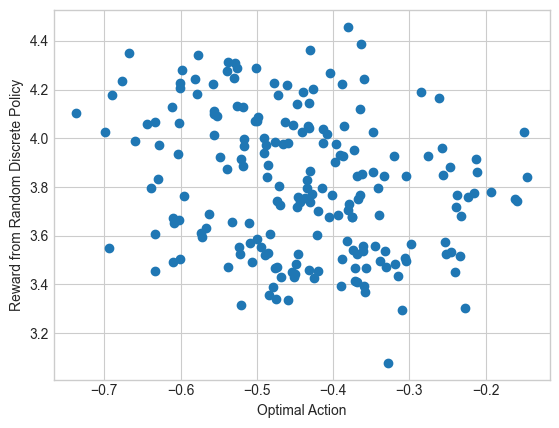

In [36]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 3, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.3

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

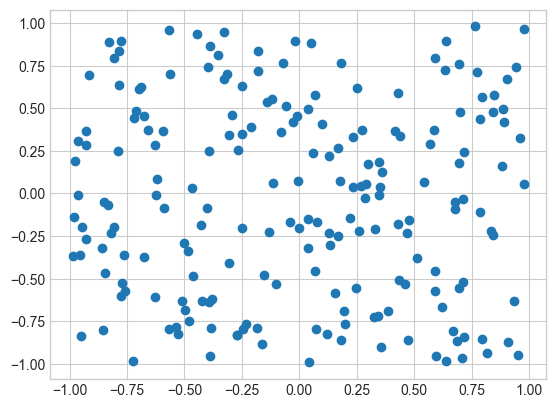

In [37]:
plt.scatter(obs_arr[:,0], obs_arr[:, 1])

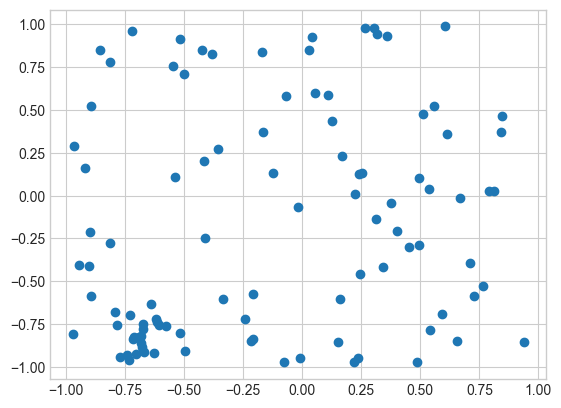

In [38]:
agent_buffer = np.array(ppo_agent.context_buffer)

plt.scatter(agent_buffer[:,0], agent_buffer[:, 1])

In [39]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 15625)


In [40]:
print(df_hist)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


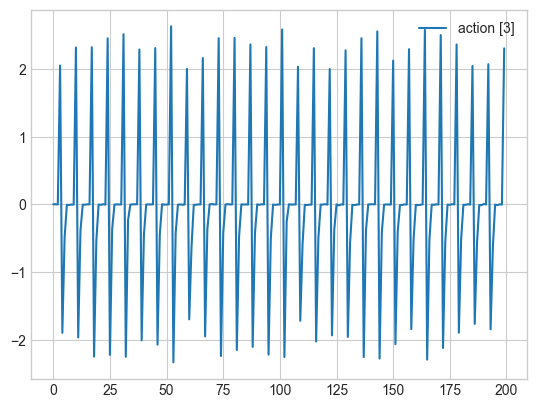

In [41]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

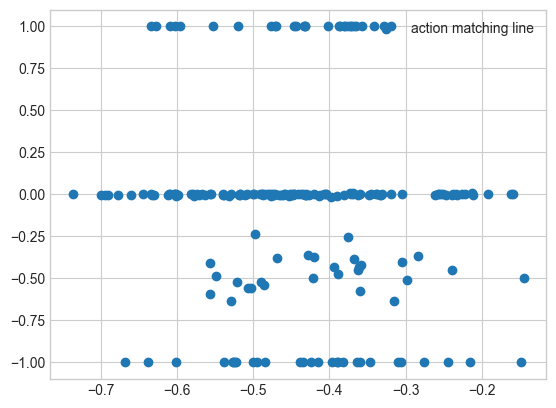

In [42]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[0, 1, 2, 3, 4, 5], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.3

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [43]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=2,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[0, 1, 2, 3, 4, 5],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5]
 [-1.  -1.  -1.  -1.  -1.   0. ]
 ...
 [ 1.   1.   1.   1.   1.   0. ]
 [ 1.   1.   1.   1.   1.   0.5]
 [ 1.   1.   1.   1.   1.   1. ]]
Observation Vals for Env: [[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.78539816]
 [0.         0.         0.         0.         0.         1.57079633]
 ...
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 1.57079633]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 2.35619449]
 [3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]]


In [44]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.3
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [45]:
o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles

In [46]:
ana_sum = -np.sum(o_vals, axis=1) * 0.015
ana_sum

array([-0.        , -0.01178097, -0.02356194, ..., -0.25918139,
       -0.27096237, -0.28274334])

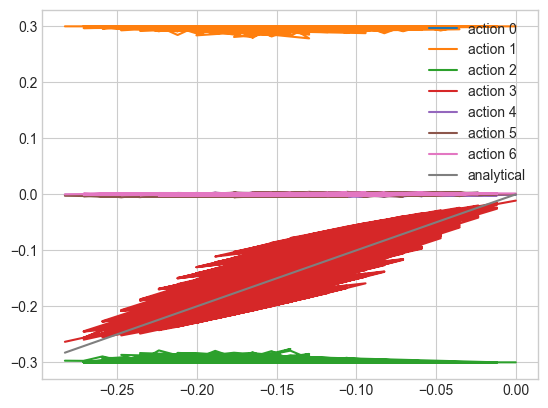

In [47]:
actions = np.array(actions)

for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [60]:
import torch

# random_obs = np.random.choice(ppo_agent.env.unwrapped.discrete_obs_vals, size=1000, replace=True)
random_obs = np.random.uniform(0., np.pi, (1000, 5))
print(random_obs)

[[0.9286326  1.91793799 0.89511114 1.9374896  1.29411316]
 [0.02443295 1.06311776 0.82611699 1.68407084 1.33666419]
 [2.71136828 1.14533025 3.04317269 1.81814773 1.04877819]
 ...
 [0.11452471 2.75161708 0.79421141 3.12192324 0.44341763]
 [2.31340745 0.62971926 0.97242944 3.04667918 1.5563283 ]
 [2.62947417 3.05385021 0.33021498 0.91245799 0.34387255]]


In [61]:
full_reward = []

for sample_obs in random_obs:
    _obs, info = single_n_q_env.reset(debug_obs=np.array([sample_obs]))
    next_obs = torch.Tensor(np.tile(_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.25

    cpu_action = np.mean(cpu_action, axis=0).reshape(1, -1)
    # cpu_action = np.tile(cpu_action, (2, 1))
    total_action = np.concatenate(
        (cpu_action, np.zeros((1, 7))), axis=0
    )
    # total_action = cpu_action
    print(total_action.shape)

    obs, reward, terminated, truncated, info = single_n_q_env.step(total_action)
    full_reward.append(reward)

Sampled angles:  [0.9286326  1.91793799 0.89511114 0.         1.9374896  1.29411316]
Environment Observation: [[-0.40881413  0.22099725 -0.43015455  0.23344419 -0.17614198]]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.998843695619797
Reward (avg): 0.998843695619797 Std: 0.0011560992126034009
obs: [[-0.40881413  0.22099725 -0.43015455  0.23344419 -0.17614198]]
reward: [6.         2.63593636]
Sampled angles:  [0.02443295 1.06311776 0.82611699 0.         1.68407084 1.33666419]
Environment Observation: [[-0.9844455  -0.32319821 -0.47407759  0.07211279 -0.14905315]]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9992454330082947
Reward (avg): 0.9992454330082947 Std: 0.0007539259136504217
obs: [[-0.9844455  -0.32319821 -0.47407759  0.07211279 -0.14905315]]
reward: [6.         2.82145673]
Sampled angles:  [2.71136828 1.14533

In [74]:
full_reward_arr = np.array(full_reward)

policy_reward = full_reward_arr[:,0]
baseline_reward = full_reward_arr[:,1]

In [75]:
policy_reward

array([6.        , 6.        , 6.        , 5.94257326, 5.82523548,
       6.        , 5.79289049, 5.58022667, 5.36589173, 5.71943935,
       5.74082852, 5.64615322, 5.40889868, 6.        , 5.66366065,
       5.88259239, 5.84879114, 5.81526428, 5.44089735, 5.39315316,
       6.        , 6.        , 6.        , 6.        , 5.75903902,
       5.92405769, 5.51159892, 5.13302617, 6.        , 5.89722363,
       5.57454011, 6.        , 5.55286377, 5.92828724, 5.37133438,
       6.        , 4.72797544, 5.89501032, 5.97579302, 5.2725264 ,
       5.56741205, 5.8571596 , 5.98996314, 5.99272309, 6.        ,
       5.28616311, 5.6652581 , 5.59648776, 6.        , 5.68642484,
       5.77321187, 5.60203926, 5.83550494, 5.00165524, 4.95822386,
       5.68981247, 5.66505689, 5.37843643, 6.        , 5.35419603,
       6.        , 6.        , 6.        , 5.4121598 , 6.        ,
       4.98903353, 5.68211677, 6.        , 5.38931852, 5.5145496 ,
       5.5717817 , 5.33582085, 5.474941  , 6.        , 5.21383

In [76]:
print(len(policy_reward))

1000


In [77]:
print(len(baseline_reward))

1000


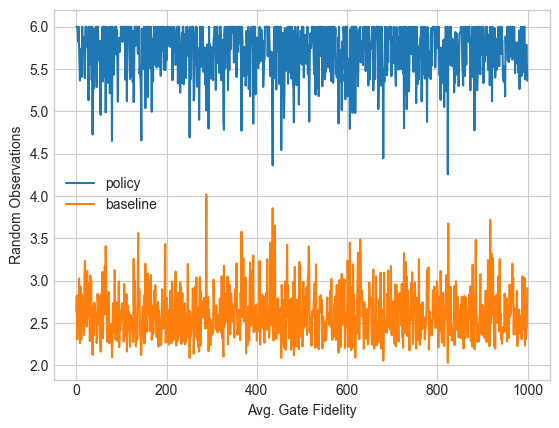

In [78]:
plt.plot(policy_reward, label='policy')
plt.plot(baseline_reward, label='baseline')
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Random Observations')
plt.legend()
plt.show()

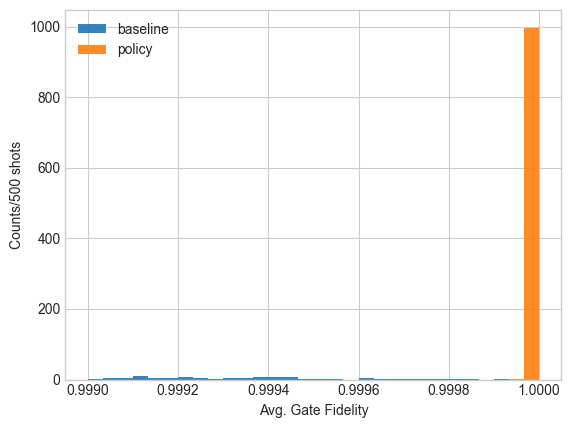

In [79]:
policy_fidelity = 1 - 10**(-np.array(policy_reward))
baseline_fidelity = 1 - 10**(-np.array(baseline_reward))
# baseline_fidelity = np.clip(baseline_fidelity, a_max=1 - 1e-5, a_min=None)

bins = np.linspace(0.999, 1, 31)  # 30 bins from 0 to 1
alpha = 0.9
plt.hist(baseline_fidelity, label='baseline', bins=bins, alpha=alpha)
plt.hist(policy_fidelity, label='policy', bins=bins, alpha=alpha)
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Counts/500 shots')
plt.legend()
plt.show()

In [80]:
import pandas as pd
import seaborn as sns

In [68]:
df = pd.DataFrame({
    "policy": policy_fidelity,
    "baseline": baseline_fidelity
})

df.to_csv('saved_results/fig_results')

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/501668435.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x='Policy', y='Infidelity', palette=['skyblue', 'lightgreen'])


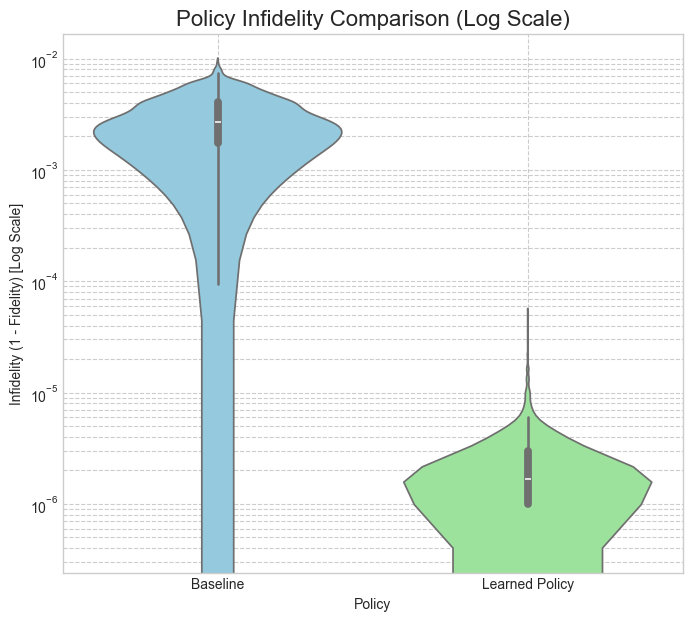

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Create sample data that mimics your situation ---
# Baseline has lower mean and higher variance
# baseline_fidelity = np.random.normal(loc=0.7, scale=0.2, size=1000)
# baseline_fidelity = np.clip(baseline_fidelity, 0.1, 1.0)

# Learned policy is extremely good with very low variance
# We use a log-normal distribution to generate very small errors
# policy_errors = np.random.lognormal(mean=-10, sigma=1.5, size=1000)
# policy_fidelity = 1.0 - policy_errors
# policy_fidelity = np.clip(policy_fidelity, 0.0, 1.0)

# 1. Calculate Infidelity (1 - Fidelity)
max_fidelity = 1.0
baseline_infidelity = max_fidelity - baseline_fidelity
policy_infidelity = max_fidelity - policy_fidelity

# Prevent log(0) errors by clipping to a very small number
policy_infidelity = np.clip(policy_infidelity, 1e-9, None)

# 2. Create a DataFrame for Seaborn
data = pd.DataFrame({
    'Infidelity': np.concatenate([baseline_infidelity, policy_infidelity]),
    'Policy': ['Baseline'] * 1000 + ['Learned Policy'] * 1000
})

# 3. Create the plot
plt.figure(figsize=(8, 7))
ax = sns.violinplot(data=data, x='Policy', y='Infidelity', palette=['skyblue', 'lightgreen'])

# 4. Set the Y-axis to a logarithmic scale
ax.set_yscale('log')

plt.ylabel('Infidelity (1 - Fidelity) [Log Scale]')
plt.title('Policy Infidelity Comparison (Log Scale)', fontsize=16)
plt.grid(True, which='both', linestyle='--')
plt.show()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/1649966246.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, palette=['skyblue', 'lightgreen'], inner=None, cut=0)
/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_36151/1649966246.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, width=0.1,


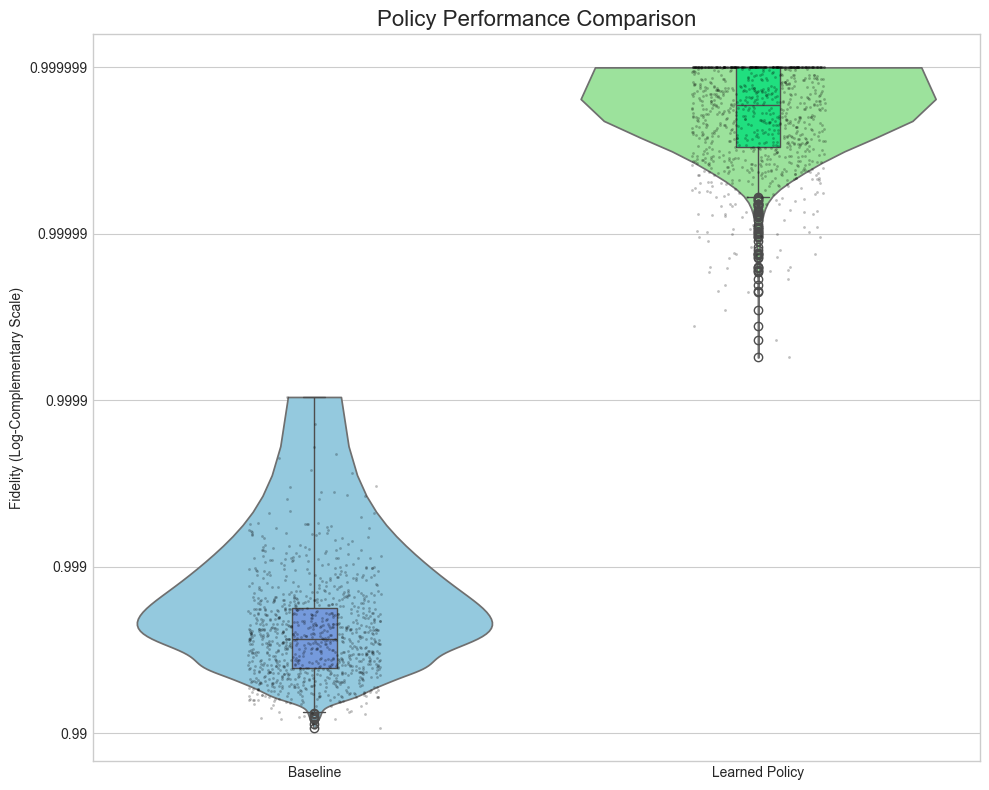

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter

# # --- Create sample data that mimics your situation ---
# # Baseline has lower mean and higher variance
# baseline_fidelity = np.random.normal(loc=0.8, scale=0.15, size=1000)
# baseline_fidelity = np.clip(baseline_fidelity, 0.5, 1.0)

# # Learned policy is extremely good with very low variance, near 1.0
# policy_errors = np.random.lognormal(mean=-11, sigma=1.0, size=1000)
# policy_fidelity = 1.0 - policy_errors
# policy_fidelity = np.clip(policy_fidelity, 0.0, 1.0)


# 1. Calculate Infidelity (1 - Fidelity)
# This is what we will actually plot on the y-axis.
max_fidelity = 1.0
baseline_infidelity = max_fidelity - baseline_fidelity
policy_infidelity = max_fidelity - policy_fidelity

# Prevent log(0) errors by clipping to a very small number
baseline_infidelity = np.clip(baseline_infidelity, 1e-9, None)
policy_infidelity = np.clip(policy_infidelity, 1e-9, None)


# 2. Create a DataFrame for Seaborn
data_to_plot = pd.DataFrame({
    'Infidelity': np.concatenate([baseline_infidelity, policy_infidelity]),
    'Policy': ['Baseline'] * 1000 + ['Learned Policy'] * 1000
})


# 3. Create the Raincloud Plot
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the main components on the 'Infidelity' data
sns.violinplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, palette=['skyblue', 'lightgreen'], inner=None, cut=0)
sns.stripplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, color='black', jitter=0.15, size=2.0, alpha=0.25)
sns.boxplot(data=data_to_plot, x='Policy', y='Infidelity', ax=ax, width=0.1, 
            boxprops={'zorder': 2}, palette=['cornflowerblue', 'springgreen'])


# 4. Set the Y-axis to a logarithmic scale
ax.set_yscale('log')

# 5. Invert the axis so high fidelity (low infidelity) is at the top
ax.invert_yaxis()

# 6. Apply custom formatting to the Y-axis labels
# This function takes the tick value (infidelity) and formats it as a fidelity
formatter = FuncFormatter(lambda y, _: f'{1-y:g}')
ax.yaxis.set_major_formatter(formatter)


# 7. Set final labels and title
ax.set_xlabel(None)
ax.set_ylabel('Fidelity (Log-Complementary Scale)')
ax.set_title('Policy Performance Comparison', fontsize=16)

plt.tight_layout()
plt.show()

In [88]:
data_to_plot.to_csv('saved_results/raincloud_plot_results_fid')

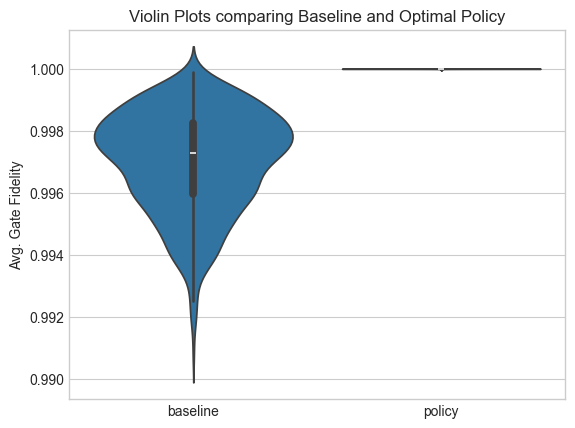

In [83]:
sns.violinplot(data=[baseline_fidelity, policy_fidelity], orient='v')
plt.xticks([0, 1], ['baseline', 'policy'])
plt.ylabel('Avg. Gate Fidelity')
plt.title('Violin Plots comparing Baseline and Optimal Policy')
plt.show()